"Анализ аномалий в поголовье крупного рогатого скота"

Анализ временного ряда надоев

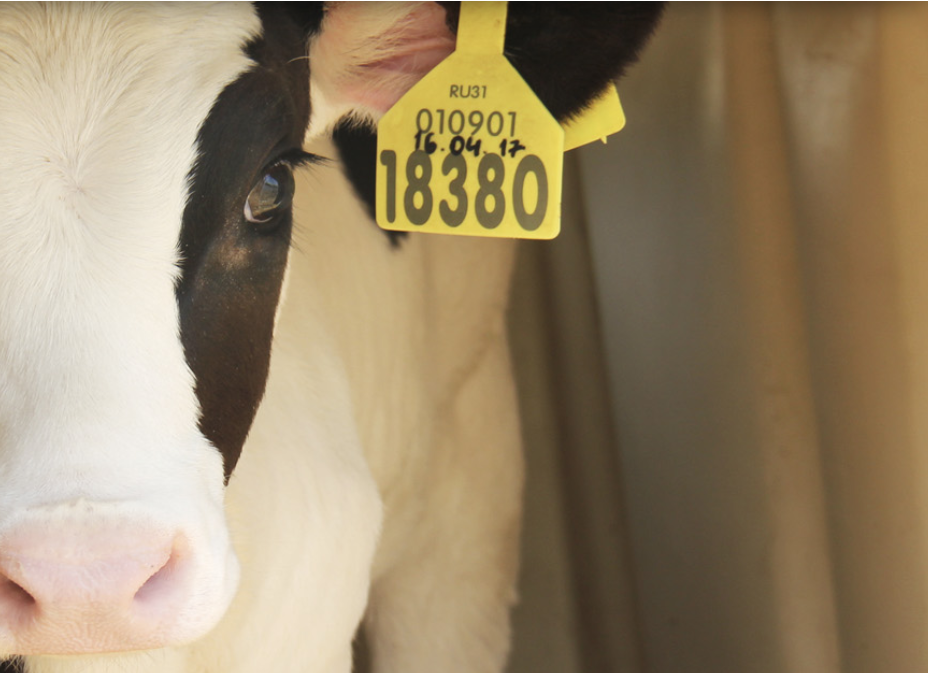

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from datetime import datetime, timedelta
import calendar

In [70]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [71]:
import statsmodels.api as sm
import pmdarima as pm

In [72]:
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [73]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [74]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [75]:
# import sys
# !conda install --yes --prefix {sys.prefix} -c conda-forge catboost
# !conda install --yes --prefix {sys.prefix} -c conda-forge hyperopt

In [76]:
from catboost import CatBoostRegressor

In [77]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [121]:
import pickle

Функция для оценки качества модели:

In [78]:
def error_metrics(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    print(f'\tMAE: {mae}')
    print(f'\tMSE: {mse}')
    print(f'\tRMSE: {rmse}')
    print(f'\tR2: {r2}')

Анализ временного ряда надоев для фермы "Вереск":

In [3]:
df_timeseries_veresk = pd.read_csv('data/' + 'veresk_milking.csv', sep=';')
df_timeseries_veresk['Date'] = pd.to_datetime(df_timeseries_veresk['Date'], format='%d.%m.%Y')
df_timeseries_veresk.index = df_timeseries_veresk.Date.values
df_timeseries_veresk.index = pd.DatetimeIndex(df_timeseries_veresk.index.values, freq=df_timeseries_veresk.index.inferred_freq)

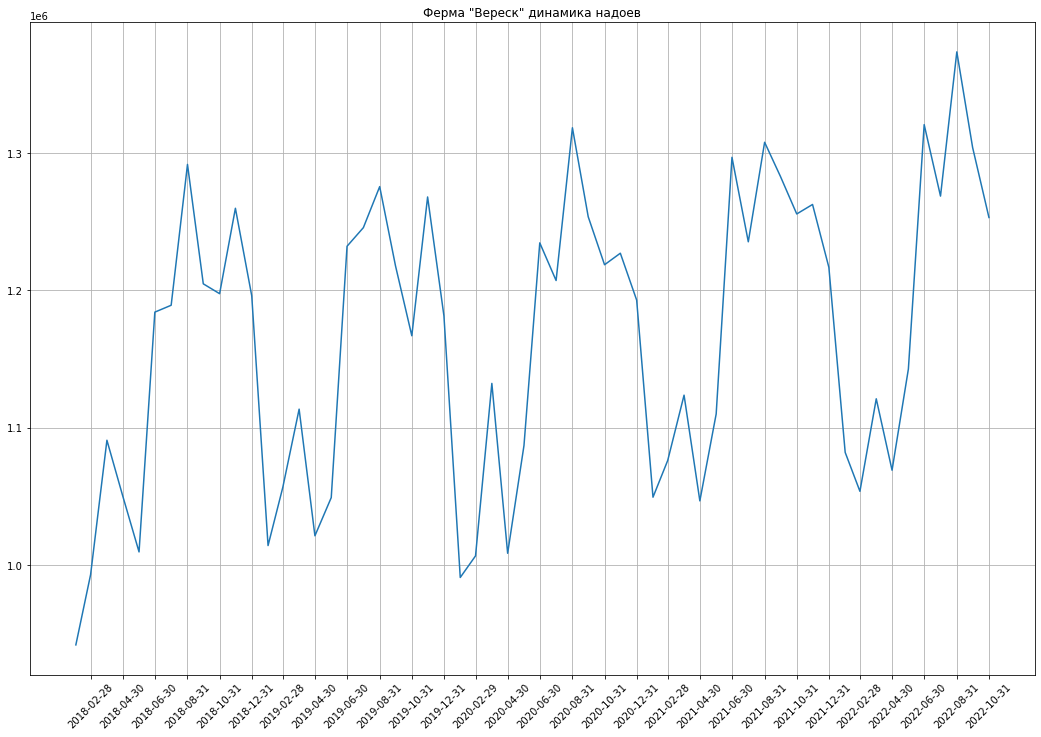

In [186]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot()
ax.plot(df_timeseries_veresk.MilkingAmount)
plt.xticks(df_timeseries_veresk.Date.values[1::2], rotation=45)
plt.grid(True)
plt.title('Ферма "Вереск" динамика надоев');

Проанализируем тренд и сезонность:

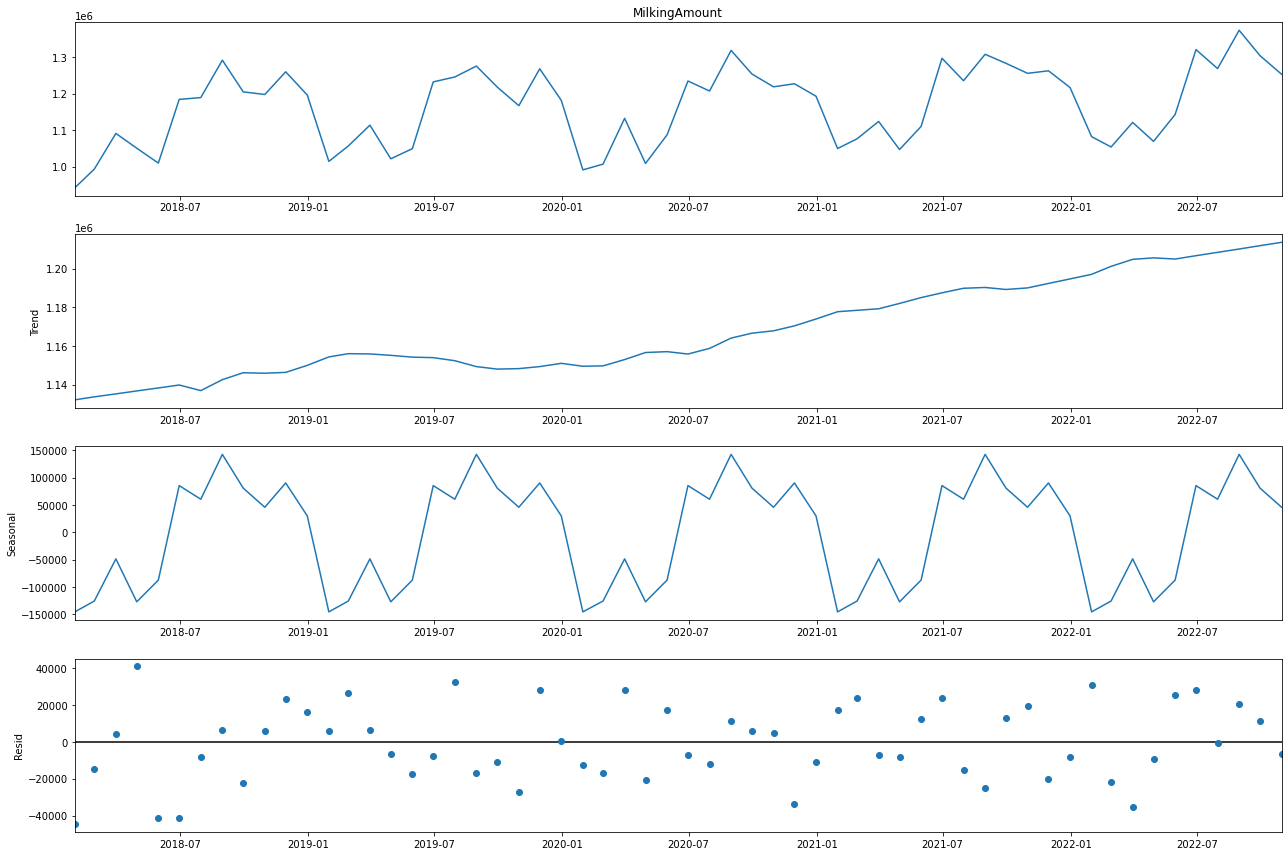

In [195]:
plt.rc('figure',figsize=(18,12))
decomposition = sm.tsa.seasonal_decompose(df_timeseries_veresk['MilkingAmount'], model='additive', extrapolate_trend='freq')
fig = decomposition.plot()
plt.show();

Из графиков наблюдается сезонность в 12 отсчетов ряда, а также то, что тренд имеет возрастающий характер, вероятнее всего, что ряд нестационарный, проведем тест Дики-Фуллера:

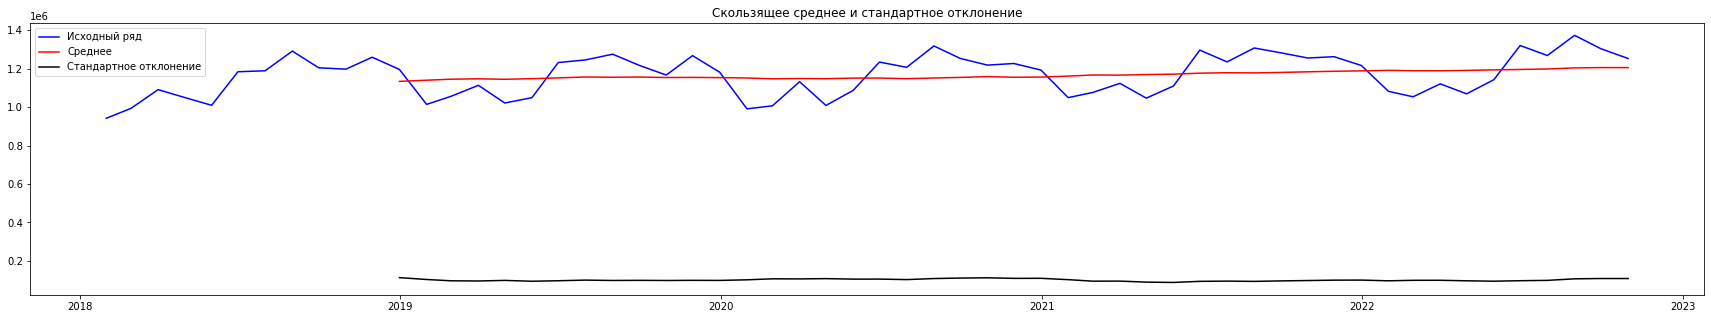

Результаты теста Дики-Фуллера:
p-value = 0.974057766. Временной ряд нестационарный.
Test Statistic                 0.233093
p-value                        0.974058
#Использовано лагов           11.000000
Наблюдений                    46.000000
Критическое значение (1%)     -3.581258
Критическое значение (5%)     -2.926785
Критическое значение (10%)    -2.601541
dtype: float64


In [81]:
window = 12
cutoff = 0.05
rolmean = df_timeseries_veresk.MilkingAmount.rolling(window).mean()
rolstd = df_timeseries_veresk.MilkingAmount.rolling(window).std()

fig = plt.figure(figsize=(30, 5))
orig = plt.plot(df_timeseries_veresk.MilkingAmount, color='blue',label='Исходный ряд')
mean = plt.plot(rolmean, color='red', label='Среднее')
std = plt.plot(rolstd, color='black', label = 'Стандартное отклонение')
plt.legend(loc='best')
plt.title('Скользящее среднее и стандартное отклонение')
plt.show()

print('Результаты теста Дики-Фуллера:')
dftest = adfuller(df_timeseries_veresk.MilkingAmount, autolag='AIC', maxlag = 12)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Использовано лагов','Наблюдений'])
for key,value in dftest[4].items():
    dfoutput['Критическое значение (%s)'%key] = value
pvalue = dftest[1]
if pvalue < cutoff:
    print('p-value = %.9f. Временной ряд стационарный.' % pvalue)
else:
    print('p-value = %.9f. Временной ряд нестационарный.' % pvalue)

print(dfoutput)

Предположение верно - ряд нестационарный, разбиваем ряд на тренировочный и тестовый - данные с 2018 по 2021 год будут тренировочными, за 2022 год - тестовыми:

In [82]:
df_timeseries_ver_train = df_timeseries_veresk.loc[(df_timeseries_veresk['Date'] >= '2018-01-01') & (df_timeseries_veresk['Date'] <= '2022-01-31')].copy()
df_timeseries_ver_test = df_timeseries_veresk.loc[(df_timeseries_veresk['Date'] > '2021-12-31') & (df_timeseries_veresk['Date'] <= '2022-10-31')].copy()

Подберем оптимальные параметры модели SARIMA для данного ряда:

In [83]:
auto_model = pm.auto_arima(df_timeseries_ver_train[:-1].MilkingAmount, test='adf',
                           start_p=0, start_q=0, 
                           max_p=9, max_q=9, max_P=9, max_Q=9, max_D=9,
                           start_P=0, 
                           D=1,
                           d=0, 
                           seasonal=True,
                           m=12,
                           trace=True, error_action='ignore', suppress_warnings=True, 
                           stepwise=True, 
                           random_state=97,
                           n_fits=50, 
                           freq='MS')

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=858.447, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=856.479, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=857.245, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=857.665, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=865.388, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=858.449, Time=0.05 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=855.333, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=857.236, Time=0.10 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=855.621, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=856.953, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=855.693, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=857.690, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AI

Предскажем данные надоев по интервалу тестового набора данных и оценим качество модели:

In [84]:
results_AutoARIMA_ver = pd.DataFrame(auto_model.predict(n_periods=len(df_timeseries_ver_test)), index=df_timeseries_ver_test.index)

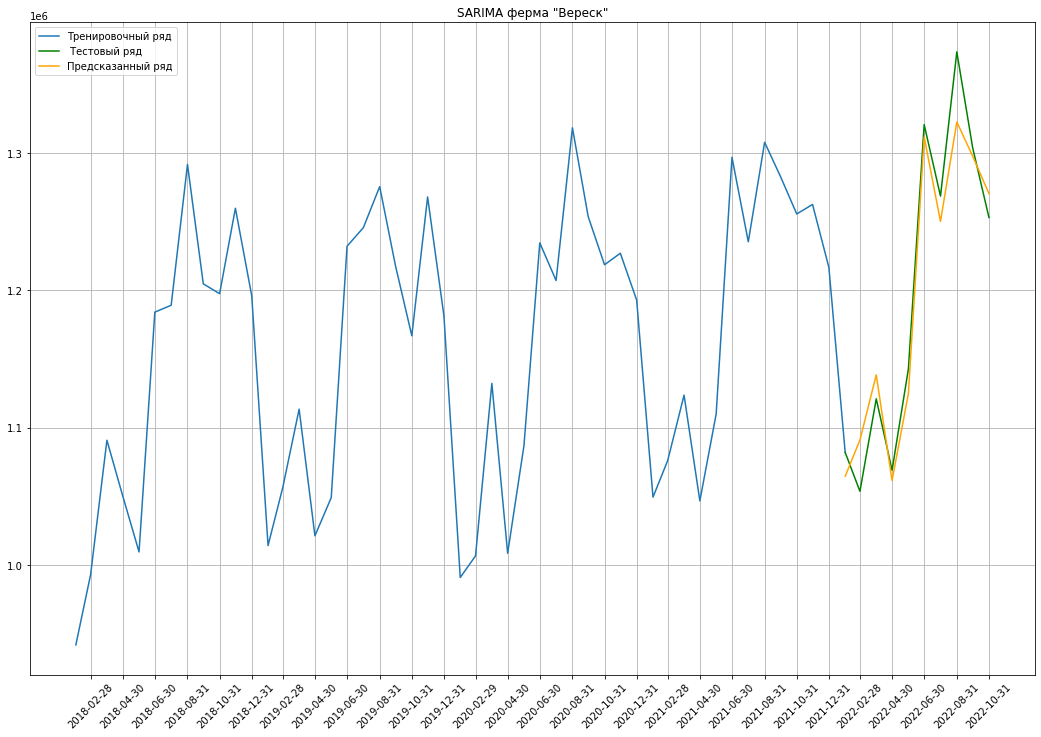

In [189]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot()
ax.plot(df_timeseries_ver_train.MilkingAmount, label='Тренировочный ряд')
ax.plot(df_timeseries_ver_test.MilkingAmount, color='green', label=' Тестовый ряд')
ax.plot(results_AutoARIMA_ver, color='orange', label='Предсказанный ряд')
plt.legend(loc='upper left')
plt.xticks(np.append(df_timeseries_ver_train.Date.values[1::2], df_timeseries_ver_test.Date.values[1::2]), rotation=45)
plt.grid(True)
plt.title('SARIMA ферма "Вереск"');

In [86]:
error_metrics(df_timeseries_ver_test.MilkingAmount, results_AutoARIMA_ver)

	MAE: 19940.5377000113
	MSE: 572848196.5298235
	RMSE: 23934.24735666078
	R2: 0.9540936635264927


Предсказаны данные с приемлемы качеством. Для интереса попробуем методы XGBRegressor и CatBoostRegressor и сравним качество, добавим дополнительные признаки исходя из дат:

In [87]:
df_timeseries_veresk['Year'] = df_timeseries_veresk['Date'].dt.year
df_timeseries_veresk['Quarter'] = df_timeseries_veresk['Date'].dt.quarter
df_timeseries_veresk['Month'] = df_timeseries_veresk['Date'].dt.month
df_timeseries_veresk['Weekofyear'] = df_timeseries_veresk['Date'].dt.isocalendar().week
df_timeseries_veresk['Dayofyear'] = df_timeseries_veresk['Date'].dt.dayofyear
df_timeseries_veresk['Dayofweek'] = df_timeseries_veresk['Date'].dt.dayofweek
df_timeseries_veresk = df_timeseries_veresk.astype({'Weekofyear': int})

In [88]:
X = df_timeseries_veresk.drop(columns=['MilkingAmount', 'Date'], axis=1)
y = df_timeseries_veresk['MilkingAmount']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=97)

Построим базовую модель:

In [90]:
xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [92]:
error_metrics(y_test, y_pred)

	MAE: 37167.07327222224
	MSE: 1669295892.7134116
	RMSE: 40857.01766787942
	R2: 0.8529821558115839


Попробуем определить наиболее значимые признаки:

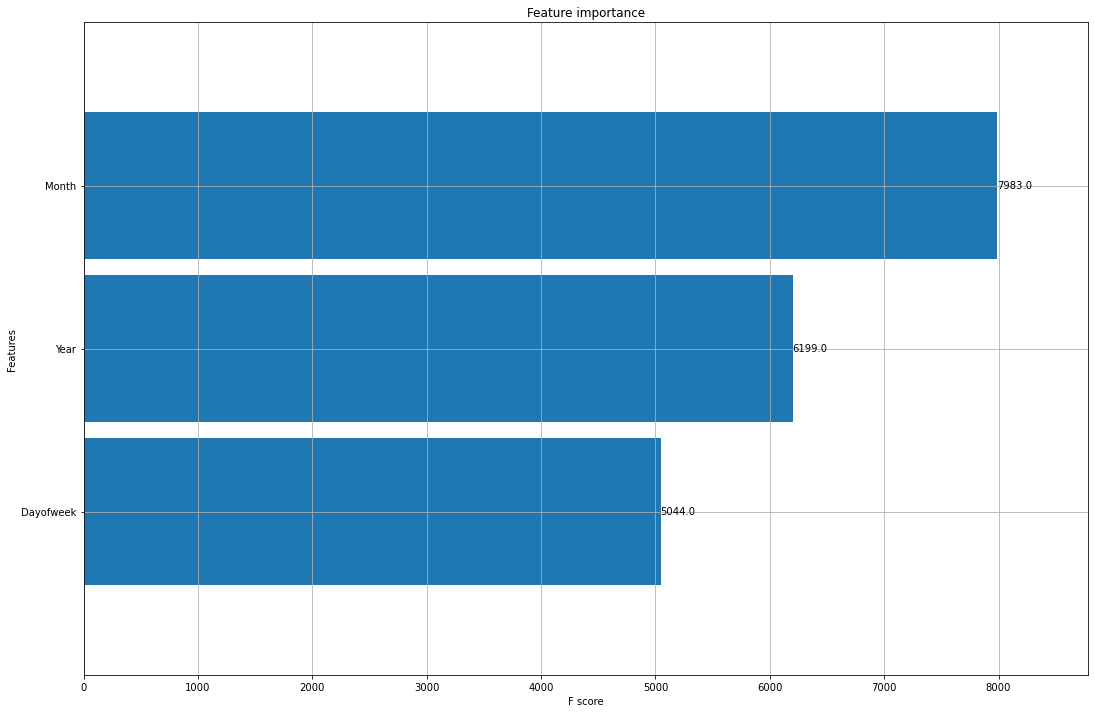

In [198]:
plot_importance(xgb_model, height=0.9);

Уберем малозначащие признаки и заново построим и оценим модель:

In [26]:
df_timeseries_veresk.drop(columns=['Weekofyear', 'Quarter', 'Dayofweek'], axis=1, inplace=True) 
X = df_timeseries_veresk.drop(columns=['MilkingAmount', 'Date'], axis=1)
y = df_timeseries_veresk['MilkingAmount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=97)

In [27]:
xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [28]:
error_metrics(y_test, y_pred)

	MAE: 26932.38852222225
	MSE: 917914077.2348332
	RMSE: 30297.09684499215
	R2: 0.9191576823651642


Качество модели чуть выросло, но не достигло уровня SARIMA, попробуем потюнить гиперпараметры:

In [29]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'subsample' : hp.quniform('subsample', 0.6, 1, 0.05),
        'n_estimators': hp.uniform('n_estimators', 500, 1000)}

In [30]:
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                           reg_alpha = int(space['reg_alpha']) ,reg_lambda=space['reg_lambda'], 
                            colsample_bytree=space['colsample_bytree'], min_child_weight=space['min_child_weight']
                           ,subsample=space['subsample'])
    kfold = KFold(n_splits=5, random_state=123, shuffle=True)
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = 'neg_mean_absolute_percentage_error')
    score = results.mean() * (-100)
    print ("SCORE:", score)
    return {'loss':score, 'status': STATUS_OK, 'model': model}

In [31]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

SCORE:                                                                                                                 
3.215442972472599                                                                                                      
SCORE:                                                                                                                 
3.192514713361923                                                                                                      
SCORE:                                                                                                                 
2.930420323291569                                                                                                      
SCORE:                                                                                                                 
3.240174401048776                                                                                                      
SCORE:                                  

SCORE:                                                                                                                 
2.320345190130029                                                                                                      
SCORE:                                                                                                                 
2.5713098344156977                                                                                                     
SCORE:                                                                                                                 
2.8543532797987834                                                                                                     
SCORE:                                                                                                                 
2.4318983284944498                                                                                                     
SCORE:                                  

In [32]:
print(best)

{'colsample_bytree': 0.7438587759730733, 'gamma': 7.13047618468786, 'max_depth': 11.0, 'min_child_weight': 1.0, 'n_estimators': 911.0721891059595, 'reg_alpha': 0.0592975185282133, 'reg_lambda': 0.11807333337691994, 'subsample': 0.9}


In [33]:
best['max_depth'] = int(best['max_depth'])
best['n_estimators'] = int(best['n_estimators'])

In [34]:
xgb_model_opt = xgb.XGBRegressor(**best)
xgb_model_opt.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7438587759730733, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=7.13047618468786, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=11, max_leaves=0,
             min_child_weight=1.0, missing=nan, monotone_constraints='()',
             n_estimators=911, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, ...)

In [35]:
error_metrics(y_test, y_pred)

	MAE: 26932.38852222225
	MSE: 917914077.2348332
	RMSE: 30297.09684499215
	R2: 0.9191576823651642


Качество осталось на прежнем уровне, попробуем модель CatBoostRegressor, вернем весь набор дополнительных признаков:

In [200]:
df_timeseries_veresk['Year'] = df_timeseries_veresk['Date'].dt.year
df_timeseries_veresk['Quarter'] = df_timeseries_veresk['Date'].dt.quarter
df_timeseries_veresk['Month'] = df_timeseries_veresk['Date'].dt.month
df_timeseries_veresk['Weekofyear'] = df_timeseries_veresk['Date'].dt.isocalendar().week
df_timeseries_veresk['Dayofyear'] = df_timeseries_veresk['Date'].dt.dayofyear
df_timeseries_veresk['Dayofweek'] = df_timeseries_veresk['Date'].dt.dayofweek
df_timeseries_veresk = df_timeseries_veresk.astype({'Weekofyear': int})

X = df_timeseries_veresk.drop(columns=['MilkingAmount', 'Date'], axis=1)
y = df_timeseries_veresk['MilkingAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=97)

In [201]:
cat = CatBoostRegressor()
cat.fit(X_train, y_train, verbose=True, plot=True)
y_pred = cat.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.024621
0:	learn: 102744.4044948	total: 615us	remaining: 615ms
1:	learn: 101709.2334698	total: 1.12ms	remaining: 559ms
2:	learn: 100155.8073252	total: 1.63ms	remaining: 541ms
3:	learn: 98611.6015080	total: 2.17ms	remaining: 541ms
4:	learn: 97256.7308334	total: 2.64ms	remaining: 526ms
5:	learn: 95886.4260875	total: 3.15ms	remaining: 522ms
6:	learn: 94737.7708851	total: 3.71ms	remaining: 526ms
7:	learn: 93501.2976165	total: 4.2ms	remaining: 521ms
8:	learn: 92240.3250718	total: 4.75ms	remaining: 523ms
9:	learn: 91393.8546774	total: 5.31ms	remaining: 525ms
10:	learn: 90410.5796550	total: 5.88ms	remaining: 529ms
11:	learn: 89278.3061381	total: 6.46ms	remaining: 532ms
12:	learn: 87988.5549903	total: 6.92ms	remaining: 526ms
13:	learn: 86742.6791063	total: 7.43ms	remaining: 523ms
14:	learn: 85569.9770751	total: 8.01ms	remaining: 526ms
15:	learn: 84237.8769300	total: 8.42ms	remaining: 518ms
16:	learn: 83354.0010181	total: 8.88ms	remaining: 513ms
17:	learn: 82285.3924351	to

203:	learn: 18197.3276418	total: 132ms	remaining: 515ms
204:	learn: 18103.5966265	total: 133ms	remaining: 515ms
205:	learn: 18020.2685639	total: 133ms	remaining: 513ms
206:	learn: 17911.5464768	total: 134ms	remaining: 513ms
207:	learn: 17785.3946865	total: 134ms	remaining: 512ms
208:	learn: 17694.2763842	total: 135ms	remaining: 510ms
209:	learn: 17597.0296802	total: 135ms	remaining: 509ms
210:	learn: 17497.4974231	total: 136ms	remaining: 508ms
211:	learn: 17399.1065380	total: 136ms	remaining: 507ms
212:	learn: 17304.2737642	total: 137ms	remaining: 506ms
213:	learn: 17201.3897998	total: 137ms	remaining: 505ms
214:	learn: 17122.7611634	total: 138ms	remaining: 504ms
215:	learn: 17013.5074112	total: 138ms	remaining: 503ms
216:	learn: 16897.1521552	total: 139ms	remaining: 501ms
217:	learn: 16801.3720102	total: 139ms	remaining: 500ms
218:	learn: 16677.4577212	total: 140ms	remaining: 499ms
219:	learn: 16602.6071190	total: 141ms	remaining: 498ms
220:	learn: 16521.9950758	total: 141ms	remaining

484:	learn: 4507.6312067	total: 276ms	remaining: 293ms
485:	learn: 4485.1419463	total: 276ms	remaining: 292ms
486:	learn: 4470.8865840	total: 277ms	remaining: 291ms
487:	learn: 4445.7275370	total: 277ms	remaining: 291ms
488:	learn: 4427.3932014	total: 278ms	remaining: 291ms
489:	learn: 4409.2316867	total: 279ms	remaining: 290ms
490:	learn: 4391.2376348	total: 279ms	remaining: 289ms
491:	learn: 4373.5431710	total: 280ms	remaining: 289ms
492:	learn: 4355.8387860	total: 280ms	remaining: 288ms
493:	learn: 4338.4726000	total: 281ms	remaining: 288ms
494:	learn: 4321.1782813	total: 281ms	remaining: 287ms
495:	learn: 4304.1336024	total: 282ms	remaining: 286ms
496:	learn: 4290.3778157	total: 282ms	remaining: 286ms
497:	learn: 4273.6335808	total: 283ms	remaining: 285ms
498:	learn: 4256.8011171	total: 283ms	remaining: 284ms
499:	learn: 4240.3675694	total: 284ms	remaining: 284ms
500:	learn: 4223.9219315	total: 284ms	remaining: 283ms
501:	learn: 4207.7926448	total: 284ms	remaining: 282ms
502:	learn

737:	learn: 1619.0482662	total: 414ms	remaining: 147ms
738:	learn: 1613.1374015	total: 414ms	remaining: 146ms
739:	learn: 1607.2377181	total: 415ms	remaining: 146ms
740:	learn: 1604.1600452	total: 415ms	remaining: 145ms
741:	learn: 1600.1503947	total: 416ms	remaining: 145ms
742:	learn: 1592.8782201	total: 416ms	remaining: 144ms
743:	learn: 1586.1826225	total: 417ms	remaining: 143ms
744:	learn: 1579.5968736	total: 417ms	remaining: 143ms
745:	learn: 1573.8610473	total: 418ms	remaining: 142ms
746:	learn: 1567.8097298	total: 419ms	remaining: 142ms
747:	learn: 1564.8253319	total: 419ms	remaining: 141ms
748:	learn: 1561.8737759	total: 420ms	remaining: 141ms
749:	learn: 1556.2508036	total: 420ms	remaining: 140ms
750:	learn: 1549.8887504	total: 420ms	remaining: 139ms
751:	learn: 1543.4128159	total: 421ms	remaining: 139ms
752:	learn: 1537.1923781	total: 421ms	remaining: 138ms
753:	learn: 1530.8446222	total: 422ms	remaining: 138ms
754:	learn: 1524.7627676	total: 422ms	remaining: 137ms
755:	learn

In [202]:
error_metrics(y_test, y_pred)

	MAE: 36812.96516303424
	MSE: 2096161537.003159
	RMSE: 45783.85672923546
	R2: 0.8153873428994358


Посмотрим на значимость признаков:

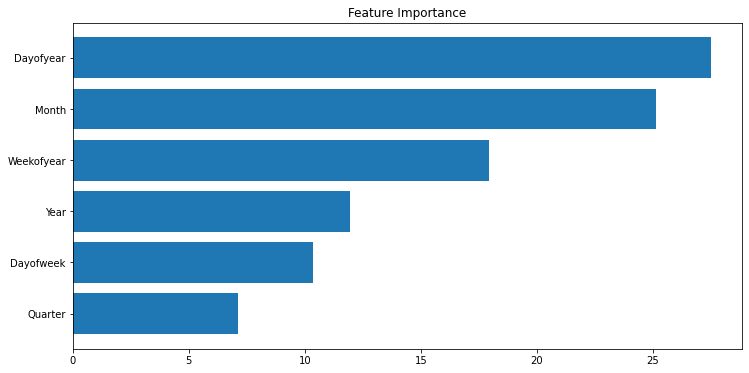

In [203]:
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

Уберем незначащие и попробуем потюнить гиперпараметры:

In [117]:
df_timeseries_veresk.drop(columns=['Weekofyear', 'Quarter', 'Dayofweek'], axis=1, inplace=True) 
X = df_timeseries_veresk.drop(columns=['MilkingAmount', 'Date'], axis=1)
y = df_timeseries_veresk['MilkingAmount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=97)

In [118]:
cat = CatBoostRegressor()
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1158666.9704434	test: 1109492.4877903	best: 1109492.4877903 (0)	total: 379us	remaining: 379ms
1:	learn: 1129722.2685870	test: 1084009.7234155	best: 1084009.7234155 (1)	total: 937us	remaining: 468ms
2:	learn: 1101729.8878631	test: 1061424.9659406	best: 1061424.9659406 (2)	total: 1.3ms	remaining: 434ms
3:	learn: 1070286.5512438	test: 1031509.0556034	best: 1031509.0556034 (3)	total: 1.6ms	remaining: 398ms
4:	learn: 1043433.2171338	test: 1007619.0217565	best: 1007619.0217565 (4)	total: 2.01ms	remaining: 401ms
5:	learn: 1016927.7475326	test: 989536.6179242	best: 989536.6179242 (5)	total: 2.37ms	remaining: 392ms
6:	learn: 991601.7556070	test: 964208.1984996	best: 964208.1984996 (6)	total: 2.79ms	remaining: 396ms
7:	learn: 966924.3456935	test: 942891.9509391	best: 942891.9509391 (7)	total: 3.17ms	remaining: 393ms
8:	learn: 941625.4646876	test: 919461.6864418	best: 919461.6864418 (8)	total: 3.62ms	remaining: 399ms
9:	learn: 918654.4669218	test: 896577.6859042	best: 896577.6859042 (9)

389:	learn: 11243.0929300	test: 90993.0414587	best: 90335.9331107 (360)	total: 153ms	remaining: 239ms
390:	learn: 11158.6668541	test: 90969.6318847	best: 90335.9331107 (360)	total: 153ms	remaining: 239ms
391:	learn: 11109.0584512	test: 90950.7197464	best: 90335.9331107 (360)	total: 154ms	remaining: 239ms
392:	learn: 11027.5939689	test: 90928.5239398	best: 90335.9331107 (360)	total: 154ms	remaining: 238ms
393:	learn: 10979.7386216	test: 90939.9891838	best: 90335.9331107 (360)	total: 155ms	remaining: 238ms
394:	learn: 10901.1294596	test: 90918.9778819	best: 90335.9331107 (360)	total: 155ms	remaining: 237ms
395:	learn: 10856.0401822	test: 90959.8910083	best: 90335.9331107 (360)	total: 155ms	remaining: 237ms
396:	learn: 10823.3836477	test: 91009.6399013	best: 90335.9331107 (360)	total: 156ms	remaining: 237ms
397:	learn: 10772.5993936	test: 91009.6169523	best: 90335.9331107 (360)	total: 156ms	remaining: 236ms
398:	learn: 10740.8614596	test: 91010.1815702	best: 90335.9331107 (360)	total: 157

831:	learn: 3032.2515728	test: 90196.8778775	best: 90196.8778775 (831)	total: 311ms	remaining: 62.8ms
832:	learn: 3026.0930200	test: 90197.9881212	best: 90196.8778775 (831)	total: 311ms	remaining: 62.4ms
833:	learn: 3024.8279823	test: 90188.8856966	best: 90188.8856966 (833)	total: 312ms	remaining: 62ms
834:	learn: 3020.3011781	test: 90184.2859284	best: 90184.2859284 (834)	total: 312ms	remaining: 61.6ms
835:	learn: 3007.2325647	test: 90176.8811554	best: 90176.8811554 (835)	total: 312ms	remaining: 61.3ms
836:	learn: 3003.4658235	test: 90173.6955154	best: 90173.6955154 (836)	total: 313ms	remaining: 60.9ms
837:	learn: 2996.0469753	test: 90169.9316178	best: 90169.9316178 (837)	total: 313ms	remaining: 60.5ms
838:	learn: 2982.7843594	test: 90166.7142874	best: 90166.7142874 (838)	total: 314ms	remaining: 60.2ms
839:	learn: 2972.3804561	test: 90159.8152002	best: 90159.8152002 (839)	total: 314ms	remaining: 59.8ms
840:	learn: 2959.4833545	test: 90156.8253465	best: 90156.8253465 (840)	total: 314ms	

268:	learn: 2992.4912370	test: 97069.2037110	best: 97062.8996669 (264)	total: 89ms	remaining: 242ms
269:	learn: 2936.7412513	test: 97079.1627190	best: 97062.8996669 (264)	total: 89.3ms	remaining: 242ms
270:	learn: 2919.0413232	test: 97081.6377691	best: 97062.8996669 (264)	total: 89.7ms	remaining: 241ms
271:	learn: 2914.0316367	test: 97057.5423484	best: 97057.5423484 (271)	total: 90ms	remaining: 241ms
272:	learn: 2908.7738087	test: 97058.9773443	best: 97057.5423484 (271)	total: 90.4ms	remaining: 241ms
273:	learn: 2892.9966573	test: 97060.5594820	best: 97057.5423484 (271)	total: 90.7ms	remaining: 240ms
274:	learn: 2841.6053597	test: 97044.6154200	best: 97044.6154200 (274)	total: 91.1ms	remaining: 240ms
275:	learn: 2828.0059570	test: 97066.1810074	best: 97044.6154200 (274)	total: 91.4ms	remaining: 240ms
276:	learn: 2816.8037403	test: 97043.4569113	best: 97043.4569113 (276)	total: 91.8ms	remaining: 240ms
277:	learn: 2768.9037336	test: 97048.6961715	best: 97043.4569113 (276)	total: 92.2ms	r

736:	learn: 175.5605390	test: 96370.5681124	best: 96367.6929335 (725)	total: 245ms	remaining: 87.3ms
737:	learn: 174.8845363	test: 96370.4691909	best: 96367.6929335 (725)	total: 245ms	remaining: 87ms
738:	learn: 174.7078013	test: 96369.7625058	best: 96367.6929335 (725)	total: 245ms	remaining: 86.7ms
739:	learn: 170.8979802	test: 96369.3262213	best: 96367.6929335 (725)	total: 246ms	remaining: 86.4ms
740:	learn: 168.1120955	test: 96370.3602931	best: 96367.6929335 (725)	total: 246ms	remaining: 86ms
741:	learn: 167.3163844	test: 96371.2466861	best: 96367.6929335 (725)	total: 246ms	remaining: 85.7ms
742:	learn: 166.1981083	test: 96370.3644717	best: 96367.6929335 (725)	total: 247ms	remaining: 85.4ms
743:	learn: 165.5988214	test: 96370.9882531	best: 96367.6929335 (725)	total: 247ms	remaining: 85.1ms
744:	learn: 163.8961661	test: 96370.8987700	best: 96367.6929335 (725)	total: 248ms	remaining: 84.7ms
745:	learn: 163.3261627	test: 96371.5133240	best: 96367.6929335 (725)	total: 248ms	remaining: 8

147:	learn: 71655.3375661	test: 147385.8606595	best: 147385.8606595 (147)	total: 50.6ms	remaining: 291ms
148:	learn: 70667.3682087	test: 146174.8129313	best: 146174.8129313 (148)	total: 51ms	remaining: 292ms
149:	learn: 69740.9084671	test: 145307.6660565	best: 145307.6660565 (149)	total: 51.4ms	remaining: 291ms
150:	learn: 68872.1865486	test: 144350.3269390	best: 144350.3269390 (150)	total: 51.7ms	remaining: 291ms
151:	learn: 67957.4256026	test: 143214.5407023	best: 143214.5407023 (151)	total: 52.1ms	remaining: 291ms
152:	learn: 66893.3130135	test: 142178.0437143	best: 142178.0437143 (152)	total: 52.4ms	remaining: 290ms
153:	learn: 65973.6940041	test: 141185.1615518	best: 141185.1615518 (153)	total: 52.8ms	remaining: 290ms
154:	learn: 65139.3669799	test: 140163.2829185	best: 140163.2829185 (154)	total: 53.1ms	remaining: 290ms
155:	learn: 64295.3109420	test: 139277.3025621	best: 139277.3025621 (155)	total: 53.5ms	remaining: 289ms
156:	learn: 63502.8855090	test: 138249.6330813	best: 1382

597:	learn: 13663.8442348	test: 81913.4769872	best: 81890.1341355 (594)	total: 208ms	remaining: 140ms
598:	learn: 13613.7120122	test: 81924.3509500	best: 81890.1341355 (594)	total: 208ms	remaining: 139ms
599:	learn: 13593.8689355	test: 81917.8046084	best: 81890.1341355 (594)	total: 209ms	remaining: 139ms
600:	learn: 13574.4979418	test: 81894.7950191	best: 81890.1341355 (594)	total: 209ms	remaining: 139ms
601:	learn: 13543.1781947	test: 81907.6885833	best: 81890.1341355 (594)	total: 209ms	remaining: 138ms
602:	learn: 13490.1313038	test: 81886.5138309	best: 81886.5138309 (602)	total: 210ms	remaining: 138ms
603:	learn: 13438.0933050	test: 81861.2149792	best: 81861.2149792 (603)	total: 210ms	remaining: 138ms
604:	learn: 13418.5741183	test: 81855.0736828	best: 81855.0736828 (604)	total: 210ms	remaining: 137ms
605:	learn: 13339.6295447	test: 81826.3795057	best: 81826.3795057 (605)	total: 211ms	remaining: 137ms
606:	learn: 13293.9504105	test: 81842.8253018	best: 81826.3795057 (605)	total: 211

46:	learn: 63411.3194407	test: 160626.7230725	best: 160626.7230725 (46)	total: 16.3ms	remaining: 330ms
47:	learn: 60678.1809783	test: 157100.0970362	best: 157100.0970362 (47)	total: 16.6ms	remaining: 329ms
48:	learn: 58523.2143756	test: 155562.3634673	best: 155562.3634673 (48)	total: 16.9ms	remaining: 329ms
49:	learn: 56720.6451234	test: 153160.0203838	best: 153160.0203838 (49)	total: 17.3ms	remaining: 328ms
50:	learn: 54835.7841275	test: 151769.2690402	best: 151769.2690402 (50)	total: 17.6ms	remaining: 328ms
51:	learn: 53088.5435951	test: 150777.7274886	best: 150777.7274886 (51)	total: 18ms	remaining: 328ms
52:	learn: 51309.5262564	test: 147972.9170174	best: 147972.9170174 (52)	total: 18.3ms	remaining: 327ms
53:	learn: 49511.8538344	test: 145790.3074195	best: 145790.3074195 (53)	total: 18.8ms	remaining: 330ms
54:	learn: 47857.4588689	test: 143181.9430898	best: 143181.9430898 (54)	total: 19.2ms	remaining: 330ms
55:	learn: 46389.6595661	test: 141226.2333084	best: 141226.2333084 (55)	tot

518:	learn: 1862.9040892	test: 98198.9677082	best: 98196.7208830 (517)	total: 175ms	remaining: 162ms
519:	learn: 1858.3462627	test: 98190.6692088	best: 98190.6692088 (519)	total: 175ms	remaining: 162ms
520:	learn: 1857.6131325	test: 98183.7617898	best: 98183.7617898 (520)	total: 175ms	remaining: 161ms
521:	learn: 1852.7721366	test: 98184.4231184	best: 98183.7617898 (520)	total: 176ms	remaining: 161ms
522:	learn: 1852.0844598	test: 98177.6777108	best: 98177.6777108 (522)	total: 176ms	remaining: 161ms
523:	learn: 1849.1015095	test: 98180.0193567	best: 98177.6777108 (522)	total: 177ms	remaining: 160ms
524:	learn: 1843.7836412	test: 98165.4906618	best: 98165.4906618 (524)	total: 177ms	remaining: 160ms
525:	learn: 1843.1185282	test: 98158.9587863	best: 98158.9587863 (525)	total: 177ms	remaining: 160ms
526:	learn: 1840.3255859	test: 98160.8627056	best: 98158.9587863 (525)	total: 178ms	remaining: 159ms
527:	learn: 1835.7332015	test: 98161.6432574	best: 98158.9587863 (525)	total: 178ms	remaini

955:	learn: 481.4618454	test: 97431.4059226	best: 97412.3978125 (889)	total: 333ms	remaining: 15.3ms
956:	learn: 475.7207399	test: 97434.3181944	best: 97412.3978125 (889)	total: 333ms	remaining: 15ms
957:	learn: 473.3769845	test: 97437.3579756	best: 97412.3978125 (889)	total: 333ms	remaining: 14.6ms
958:	learn: 471.4486066	test: 97437.4370206	best: 97412.3978125 (889)	total: 334ms	remaining: 14.3ms
959:	learn: 469.6567845	test: 97437.4894887	best: 97412.3978125 (889)	total: 334ms	remaining: 13.9ms
960:	learn: 469.1154979	test: 97437.3459231	best: 97412.3978125 (889)	total: 334ms	remaining: 13.6ms
961:	learn: 468.2963482	test: 97438.4283359	best: 97412.3978125 (889)	total: 335ms	remaining: 13.2ms
962:	learn: 465.3409978	test: 97439.2716242	best: 97412.3978125 (889)	total: 335ms	remaining: 12.9ms
963:	learn: 464.6922880	test: 97436.7764366	best: 97412.3978125 (889)	total: 335ms	remaining: 12.5ms
964:	learn: 464.0823460	test: 97434.4037135	best: 97412.3978125 (889)	total: 336ms	remaining:

395:	learn: 26216.4817800	test: 77199.8606683	best: 77199.8606683 (395)	total: 139ms	remaining: 213ms
396:	learn: 26184.4902025	test: 77097.9653065	best: 77097.9653065 (396)	total: 140ms	remaining: 212ms
397:	learn: 26152.8016012	test: 76996.7340454	best: 76996.7340454 (397)	total: 140ms	remaining: 212ms
398:	learn: 26121.4125345	test: 76896.1610986	best: 76896.1610986 (398)	total: 140ms	remaining: 211ms
399:	learn: 26090.3196356	test: 76796.2407639	best: 76796.2407639 (399)	total: 141ms	remaining: 211ms
400:	learn: 25988.2010463	test: 76770.9606675	best: 76770.9606675 (400)	total: 141ms	remaining: 211ms
401:	learn: 25957.5640446	test: 76672.3064852	best: 76672.3064852 (401)	total: 141ms	remaining: 210ms
402:	learn: 25927.2119951	test: 76574.2828285	best: 76574.2828285 (402)	total: 142ms	remaining: 210ms
403:	learn: 25897.1419370	test: 76543.5123411	best: 76543.5123411 (403)	total: 142ms	remaining: 210ms
404:	learn: 25867.3509644	test: 76446.7072396	best: 76446.7072396 (404)	total: 142

845:	learn: 12344.6440284	test: 68914.7282821	best: 68914.7282821 (845)	total: 298ms	remaining: 54.2ms
846:	learn: 12332.1891502	test: 68888.3262985	best: 68888.3262985 (846)	total: 298ms	remaining: 53.9ms
847:	learn: 12319.8917088	test: 68871.6555028	best: 68871.6555028 (847)	total: 299ms	remaining: 53.5ms
848:	learn: 12300.5102664	test: 68888.0364412	best: 68871.6555028 (847)	total: 299ms	remaining: 53.2ms
849:	learn: 12287.4899416	test: 68886.0640788	best: 68871.6555028 (847)	total: 299ms	remaining: 52.8ms
850:	learn: 12275.3414272	test: 68860.1595442	best: 68860.1595442 (850)	total: 300ms	remaining: 52.5ms
851:	learn: 12256.2289019	test: 68876.3510915	best: 68860.1595442 (850)	total: 300ms	remaining: 52.1ms
852:	learn: 12237.4111714	test: 68892.2057747	best: 68860.1595442 (850)	total: 300ms	remaining: 51.8ms
853:	learn: 12221.8648340	test: 68871.8519204	best: 68860.1595442 (850)	total: 301ms	remaining: 51.4ms
854:	learn: 12203.8372945	test: 68844.8757934	best: 68844.8757934 (854)	t

300:	learn: 10625.7923350	test: 59102.4952083	best: 59023.1429985 (288)	total: 101ms	remaining: 235ms
301:	learn: 10576.7240078	test: 59073.5992560	best: 59023.1429985 (288)	total: 102ms	remaining: 235ms
302:	learn: 10534.1444577	test: 59104.6140097	best: 59023.1429985 (288)	total: 102ms	remaining: 235ms
303:	learn: 10520.0441026	test: 59098.1468244	best: 59023.1429985 (288)	total: 102ms	remaining: 234ms
304:	learn: 10469.3295665	test: 59114.9084916	best: 59023.1429985 (288)	total: 103ms	remaining: 234ms
305:	learn: 10462.3623377	test: 59069.0602432	best: 59023.1429985 (288)	total: 103ms	remaining: 234ms
306:	learn: 10316.1465930	test: 58948.2258806	best: 58948.2258806 (306)	total: 103ms	remaining: 234ms
307:	learn: 10302.7312007	test: 58940.9863904	best: 58940.9863904 (307)	total: 104ms	remaining: 233ms
308:	learn: 10295.8962277	test: 58895.7104932	best: 58895.7104932 (308)	total: 104ms	remaining: 233ms
309:	learn: 10249.9384884	test: 58866.8669329	best: 58866.8669329 (309)	total: 105

716:	learn: 3002.6458471	test: 55853.5474896	best: 55853.5474896 (716)	total: 261ms	remaining: 103ms
717:	learn: 2998.2252989	test: 55861.2987171	best: 55853.5474896 (716)	total: 261ms	remaining: 103ms
718:	learn: 2997.8502187	test: 55856.7713664	best: 55853.5474896 (716)	total: 262ms	remaining: 102ms
719:	learn: 2997.4903812	test: 55852.3388441	best: 55852.3388441 (719)	total: 262ms	remaining: 102ms
720:	learn: 2995.9000399	test: 55851.9408425	best: 55851.9408425 (720)	total: 262ms	remaining: 102ms
721:	learn: 2994.4715854	test: 55851.8056447	best: 55851.8056447 (721)	total: 263ms	remaining: 101ms
722:	learn: 2990.7782022	test: 55850.4423227	best: 55850.4423227 (722)	total: 263ms	remaining: 101ms
723:	learn: 2990.4317062	test: 55846.0938256	best: 55846.0938256 (723)	total: 263ms	remaining: 100ms
724:	learn: 2988.9056519	test: 55845.7139455	best: 55845.7139455 (724)	total: 264ms	remaining: 100ms
725:	learn: 2987.5819688	test: 55845.5152215	best: 55845.5152215 (725)	total: 264ms	remaini

169:	learn: 104171.0551296	test: 160091.9514672	best: 160091.9514672 (169)	total: 56.8ms	remaining: 277ms
170:	learn: 102932.1856498	test: 158714.7807876	best: 158714.7807876 (170)	total: 57.2ms	remaining: 277ms
171:	learn: 101457.8174950	test: 157185.0798650	best: 157185.0798650 (171)	total: 57.5ms	remaining: 277ms
172:	learn: 100556.2812859	test: 156633.6347841	best: 156633.6347841 (172)	total: 57.9ms	remaining: 277ms
173:	learn: 99247.2548897	test: 155077.2547479	best: 155077.2547479 (173)	total: 58.2ms	remaining: 276ms
174:	learn: 98286.7484619	test: 153964.9646150	best: 153964.9646150 (174)	total: 58.6ms	remaining: 276ms
175:	learn: 97149.4878410	test: 152695.4514732	best: 152695.4514732 (175)	total: 58.9ms	remaining: 276ms
176:	learn: 96309.1833674	test: 151829.4364993	best: 151829.4364993 (176)	total: 59.3ms	remaining: 276ms
177:	learn: 95208.7331596	test: 150567.5302508	best: 150567.5302508 (177)	total: 59.6ms	remaining: 275ms
178:	learn: 94121.0621867	test: 149481.7083048	best

628:	learn: 21892.5064188	test: 67694.7151377	best: 67694.7151377 (628)	total: 216ms	remaining: 127ms
629:	learn: 21846.0993645	test: 67717.0814322	best: 67694.7151377 (628)	total: 216ms	remaining: 127ms
630:	learn: 21837.7502229	test: 67704.6328215	best: 67694.7151377 (628)	total: 216ms	remaining: 127ms
631:	learn: 21770.5976659	test: 67676.1462743	best: 67676.1462743 (631)	total: 217ms	remaining: 126ms
632:	learn: 21756.7628065	test: 67632.0230656	best: 67632.0230656 (632)	total: 217ms	remaining: 126ms
633:	learn: 21711.2836730	test: 67654.0719621	best: 67632.0230656 (632)	total: 217ms	remaining: 126ms
634:	learn: 21703.0534938	test: 67641.8566036	best: 67632.0230656 (632)	total: 218ms	remaining: 125ms
635:	learn: 21694.8818501	test: 67606.3577877	best: 67606.3577877 (635)	total: 218ms	remaining: 125ms
636:	learn: 21681.3123673	test: 67562.8231111	best: 67562.8231111 (636)	total: 219ms	remaining: 125ms
637:	learn: 21669.6327015	test: 67515.6873671	best: 67515.6873671 (637)	total: 219

90:	learn: 39680.7656271	test: 84128.3860710	best: 84128.3860710 (90)	total: 29.2ms	remaining: 292ms
91:	learn: 39247.4467522	test: 83479.7370046	best: 83479.7370046 (91)	total: 29.6ms	remaining: 292ms
92:	learn: 38763.1885473	test: 82655.5290379	best: 82655.5290379 (92)	total: 29.9ms	remaining: 292ms
93:	learn: 38391.0454278	test: 82567.0658953	best: 82567.0658953 (93)	total: 30.2ms	remaining: 292ms
94:	learn: 38033.6720680	test: 82077.7983536	best: 82077.7983536 (94)	total: 30.6ms	remaining: 291ms
95:	learn: 37642.1109881	test: 81314.9198947	best: 81314.9198947 (95)	total: 30.9ms	remaining: 291ms
96:	learn: 37305.2996798	test: 80846.7952332	best: 80846.7952332 (96)	total: 31.3ms	remaining: 291ms
97:	learn: 36981.2311525	test: 80386.9480505	best: 80386.9480505 (97)	total: 31.7ms	remaining: 291ms
98:	learn: 36575.9045353	test: 79689.2089701	best: 79689.2089701 (98)	total: 32.1ms	remaining: 292ms
99:	learn: 36270.2348788	test: 79249.6754966	best: 79249.6754966 (99)	total: 32.5ms	remaini

556:	learn: 6714.1936932	test: 55883.6141476	best: 55666.2420564 (454)	total: 185ms	remaining: 147ms
557:	learn: 6709.6968241	test: 55859.4042828	best: 55666.2420564 (454)	total: 186ms	remaining: 147ms
558:	learn: 6689.8441714	test: 55865.3627444	best: 55666.2420564 (454)	total: 186ms	remaining: 147ms
559:	learn: 6686.4446885	test: 55865.3667105	best: 55666.2420564 (454)	total: 186ms	remaining: 146ms
560:	learn: 6682.1873565	test: 55841.8704081	best: 55666.2420564 (454)	total: 187ms	remaining: 146ms
561:	learn: 6678.9870179	test: 55841.7089384	best: 55666.2420564 (454)	total: 187ms	remaining: 146ms
562:	learn: 6674.9489309	test: 55818.7123335	best: 55666.2420564 (454)	total: 187ms	remaining: 145ms
563:	learn: 6647.8951243	test: 55852.6633381	best: 55666.2420564 (454)	total: 188ms	remaining: 145ms
564:	learn: 6628.8142302	test: 55858.2605079	best: 55666.2420564 (454)	total: 188ms	remaining: 145ms
565:	learn: 6610.4676894	test: 55864.1103362	best: 55666.2420564 (454)	total: 188ms	remaini

17:	learn: 914469.9585429	test: 890133.6202003	best: 890133.6202003 (17)	total: 6.3ms	remaining: 344ms
18:	learn: 897648.8207497	test: 877120.1887498	best: 877120.1887498 (18)	total: 6.66ms	remaining: 344ms
19:	learn: 878700.0854708	test: 859640.6990979	best: 859640.6990979 (19)	total: 6.93ms	remaining: 339ms
20:	learn: 868234.7481683	test: 850930.9774918	best: 850930.9774918 (20)	total: 7.27ms	remaining: 339ms
21:	learn: 855957.5717668	test: 838267.3882878	best: 838267.3882878 (21)	total: 7.61ms	remaining: 338ms
22:	learn: 837427.4826820	test: 820857.4148934	best: 820857.4148934 (22)	total: 7.88ms	remaining: 335ms
23:	learn: 827597.8267774	test: 816437.4029226	best: 816437.4029226 (23)	total: 8.35ms	remaining: 340ms
24:	learn: 819232.9530854	test: 805855.7698350	best: 805855.7698350 (24)	total: 8.7ms	remaining: 339ms
25:	learn: 809143.3816056	test: 798783.3236362	best: 798783.3236362 (25)	total: 9.08ms	remaining: 340ms
26:	learn: 798902.3566351	test: 787568.7937061	best: 787568.793706

469:	learn: 31550.9360109	test: 83987.3499879	best: 83987.3499879 (469)	total: 164ms	remaining: 185ms
470:	learn: 31509.4579962	test: 83963.8408226	best: 83963.8408226 (470)	total: 165ms	remaining: 185ms
471:	learn: 31468.2654704	test: 83887.2391550	best: 83887.2391550 (471)	total: 165ms	remaining: 185ms
472:	learn: 31427.3555447	test: 83810.9252151	best: 83810.9252151 (472)	total: 166ms	remaining: 184ms
473:	learn: 31386.7253751	test: 83734.8978652	best: 83734.8978652 (473)	total: 166ms	remaining: 184ms
474:	learn: 31303.1625530	test: 83606.7955708	best: 83606.7955708 (474)	total: 166ms	remaining: 184ms
475:	learn: 31262.9314834	test: 83584.2448817	best: 83584.2448817 (475)	total: 167ms	remaining: 184ms
476:	learn: 31222.9746271	test: 83509.2532170	best: 83509.2532170 (476)	total: 167ms	remaining: 183ms
477:	learn: 31183.2892643	test: 83434.5425559	best: 83434.5425559 (477)	total: 168ms	remaining: 183ms
478:	learn: 31143.8727159	test: 83360.1118087	best: 83360.1118087 (478)	total: 168

928:	learn: 19081.4942540	test: 68306.8237302	best: 68306.8237302 (928)	total: 322ms	remaining: 24.6ms
929:	learn: 19056.5795028	test: 68336.9080370	best: 68306.8237302 (928)	total: 322ms	remaining: 24.2ms
930:	learn: 19016.5191791	test: 68356.2913515	best: 68306.8237302 (928)	total: 322ms	remaining: 23.9ms
931:	learn: 18992.0643833	test: 68337.9359761	best: 68306.8237302 (928)	total: 323ms	remaining: 23.5ms
932:	learn: 18952.3665797	test: 68357.2008846	best: 68306.8237302 (928)	total: 323ms	remaining: 23.2ms
933:	learn: 18930.4119006	test: 68368.9105587	best: 68306.8237302 (928)	total: 323ms	remaining: 22.9ms
934:	learn: 18906.1941222	test: 68350.6462460	best: 68306.8237302 (928)	total: 324ms	remaining: 22.5ms
935:	learn: 18866.8151459	test: 68369.9423200	best: 68306.8237302 (928)	total: 324ms	remaining: 22.2ms
936:	learn: 18842.7911671	test: 68351.8508477	best: 68306.8237302 (928)	total: 325ms	remaining: 21.8ms
937:	learn: 18803.7695277	test: 68371.0279932	best: 68306.8237302 (928)	t

386:	learn: 16036.8736783	test: 57183.3004012	best: 57183.3004012 (386)	total: 131ms	remaining: 208ms
387:	learn: 16023.2441111	test: 57148.3170889	best: 57148.3170889 (387)	total: 132ms	remaining: 208ms
388:	learn: 15964.8204880	test: 57208.7415712	best: 57148.3170889 (387)	total: 132ms	remaining: 208ms
389:	learn: 15874.3447999	test: 57110.8759355	best: 57110.8759355 (389)	total: 132ms	remaining: 207ms
390:	learn: 15861.1834157	test: 57075.0593074	best: 57075.0593074 (390)	total: 133ms	remaining: 207ms
391:	learn: 15848.3111528	test: 57031.0240745	best: 57031.0240745 (391)	total: 133ms	remaining: 206ms
392:	learn: 15794.3835486	test: 57021.1812796	best: 57021.1812796 (392)	total: 133ms	remaining: 206ms
393:	learn: 15781.8969247	test: 56978.1954734	best: 56978.1954734 (393)	total: 133ms	remaining: 205ms
394:	learn: 15769.6778382	test: 56935.8069720	best: 56935.8069720 (394)	total: 134ms	remaining: 205ms
395:	learn: 15635.5933234	test: 56821.6634505	best: 56821.6634505 (395)	total: 134

860:	learn: 3484.0421918	test: 51563.1786155	best: 51365.8145941 (837)	total: 288ms	remaining: 46.5ms
861:	learn: 3476.9911432	test: 51572.4304528	best: 51365.8145941 (837)	total: 288ms	remaining: 46.2ms
862:	learn: 3471.3903395	test: 51571.4011742	best: 51365.8145941 (837)	total: 289ms	remaining: 45.8ms
863:	learn: 3466.3023955	test: 51570.3356706	best: 51365.8145941 (837)	total: 289ms	remaining: 45.5ms
864:	learn: 3463.7619170	test: 51569.8633676	best: 51365.8145941 (837)	total: 289ms	remaining: 45.2ms
865:	learn: 3461.3416623	test: 51569.3171706	best: 51365.8145941 (837)	total: 290ms	remaining: 44.8ms
866:	learn: 3456.8628688	test: 51568.1792833	best: 51365.8145941 (837)	total: 290ms	remaining: 44.5ms
867:	learn: 3446.4009040	test: 51572.0578918	best: 51365.8145941 (837)	total: 290ms	remaining: 44.2ms
868:	learn: 3444.1663903	test: 51571.4012531	best: 51365.8145941 (837)	total: 291ms	remaining: 43.8ms
869:	learn: 3442.0370631	test: 51570.6769325	best: 51365.8145941 (837)	total: 291m

259:	learn: 11659.0001792	test: 133968.9800923	best: 133968.9800923 (259)	total: 108ms	remaining: 308ms
260:	learn: 11568.3906491	test: 133896.8238265	best: 133896.8238265 (260)	total: 109ms	remaining: 308ms
261:	learn: 11503.3788814	test: 133849.8008523	best: 133849.8008523 (261)	total: 109ms	remaining: 308ms
262:	learn: 11431.6259917	test: 133753.1419808	best: 133753.1419808 (262)	total: 110ms	remaining: 307ms
263:	learn: 11346.1305258	test: 133670.9535020	best: 133670.9535020 (263)	total: 110ms	remaining: 307ms
264:	learn: 11223.9984758	test: 133607.5466216	best: 133607.5466216 (264)	total: 111ms	remaining: 307ms
265:	learn: 11140.8781594	test: 133542.3024765	best: 133542.3024765 (265)	total: 111ms	remaining: 307ms
266:	learn: 11077.9996571	test: 133477.0201548	best: 133477.0201548 (266)	total: 112ms	remaining: 306ms
267:	learn: 10993.9902649	test: 133472.2092441	best: 133472.2092441 (267)	total: 112ms	remaining: 306ms
268:	learn: 10933.5836701	test: 133409.0598169	best: 133409.0598

614:	learn: 1579.8756184	test: 130080.2062197	best: 130022.2790526 (556)	total: 268ms	remaining: 168ms
615:	learn: 1573.5617858	test: 130082.1605279	best: 130022.2790526 (556)	total: 269ms	remaining: 167ms
616:	learn: 1567.3851345	test: 130083.3003457	best: 130022.2790526 (556)	total: 269ms	remaining: 167ms
617:	learn: 1560.8912049	test: 130082.0579067	best: 130022.2790526 (556)	total: 270ms	remaining: 167ms
618:	learn: 1554.8602000	test: 130083.9123641	best: 130022.2790526 (556)	total: 270ms	remaining: 166ms
619:	learn: 1548.4604389	test: 130081.9301684	best: 130022.2790526 (556)	total: 270ms	remaining: 166ms
620:	learn: 1542.5506983	test: 130082.8231839	best: 130022.2790526 (556)	total: 271ms	remaining: 165ms
621:	learn: 1536.2998610	test: 130086.1342160	best: 130022.2790526 (556)	total: 271ms	remaining: 165ms
622:	learn: 1530.5187409	test: 130087.8338238	best: 130022.2790526 (556)	total: 272ms	remaining: 165ms
623:	learn: 1524.8706113	test: 130088.6846887	best: 130022.2790526 (556)	

967:	learn: 332.9623320	test: 130062.6253475	best: 130022.2790526 (556)	total: 428ms	remaining: 14.2ms
968:	learn: 332.6435418	test: 130062.7487616	best: 130022.2790526 (556)	total: 429ms	remaining: 13.7ms
969:	learn: 331.3719298	test: 130062.9128523	best: 130022.2790526 (556)	total: 429ms	remaining: 13.3ms
970:	learn: 330.6548027	test: 130063.5618990	best: 130022.2790526 (556)	total: 429ms	remaining: 12.8ms
971:	learn: 329.9707295	test: 130062.9471401	best: 130022.2790526 (556)	total: 430ms	remaining: 12.4ms
972:	learn: 329.3284389	test: 130062.1375154	best: 130022.2790526 (556)	total: 430ms	remaining: 11.9ms
973:	learn: 327.2690580	test: 130060.9795104	best: 130022.2790526 (556)	total: 431ms	remaining: 11.5ms
974:	learn: 325.0205681	test: 130061.0520716	best: 130022.2790526 (556)	total: 431ms	remaining: 11.1ms
975:	learn: 322.8331494	test: 130061.1218745	best: 130022.2790526 (556)	total: 432ms	remaining: 10.6ms
976:	learn: 321.0955498	test: 130061.0285435	best: 130022.2790526 (556)	t

314:	learn: 271.0792008	test: 143006.2018653	best: 142975.6610750 (262)	total: 141ms	remaining: 307ms
315:	learn: 269.7346452	test: 143008.8674599	best: 142975.6610750 (262)	total: 142ms	remaining: 307ms
316:	learn: 267.5178153	test: 143009.3212999	best: 142975.6610750 (262)	total: 142ms	remaining: 306ms
317:	learn: 262.2527260	test: 143010.2023554	best: 142975.6610750 (262)	total: 143ms	remaining: 306ms
318:	learn: 259.6590439	test: 143007.6424328	best: 142975.6610750 (262)	total: 143ms	remaining: 305ms
319:	learn: 255.4970477	test: 143009.7088043	best: 142975.6610750 (262)	total: 144ms	remaining: 306ms
320:	learn: 253.0253796	test: 143011.8905176	best: 142975.6610750 (262)	total: 144ms	remaining: 305ms
321:	learn: 250.9417105	test: 143012.2028773	best: 142975.6610750 (262)	total: 145ms	remaining: 305ms
322:	learn: 246.3938823	test: 143011.5190866	best: 142975.6610750 (262)	total: 145ms	remaining: 305ms
323:	learn: 242.8736522	test: 143012.1798188	best: 142975.6610750 (262)	total: 146

660:	learn: 1.7681393	test: 143022.9676792	best: 142975.6610750 (262)	total: 302ms	remaining: 155ms
661:	learn: 1.7470769	test: 143022.9675670	best: 142975.6610750 (262)	total: 302ms	remaining: 154ms
662:	learn: 1.7232607	test: 143022.9648846	best: 142975.6610750 (262)	total: 303ms	remaining: 154ms
663:	learn: 1.6943396	test: 143022.9733735	best: 142975.6610750 (262)	total: 303ms	remaining: 154ms
664:	learn: 1.6730055	test: 143022.9701414	best: 142975.6610750 (262)	total: 304ms	remaining: 153ms
665:	learn: 1.6543400	test: 143022.9691848	best: 142975.6610750 (262)	total: 304ms	remaining: 153ms
666:	learn: 1.6353019	test: 143022.9712983	best: 142975.6610750 (262)	total: 305ms	remaining: 152ms
667:	learn: 1.6158608	test: 143022.9685942	best: 142975.6610750 (262)	total: 305ms	remaining: 152ms
668:	learn: 1.5958954	test: 143022.9696153	best: 142975.6610750 (262)	total: 306ms	remaining: 151ms
669:	learn: 1.5710902	test: 143022.9780082	best: 142975.6610750 (262)	total: 306ms	remaining: 151ms


18:	learn: 814716.3423525	test: 820246.1940913	best: 820246.1940913 (18)	total: 7.93ms	remaining: 410ms
19:	learn: 800308.8636865	test: 808572.2440027	best: 808572.2440027 (19)	total: 8.39ms	remaining: 411ms
20:	learn: 787822.4561735	test: 799270.7498655	best: 799270.7498655 (20)	total: 8.82ms	remaining: 411ms
21:	learn: 775959.9615849	test: 793274.9521401	best: 793274.9521401 (21)	total: 9.25ms	remaining: 411ms
22:	learn: 765381.8356228	test: 783565.2581137	best: 783565.2581137 (22)	total: 9.68ms	remaining: 411ms
23:	learn: 754141.2923079	test: 770232.0210740	best: 770232.0210740 (23)	total: 10.1ms	remaining: 413ms
24:	learn: 735195.6839272	test: 750836.1636953	best: 750836.1636953 (24)	total: 10.5ms	remaining: 409ms
25:	learn: 721905.2917145	test: 744182.7465648	best: 744182.7465648 (25)	total: 10.9ms	remaining: 410ms
26:	learn: 711132.8551326	test: 739703.0259900	best: 739703.0259900 (26)	total: 11.4ms	remaining: 411ms
27:	learn: 700583.6941822	test: 732692.6906396	best: 732692.6906

387:	learn: 12074.0815724	test: 159567.0691993	best: 159567.0691993 (387)	total: 168ms	remaining: 265ms
388:	learn: 12032.6815692	test: 159518.8842042	best: 159518.8842042 (388)	total: 169ms	remaining: 265ms
389:	learn: 11991.9199613	test: 159471.3118063	best: 159471.3118063 (389)	total: 169ms	remaining: 265ms
390:	learn: 11928.4449709	test: 159434.6548291	best: 159434.6548291 (390)	total: 170ms	remaining: 264ms
391:	learn: 11888.4302787	test: 159408.2127340	best: 159408.2127340 (391)	total: 170ms	remaining: 264ms
392:	learn: 11826.5462295	test: 159372.4278216	best: 159372.4278216 (392)	total: 170ms	remaining: 263ms
393:	learn: 11787.2585548	test: 159327.4625651	best: 159327.4625651 (393)	total: 171ms	remaining: 263ms
394:	learn: 11744.4894426	test: 159288.4949842	best: 159288.4949842 (394)	total: 171ms	remaining: 263ms
395:	learn: 11691.8895361	test: 159337.1307281	best: 159288.4949842 (394)	total: 172ms	remaining: 262ms
396:	learn: 11650.2548068	test: 159298.8791310	best: 159288.4949

729:	learn: 4030.6656528	test: 157421.5049483	best: 157389.0668672 (715)	total: 328ms	remaining: 121ms
730:	learn: 4018.4233338	test: 157413.1798079	best: 157389.0668672 (715)	total: 329ms	remaining: 121ms
731:	learn: 4015.3930660	test: 157410.9586678	best: 157389.0668672 (715)	total: 330ms	remaining: 121ms
732:	learn: 4003.3817945	test: 157402.7641089	best: 157389.0668672 (715)	total: 330ms	remaining: 120ms
733:	learn: 3989.0645503	test: 157392.4460176	best: 157389.0668672 (715)	total: 331ms	remaining: 120ms
734:	learn: 3977.2056886	test: 157384.3980028	best: 157384.3980028 (734)	total: 331ms	remaining: 119ms
735:	learn: 3965.5355316	test: 157376.4843034	best: 157376.4843034 (735)	total: 332ms	remaining: 119ms
736:	learn: 3952.4907113	test: 157374.0902583	best: 157374.0902583 (736)	total: 332ms	remaining: 119ms
737:	learn: 3936.6352996	test: 157364.9310370	best: 157364.9310370 (737)	total: 333ms	remaining: 118ms
738:	learn: 3933.8926919	test: 157363.2709788	best: 157363.2709788 (738)	

50:	learn: 63642.6642217	test: 190562.3377318	best: 190562.3377318 (50)	total: 20.5ms	remaining: 382ms
51:	learn: 60567.0206669	test: 187377.6737926	best: 187377.6737926 (51)	total: 21.1ms	remaining: 384ms
52:	learn: 58406.7717930	test: 186651.6553273	best: 186651.6553273 (52)	total: 21.5ms	remaining: 384ms
53:	learn: 56452.8425228	test: 185661.3011042	best: 185661.3011042 (53)	total: 22ms	remaining: 385ms
54:	learn: 54449.3472394	test: 182963.4363942	best: 182963.4363942 (54)	total: 22.4ms	remaining: 385ms
55:	learn: 52420.2355897	test: 181385.6147365	best: 181385.6147365 (55)	total: 22.9ms	remaining: 386ms
56:	learn: 50644.1897103	test: 179298.6085503	best: 179298.6085503 (56)	total: 23.5ms	remaining: 388ms
57:	learn: 48792.3771323	test: 176770.4985220	best: 176770.4985220 (57)	total: 23.9ms	remaining: 388ms
58:	learn: 46962.3176937	test: 174364.3409087	best: 174364.3409087 (58)	total: 24.4ms	remaining: 389ms
59:	learn: 45479.6201492	test: 172301.4995736	best: 172301.4995736 (59)	tot

405:	learn: 1044.4538303	test: 137864.1822261	best: 137859.8757792 (404)	total: 181ms	remaining: 265ms
406:	learn: 1042.2702189	test: 137858.8164591	best: 137858.8164591 (406)	total: 181ms	remaining: 264ms
407:	learn: 1034.9731519	test: 137854.7188381	best: 137854.7188381 (407)	total: 182ms	remaining: 264ms
408:	learn: 1024.8496781	test: 137848.2779286	best: 137848.2779286 (408)	total: 182ms	remaining: 263ms
409:	learn: 1014.3996960	test: 137848.5001908	best: 137848.2779286 (408)	total: 183ms	remaining: 263ms
410:	learn: 1001.3308416	test: 137844.0364831	best: 137844.0364831 (410)	total: 183ms	remaining: 263ms
411:	learn: 999.3698884	test: 137838.9270460	best: 137838.9270460 (411)	total: 184ms	remaining: 262ms
412:	learn: 987.0646938	test: 137834.6259879	best: 137834.6259879 (412)	total: 184ms	remaining: 262ms
413:	learn: 973.4189850	test: 137828.7536354	best: 137828.7536354 (413)	total: 185ms	remaining: 262ms
414:	learn: 961.8476368	test: 137824.5709807	best: 137824.5709807 (414)	tota

755:	learn: 87.4437323	test: 137507.8999261	best: 137507.8999261 (755)	total: 342ms	remaining: 110ms
756:	learn: 87.1300932	test: 137507.7096915	best: 137507.7096915 (756)	total: 343ms	remaining: 110ms
757:	learn: 86.5476439	test: 137507.0222064	best: 137507.0222064 (757)	total: 343ms	remaining: 110ms
758:	learn: 85.1936372	test: 137506.8878472	best: 137506.8878472 (758)	total: 344ms	remaining: 109ms
759:	learn: 83.8899743	test: 137506.7611043	best: 137506.7611043 (759)	total: 344ms	remaining: 109ms
760:	learn: 83.3301086	test: 137506.0969533	best: 137506.0969533 (760)	total: 345ms	remaining: 108ms
761:	learn: 82.0688117	test: 137505.9838647	best: 137505.9838647 (761)	total: 345ms	remaining: 108ms
762:	learn: 81.3454465	test: 137506.0908871	best: 137505.9838647 (761)	total: 346ms	remaining: 107ms
763:	learn: 80.6643249	test: 137506.1866218	best: 137505.9838647 (761)	total: 346ms	remaining: 107ms
764:	learn: 79.4666485	test: 137506.0656205	best: 137505.9838647 (761)	total: 347ms	remaini

120:	learn: 170364.9865220	test: 288003.7124471	best: 288003.7124471 (120)	total: 44.5ms	remaining: 323ms
121:	learn: 168502.8633187	test: 287225.4788829	best: 287225.4788829 (121)	total: 45.1ms	remaining: 324ms
122:	learn: 166155.5620853	test: 284915.8784244	best: 284915.8784244 (122)	total: 45.4ms	remaining: 324ms
123:	learn: 164443.7343287	test: 283412.3510130	best: 283412.3510130 (123)	total: 45.9ms	remaining: 324ms
124:	learn: 162725.0404687	test: 282979.2592062	best: 282979.2592062 (124)	total: 46.3ms	remaining: 324ms
125:	learn: 161098.6351136	test: 281228.0517983	best: 281228.0517983 (125)	total: 46.8ms	remaining: 324ms
126:	learn: 158927.4372623	test: 280351.6510554	best: 280351.6510554 (126)	total: 47.2ms	remaining: 324ms
127:	learn: 156019.4712951	test: 277313.6729735	best: 277313.6729735 (127)	total: 47.5ms	remaining: 324ms
128:	learn: 154167.7622210	test: 275742.2359130	best: 275742.2359130 (128)	total: 48.1ms	remaining: 325ms
129:	learn: 152500.9201394	test: 274827.256179

479:	learn: 14515.4789103	test: 145056.4323948	best: 145056.4323948 (479)	total: 205ms	remaining: 223ms
480:	learn: 14485.9083329	test: 145008.7893952	best: 145008.7893952 (480)	total: 206ms	remaining: 222ms
481:	learn: 14456.6279295	test: 144961.5149009	best: 144961.5149009 (481)	total: 206ms	remaining: 222ms
482:	learn: 14427.6341135	test: 144973.2735355	best: 144961.5149009 (481)	total: 207ms	remaining: 221ms
483:	learn: 14398.9233708	test: 144926.7134216	best: 144926.7134216 (483)	total: 207ms	remaining: 221ms
484:	learn: 14370.4922581	test: 144880.5104334	best: 144880.5104334 (484)	total: 208ms	remaining: 221ms
485:	learn: 14342.3374002	test: 144905.3747524	best: 144880.5104334 (484)	total: 208ms	remaining: 220ms
486:	learn: 14314.4554884	test: 144859.8633500	best: 144859.8633500 (486)	total: 209ms	remaining: 220ms
487:	learn: 14286.8432784	test: 144814.6982033	best: 144814.6982033 (487)	total: 209ms	remaining: 219ms
488:	learn: 14259.4975882	test: 144826.7715102	best: 144814.6982

842:	learn: 6645.5384878	test: 140534.0183686	best: 140529.1494312 (841)	total: 365ms	remaining: 68ms
843:	learn: 6638.2841821	test: 140538.8954166	best: 140529.1494312 (841)	total: 365ms	remaining: 67.5ms
844:	learn: 6632.8685011	test: 140524.0670274	best: 140524.0670274 (844)	total: 366ms	remaining: 67.1ms
845:	learn: 6627.5750782	test: 140509.3473048	best: 140509.3473048 (845)	total: 366ms	remaining: 66.7ms
846:	learn: 6622.4002333	test: 140494.7346358	best: 140494.7346358 (846)	total: 367ms	remaining: 66.3ms
847:	learn: 6600.8610289	test: 140491.2497742	best: 140491.2497742 (847)	total: 367ms	remaining: 65.8ms
848:	learn: 6595.7538189	test: 140488.4996460	best: 140488.4996460 (848)	total: 368ms	remaining: 65.4ms
849:	learn: 6590.7594825	test: 140485.7955632	best: 140485.7955632 (849)	total: 368ms	remaining: 65ms
850:	learn: 6585.8746823	test: 140471.5218629	best: 140471.5218629 (850)	total: 369ms	remaining: 64.5ms
851:	learn: 6571.7661343	test: 140473.5484715	best: 140471.5218629 (

200:	learn: 11163.6723082	test: 125036.3413401	best: 125002.1126519 (197)	total: 87.6ms	remaining: 348ms
201:	learn: 11065.5950860	test: 125001.1004274	best: 125001.1004274 (201)	total: 88.1ms	remaining: 348ms
202:	learn: 10904.5259784	test: 124947.8302305	best: 124947.8302305 (202)	total: 88.6ms	remaining: 348ms
203:	learn: 10813.5841037	test: 124931.4045200	best: 124931.4045200 (203)	total: 89.1ms	remaining: 348ms
204:	learn: 10755.5266887	test: 124992.8694401	best: 124931.4045200 (203)	total: 89.5ms	remaining: 347ms
205:	learn: 10583.1554043	test: 124847.5563236	best: 124847.5563236 (205)	total: 90ms	remaining: 347ms
206:	learn: 10525.1237458	test: 124756.8469603	best: 124756.8469603 (206)	total: 90.4ms	remaining: 346ms
207:	learn: 10470.2684190	test: 124726.1378534	best: 124726.1378534 (207)	total: 90.9ms	remaining: 346ms
208:	learn: 10399.4862328	test: 124793.3975092	best: 124726.1378534 (207)	total: 91.4ms	remaining: 346ms
209:	learn: 10377.1435815	test: 124833.9944655	best: 1247

541:	learn: 1266.4419694	test: 120281.4726314	best: 120281.4726314 (541)	total: 246ms	remaining: 208ms
542:	learn: 1257.6190517	test: 120277.0994208	best: 120277.0994208 (542)	total: 246ms	remaining: 207ms
543:	learn: 1255.6093468	test: 120272.3928854	best: 120272.3928854 (543)	total: 247ms	remaining: 207ms
544:	learn: 1249.2488284	test: 120273.6659357	best: 120272.3928854 (543)	total: 247ms	remaining: 206ms
545:	learn: 1248.3832365	test: 120268.7073693	best: 120268.7073693 (545)	total: 248ms	remaining: 206ms
546:	learn: 1241.1595991	test: 120270.3361855	best: 120268.7073693 (545)	total: 248ms	remaining: 206ms
547:	learn: 1240.3185678	test: 120265.4187394	best: 120265.4187394 (547)	total: 249ms	remaining: 205ms
548:	learn: 1233.3147619	test: 120267.0064852	best: 120265.4187394 (547)	total: 249ms	remaining: 205ms
549:	learn: 1232.4972177	test: 120262.1322664	best: 120262.1322664 (549)	total: 250ms	remaining: 204ms
550:	learn: 1223.9486034	test: 120257.7054388	best: 120257.7054388 (550)	

886:	learn: 284.4714426	test: 120039.9795511	best: 120039.0715867 (878)	total: 407ms	remaining: 51.8ms
887:	learn: 282.8663810	test: 120039.6177917	best: 120039.0715867 (878)	total: 407ms	remaining: 51.3ms
888:	learn: 281.5357479	test: 120039.9973564	best: 120039.0715867 (878)	total: 407ms	remaining: 50.9ms
889:	learn: 278.4275503	test: 120039.6206834	best: 120039.0715867 (878)	total: 408ms	remaining: 50.4ms
890:	learn: 276.8829291	test: 120039.2575060	best: 120039.0715867 (878)	total: 408ms	remaining: 50ms
891:	learn: 273.8572554	test: 120038.8822785	best: 120038.8822785 (891)	total: 409ms	remaining: 49.5ms
892:	learn: 272.5454047	test: 120038.3618689	best: 120038.3618689 (892)	total: 409ms	remaining: 49ms
893:	learn: 271.0569677	test: 120037.9937429	best: 120037.9937429 (893)	total: 410ms	remaining: 48.6ms
894:	learn: 269.8080306	test: 120037.4762120	best: 120037.4762120 (894)	total: 410ms	remaining: 48.1ms
895:	learn: 268.3863719	test: 120037.1073845	best: 120037.1073845 (895)	total

239:	learn: 66798.1774121	test: 183373.7327714	best: 183373.7327714 (239)	total: 103ms	remaining: 327ms
240:	learn: 66315.1067046	test: 183041.3857674	best: 183041.3857674 (240)	total: 104ms	remaining: 326ms
241:	learn: 65869.3337183	test: 182813.9018071	best: 182813.9018071 (241)	total: 104ms	remaining: 327ms
242:	learn: 65390.5849426	test: 182512.3272856	best: 182512.3272856 (242)	total: 105ms	remaining: 327ms
243:	learn: 65019.0683791	test: 182100.7766318	best: 182100.7766318 (243)	total: 105ms	remaining: 327ms
244:	learn: 64526.8178096	test: 181787.6448919	best: 181787.6448919 (244)	total: 106ms	remaining: 327ms
245:	learn: 64097.7089013	test: 181519.0573384	best: 181519.0573384 (245)	total: 106ms	remaining: 326ms
246:	learn: 63641.3381313	test: 181206.7391723	best: 181206.7391723 (246)	total: 107ms	remaining: 326ms
247:	learn: 63184.0227228	test: 180920.5653451	best: 180920.5653451 (247)	total: 107ms	remaining: 326ms
248:	learn: 62767.9059155	test: 180660.5814761	best: 180660.5814

583:	learn: 14913.2556378	test: 146845.1761880	best: 146845.1761880 (583)	total: 264ms	remaining: 188ms
584:	learn: 14888.0058485	test: 146812.1207167	best: 146812.1207167 (584)	total: 264ms	remaining: 187ms
585:	learn: 14862.9474079	test: 146779.2219996	best: 146779.2219996 (585)	total: 265ms	remaining: 187ms
586:	learn: 14834.1685741	test: 146736.7363581	best: 146736.7363581 (586)	total: 265ms	remaining: 187ms
587:	learn: 14805.6470798	test: 146705.9737289	best: 146705.9737289 (587)	total: 266ms	remaining: 186ms
588:	learn: 14777.3783649	test: 146711.9402642	best: 146705.9737289 (587)	total: 266ms	remaining: 186ms
589:	learn: 14749.3580126	test: 146670.2180509	best: 146670.2180509 (589)	total: 267ms	remaining: 185ms
590:	learn: 14721.5817445	test: 146639.9950385	best: 146639.9950385 (590)	total: 267ms	remaining: 185ms
591:	learn: 14694.0454151	test: 146609.9589849	best: 146609.9589849 (591)	total: 267ms	remaining: 184ms
592:	learn: 14666.7450071	test: 146627.3050219	best: 146609.9589

922:	learn: 8990.9782966	test: 141350.7082414	best: 141350.7082414 (922)	total: 422ms	remaining: 35.2ms
923:	learn: 8967.4926666	test: 141330.1421241	best: 141330.1421241 (923)	total: 423ms	remaining: 34.8ms
924:	learn: 8964.2913578	test: 141327.5228171	best: 141327.5228171 (924)	total: 423ms	remaining: 34.3ms
925:	learn: 8961.1137842	test: 141309.9287610	best: 141309.9287610 (925)	total: 424ms	remaining: 33.9ms
926:	learn: 8957.9597490	test: 141292.4078056	best: 141292.4078056 (926)	total: 424ms	remaining: 33.4ms
927:	learn: 8954.8290577	test: 141289.8401752	best: 141289.8401752 (927)	total: 425ms	remaining: 32.9ms
928:	learn: 8951.7215189	test: 141272.4640870	best: 141272.4640870 (928)	total: 425ms	remaining: 32.5ms
929:	learn: 8923.5366626	test: 141264.4470879	best: 141264.4470879 (929)	total: 426ms	remaining: 32ms
930:	learn: 8920.4460684	test: 141261.9504829	best: 141261.9504829 (930)	total: 426ms	remaining: 31.6ms
931:	learn: 8917.3782305	test: 141244.7543201	best: 141244.7543201

259:	learn: 10567.4960421	test: 126269.3225858	best: 126195.7566837 (257)	total: 119ms	remaining: 338ms
260:	learn: 10534.7007738	test: 126215.6888329	best: 126195.7566837 (257)	total: 120ms	remaining: 339ms
261:	learn: 10434.8516516	test: 126188.1944963	best: 126188.1944963 (261)	total: 120ms	remaining: 338ms
262:	learn: 10406.0534352	test: 126174.5777543	best: 126174.5777543 (262)	total: 121ms	remaining: 338ms
263:	learn: 10374.3872975	test: 126122.5406923	best: 126122.5406923 (263)	total: 121ms	remaining: 338ms
264:	learn: 10272.0559127	test: 126059.0098799	best: 126059.0098799 (264)	total: 122ms	remaining: 337ms
265:	learn: 10254.5921611	test: 126022.5158637	best: 126022.5158637 (265)	total: 122ms	remaining: 337ms
266:	learn: 10237.5359331	test: 125986.5396621	best: 125986.5396621 (266)	total: 123ms	remaining: 336ms
267:	learn: 10105.6311015	test: 125952.8976988	best: 125952.8976988 (267)	total: 123ms	remaining: 336ms
268:	learn: 10089.3041379	test: 125917.3517202	best: 125917.3517

611:	learn: 1854.0945524	test: 122998.1027535	best: 122998.1027535 (611)	total: 279ms	remaining: 177ms
612:	learn: 1849.1660980	test: 122998.4394761	best: 122998.1027535 (611)	total: 279ms	remaining: 176ms
613:	learn: 1848.0097563	test: 122993.3086501	best: 122993.3086501 (613)	total: 280ms	remaining: 176ms
614:	learn: 1846.8861254	test: 122988.2373878	best: 122988.2373878 (614)	total: 280ms	remaining: 175ms
615:	learn: 1844.8736833	test: 122983.7351282	best: 122983.7351282 (615)	total: 281ms	remaining: 175ms
616:	learn: 1827.8176682	test: 122962.1493047	best: 122962.1493047 (616)	total: 281ms	remaining: 174ms
617:	learn: 1825.9002626	test: 122957.6733873	best: 122957.6733873 (617)	total: 281ms	remaining: 174ms
618:	learn: 1822.4735775	test: 122953.4752187	best: 122953.4752187 (618)	total: 282ms	remaining: 174ms
619:	learn: 1817.6535200	test: 122953.5059001	best: 122953.4752187 (618)	total: 282ms	remaining: 173ms
620:	learn: 1801.2295658	test: 122932.1625391	best: 122932.1625391 (620)	

938:	learn: 481.0695507	test: 122835.7780452	best: 122761.7109988 (695)	total: 439ms	remaining: 28.5ms
939:	learn: 479.1718978	test: 122836.4005521	best: 122761.7109988 (695)	total: 439ms	remaining: 28ms
940:	learn: 477.3224195	test: 122837.0078824	best: 122761.7109988 (695)	total: 440ms	remaining: 27.6ms
941:	learn: 475.5197474	test: 122837.6006241	best: 122761.7109988 (695)	total: 440ms	remaining: 27.1ms
942:	learn: 471.5218248	test: 122833.2684333	best: 122761.7109988 (695)	total: 441ms	remaining: 26.7ms
943:	learn: 469.7595750	test: 122833.8001184	best: 122761.7109988 (695)	total: 442ms	remaining: 26.2ms
944:	learn: 469.6192831	test: 122832.8234194	best: 122761.7109988 (695)	total: 442ms	remaining: 25.7ms
945:	learn: 469.4824397	test: 122831.8592855	best: 122761.7109988 (695)	total: 443ms	remaining: 25.3ms
946:	learn: 465.2892064	test: 122832.4392857	best: 122761.7109988 (695)	total: 444ms	remaining: 24.8ms
947:	learn: 465.1548766	test: 122831.4711351	best: 122761.7109988 (695)	tot

275:	learn: 66600.0292599	test: 174833.4371720	best: 174833.4371720 (275)	total: 123ms	remaining: 323ms
276:	learn: 66248.1034010	test: 174621.9751612	best: 174621.9751612 (276)	total: 124ms	remaining: 323ms
277:	learn: 65899.2566258	test: 174412.4034279	best: 174412.4034279 (277)	total: 124ms	remaining: 322ms
278:	learn: 65520.7650593	test: 174185.7889595	best: 174185.7889595 (278)	total: 125ms	remaining: 322ms
279:	learn: 65147.4188438	test: 173940.7429127	best: 173940.7429127 (279)	total: 125ms	remaining: 322ms
280:	learn: 64808.9902995	test: 173731.3995447	best: 173731.3995447 (280)	total: 126ms	remaining: 322ms
281:	learn: 64360.2270089	test: 173197.4444421	best: 173197.4444421 (281)	total: 126ms	remaining: 321ms
282:	learn: 64027.2090088	test: 172982.8262442	best: 172982.8262442 (282)	total: 127ms	remaining: 321ms
283:	learn: 63663.4355534	test: 172766.7134577	best: 172766.7134577 (283)	total: 127ms	remaining: 320ms
284:	learn: 63279.5350990	test: 172529.0046692	best: 172529.0046

611:	learn: 19607.5242088	test: 135457.8411382	best: 135436.9298074 (610)	total: 284ms	remaining: 180ms
612:	learn: 19570.5803039	test: 135418.8552637	best: 135418.8552637 (612)	total: 285ms	remaining: 180ms
613:	learn: 19533.8721040	test: 135380.0282583	best: 135380.0282583 (613)	total: 285ms	remaining: 179ms
614:	learn: 19497.3975650	test: 135400.8365154	best: 135380.0282583 (613)	total: 286ms	remaining: 179ms
615:	learn: 19461.1546731	test: 135362.3093749	best: 135362.3093749 (615)	total: 286ms	remaining: 178ms
616:	learn: 19427.9669688	test: 135381.6318941	best: 135362.3093749 (615)	total: 287ms	remaining: 178ms
617:	learn: 19394.9706467	test: 135341.9941943	best: 135341.9941943 (617)	total: 287ms	remaining: 177ms
618:	learn: 19362.1641143	test: 135302.5201165	best: 135302.5201165 (618)	total: 287ms	remaining: 177ms
619:	learn: 19329.5458075	test: 135321.7654864	best: 135302.5201165 (618)	total: 288ms	remaining: 177ms
620:	learn: 19297.1141895	test: 135282.6018994	best: 135282.6018

963:	learn: 12850.5198956	test: 131244.6332601	best: 131219.1351369 (934)	total: 445ms	remaining: 16.6ms
964:	learn: 12845.1690255	test: 131234.8615758	best: 131219.1351369 (934)	total: 445ms	remaining: 16.1ms
965:	learn: 12839.8490249	test: 131225.1267466	best: 131219.1351369 (934)	total: 446ms	remaining: 15.7ms
966:	learn: 12812.3821805	test: 131201.8152525	best: 131201.8152525 (966)	total: 446ms	remaining: 15.2ms
967:	learn: 12786.4480274	test: 131208.0470934	best: 131201.8152525 (966)	total: 447ms	remaining: 14.8ms
968:	learn: 12781.1769286	test: 131198.4085292	best: 131198.4085292 (968)	total: 447ms	remaining: 14.3ms
969:	learn: 12752.9474367	test: 131176.4644479	best: 131176.4644479 (969)	total: 448ms	remaining: 13.8ms
970:	learn: 12747.7015922	test: 131187.1177734	best: 131176.4644479 (969)	total: 448ms	remaining: 13.4ms
971:	learn: 12742.4860663	test: 131177.5567574	best: 131176.4644479 (969)	total: 449ms	remaining: 12.9ms
972:	learn: 12737.3006878	test: 131168.0304524	best: 13

285:	learn: 13689.5592088	test: 130251.0451239	best: 130251.0451239 (285)	total: 139ms	remaining: 348ms
286:	learn: 13632.1997053	test: 130199.2189218	best: 130199.2189218 (286)	total: 140ms	remaining: 347ms
287:	learn: 13595.8305796	test: 130142.7115195	best: 130142.7115195 (287)	total: 140ms	remaining: 347ms
288:	learn: 13560.1563266	test: 130093.5923254	best: 130093.5923254 (288)	total: 141ms	remaining: 347ms
289:	learn: 13525.1641183	test: 130038.5274093	best: 130038.5274093 (289)	total: 142ms	remaining: 346ms
290:	learn: 13470.0238369	test: 129989.5854058	best: 129989.5854058 (290)	total: 142ms	remaining: 346ms
291:	learn: 13389.1594978	test: 129908.1823000	best: 129908.1823000 (291)	total: 142ms	remaining: 345ms
292:	learn: 13281.9011968	test: 129905.0525535	best: 129905.0525535 (292)	total: 143ms	remaining: 345ms
293:	learn: 13248.1701603	test: 129819.7953685	best: 129819.7953685 (293)	total: 143ms	remaining: 344ms
294:	learn: 13215.0888510	test: 129773.3293838	best: 129773.3293

629:	learn: 3288.6196377	test: 124463.2681959	best: 124463.2681959 (629)	total: 297ms	remaining: 174ms
630:	learn: 3277.2168470	test: 124475.7854457	best: 124463.2681959 (629)	total: 298ms	remaining: 174ms
631:	learn: 3266.1098421	test: 124487.7382495	best: 124463.2681959 (629)	total: 298ms	remaining: 174ms
632:	learn: 3261.3266047	test: 124479.0909152	best: 124463.2681959 (629)	total: 298ms	remaining: 173ms
633:	learn: 3256.8718663	test: 124470.5918000	best: 124463.2681959 (629)	total: 299ms	remaining: 173ms
634:	learn: 3252.7145310	test: 124462.2325934	best: 124462.2325934 (634)	total: 299ms	remaining: 172ms
635:	learn: 3248.8270182	test: 124454.0056511	best: 124454.0056511 (635)	total: 300ms	remaining: 172ms
636:	learn: 3238.0007910	test: 124464.2380543	best: 124454.0056511 (635)	total: 300ms	remaining: 171ms
637:	learn: 3234.3123690	test: 124456.1607408	best: 124454.0056511 (635)	total: 301ms	remaining: 171ms
638:	learn: 3223.7167127	test: 124466.2804073	best: 124454.0056511 (635)	

967:	learn: 1212.9724053	test: 123734.6973983	best: 123733.2405639 (956)	total: 457ms	remaining: 15.1ms
968:	learn: 1210.9172849	test: 123734.6715638	best: 123733.2405639 (956)	total: 458ms	remaining: 14.6ms
969:	learn: 1205.3821915	test: 123728.8604242	best: 123728.8604242 (969)	total: 458ms	remaining: 14.2ms
970:	learn: 1196.5889944	test: 123728.3287543	best: 123728.3287543 (970)	total: 459ms	remaining: 13.7ms
971:	learn: 1189.0968714	test: 123725.4606670	best: 123725.4606670 (971)	total: 459ms	remaining: 13.2ms
972:	learn: 1187.0524687	test: 123725.4410220	best: 123725.4410220 (972)	total: 460ms	remaining: 12.8ms
973:	learn: 1178.5188341	test: 123724.9538121	best: 123724.9538121 (973)	total: 460ms	remaining: 12.3ms
974:	learn: 1177.4841646	test: 123723.0356671	best: 123723.0356671 (974)	total: 461ms	remaining: 11.8ms
975:	learn: 1177.1680201	test: 123720.8090156	best: 123720.8090156 (975)	total: 461ms	remaining: 11.3ms
976:	learn: 1170.9971859	test: 123720.2328785	best: 123720.23287

199:	learn: 17908.4952885	test: 156572.9337585	best: 156572.9337585 (199)	total: 144ms	remaining: 576ms
200:	learn: 17646.1426370	test: 156469.2523038	best: 156469.2523038 (200)	total: 146ms	remaining: 580ms
201:	learn: 17388.1971581	test: 156367.9535766	best: 156367.9535766 (201)	total: 147ms	remaining: 582ms
202:	learn: 17133.4107137	test: 156155.4140203	best: 156155.4140203 (202)	total: 149ms	remaining: 584ms
203:	learn: 16886.9493061	test: 156058.4532491	best: 156058.4532491 (203)	total: 150ms	remaining: 587ms
204:	learn: 16641.5207739	test: 155963.7069699	best: 155963.7069699 (204)	total: 152ms	remaining: 589ms
205:	learn: 16400.2302595	test: 155871.1204741	best: 155871.1204741 (205)	total: 153ms	remaining: 592ms
206:	learn: 16166.4535187	test: 155780.6405314	best: 155780.6405314 (206)	total: 155ms	remaining: 594ms
207:	learn: 15957.8388058	test: 155554.7156394	best: 155554.7156394 (207)	total: 156ms	remaining: 593ms
208:	learn: 15727.9708852	test: 155467.9325753	best: 155467.9325

316:	learn: 4051.1399235	test: 150782.3800737	best: 150782.3800737 (316)	total: 318ms	remaining: 685ms
317:	learn: 4006.7764838	test: 150772.7833193	best: 150772.7833193 (317)	total: 319ms	remaining: 685ms
318:	learn: 3959.4268562	test: 150743.8119872	best: 150743.8119872 (318)	total: 321ms	remaining: 686ms
319:	learn: 3913.1419462	test: 150715.2851803	best: 150715.2851803 (319)	total: 323ms	remaining: 687ms
320:	learn: 3868.8869026	test: 150691.5466062	best: 150691.5466062 (320)	total: 325ms	remaining: 687ms
321:	learn: 3824.4407077	test: 150686.4656641	best: 150686.4656641 (321)	total: 327ms	remaining: 688ms
322:	learn: 3781.0037807	test: 150659.2042100	best: 150659.2042100 (322)	total: 328ms	remaining: 688ms
323:	learn: 3739.2496200	test: 150666.2826493	best: 150659.2042100 (322)	total: 330ms	remaining: 688ms
324:	learn: 3695.1005909	test: 150641.5524662	best: 150641.5524662 (324)	total: 331ms	remaining: 688ms
325:	learn: 3651.8073759	test: 150617.2092029	best: 150617.2092029 (325)	

441:	learn: 1217.6553256	test: 149574.7785469	best: 149574.7785469 (441)	total: 490ms	remaining: 619ms
442:	learn: 1204.0960689	test: 149567.4387632	best: 149567.4387632 (442)	total: 492ms	remaining: 619ms
443:	learn: 1190.1443843	test: 149563.5383096	best: 149563.5383096 (443)	total: 494ms	remaining: 618ms
444:	learn: 1181.2978517	test: 149567.0959973	best: 149563.5383096 (443)	total: 495ms	remaining: 618ms
445:	learn: 1168.0967743	test: 149571.4333066	best: 149563.5383096 (443)	total: 497ms	remaining: 617ms
446:	learn: 1154.6601314	test: 149567.7383209	best: 149563.5383096 (443)	total: 499ms	remaining: 617ms
447:	learn: 1146.0697428	test: 149564.9536434	best: 149563.5383096 (443)	total: 501ms	remaining: 617ms
448:	learn: 1136.1010117	test: 149561.8823354	best: 149561.8823354 (448)	total: 503ms	remaining: 617ms
449:	learn: 1123.5013336	test: 149566.1563229	best: 149561.8823354 (448)	total: 505ms	remaining: 617ms
450:	learn: 1111.3190619	test: 149562.9832360	best: 149561.8823354 (448)	

539:	learn: 504.5068137	test: 149529.9503246	best: 149529.9503246 (539)	total: 667ms	remaining: 568ms
540:	learn: 500.5930844	test: 149529.6807025	best: 149529.6807025 (540)	total: 670ms	remaining: 568ms
541:	learn: 497.3329776	test: 149529.2535429	best: 149529.2535429 (541)	total: 671ms	remaining: 567ms
542:	learn: 492.9939270	test: 149528.9183683	best: 149528.9183683 (542)	total: 673ms	remaining: 567ms
543:	learn: 489.3909611	test: 149530.1287908	best: 149528.9183683 (542)	total: 676ms	remaining: 566ms
544:	learn: 484.5498517	test: 149527.8494247	best: 149527.8494247 (544)	total: 678ms	remaining: 566ms
545:	learn: 478.6128752	test: 149526.8511803	best: 149526.8511803 (545)	total: 681ms	remaining: 566ms
546:	learn: 475.4983275	test: 149526.2559081	best: 149526.2559081 (546)	total: 684ms	remaining: 566ms
547:	learn: 472.1363953	test: 149527.1758776	best: 149526.2559081 (546)	total: 686ms	remaining: 566ms
548:	learn: 469.1419618	test: 149526.7070698	best: 149526.2559081 (546)	total: 688

628:	learn: 243.3808609	test: 149509.8335946	best: 149506.9652241 (620)	total: 832ms	remaining: 491ms
629:	learn: 241.0152227	test: 149510.1188849	best: 149506.9652241 (620)	total: 834ms	remaining: 490ms
630:	learn: 238.5564552	test: 149510.8281850	best: 149506.9652241 (620)	total: 836ms	remaining: 489ms
631:	learn: 237.3055050	test: 149509.4478676	best: 149506.9652241 (620)	total: 837ms	remaining: 488ms
632:	learn: 235.3763088	test: 149509.2193086	best: 149506.9652241 (620)	total: 839ms	remaining: 486ms
633:	learn: 233.0725638	test: 149508.1153968	best: 149506.9652241 (620)	total: 840ms	remaining: 485ms
634:	learn: 231.9742609	test: 149508.0237868	best: 149506.9652241 (620)	total: 842ms	remaining: 484ms
635:	learn: 230.7956554	test: 149506.6823010	best: 149506.6823010 (635)	total: 843ms	remaining: 482ms
636:	learn: 229.0045179	test: 149506.6066591	best: 149506.6066591 (636)	total: 844ms	remaining: 481ms
637:	learn: 227.2583317	test: 149506.4331959	best: 149506.4331959 (637)	total: 846

745:	learn: 96.3393742	test: 149506.8693723	best: 149501.7147167 (650)	total: 1s	remaining: 342ms
746:	learn: 95.3528901	test: 149506.7968360	best: 149501.7147167 (650)	total: 1.01s	remaining: 341ms
747:	learn: 94.6122457	test: 149506.5575595	best: 149501.7147167 (650)	total: 1.01s	remaining: 340ms
748:	learn: 93.6304863	test: 149506.5157163	best: 149501.7147167 (650)	total: 1.01s	remaining: 339ms
749:	learn: 93.0127254	test: 149506.5452731	best: 149501.7147167 (650)	total: 1.01s	remaining: 338ms
750:	learn: 92.5177848	test: 149506.7240888	best: 149501.7147167 (650)	total: 1.01s	remaining: 336ms
751:	learn: 91.6035411	test: 149506.9108132	best: 149501.7147167 (650)	total: 1.02s	remaining: 335ms
752:	learn: 91.0062186	test: 149506.9391528	best: 149501.7147167 (650)	total: 1.02s	remaining: 334ms
753:	learn: 90.5291824	test: 149506.6391314	best: 149501.7147167 (650)	total: 1.02s	remaining: 333ms
754:	learn: 89.6388170	test: 149506.8200284	best: 149501.7147167 (650)	total: 1.02s	remaining:

864:	learn: 35.3060094	test: 149502.4678050	best: 149501.7147167 (650)	total: 1.18s	remaining: 184ms
865:	learn: 34.9875752	test: 149502.3922787	best: 149501.7147167 (650)	total: 1.18s	remaining: 182ms
866:	learn: 34.7271638	test: 149502.2369206	best: 149501.7147167 (650)	total: 1.18s	remaining: 181ms
867:	learn: 34.4158162	test: 149502.1949727	best: 149501.7147167 (650)	total: 1.18s	remaining: 180ms
868:	learn: 34.0998657	test: 149502.1836700	best: 149501.7147167 (650)	total: 1.18s	remaining: 179ms
869:	learn: 33.7959482	test: 149502.1449287	best: 149501.7147167 (650)	total: 1.19s	remaining: 177ms
870:	learn: 33.4882155	test: 149502.1348867	best: 149501.7147167 (650)	total: 1.19s	remaining: 176ms
871:	learn: 33.1811758	test: 149502.1562193	best: 149501.7147167 (650)	total: 1.19s	remaining: 174ms
872:	learn: 32.8826572	test: 149502.1457522	best: 149501.7147167 (650)	total: 1.19s	remaining: 173ms
873:	learn: 32.5917036	test: 149502.1357573	best: 149501.7147167 (650)	total: 1.19s	remaini

988:	learn: 12.7153099	test: 149503.2222372	best: 149501.7147167 (650)	total: 1.35s	remaining: 15ms
989:	learn: 12.6267690	test: 149503.1893603	best: 149501.7147167 (650)	total: 1.35s	remaining: 13.7ms
990:	learn: 12.5092446	test: 149503.1800775	best: 149501.7147167 (650)	total: 1.35s	remaining: 12.3ms
991:	learn: 12.3967385	test: 149503.1869854	best: 149501.7147167 (650)	total: 1.36s	remaining: 10.9ms
992:	learn: 12.3142020	test: 149503.1910074	best: 149501.7147167 (650)	total: 1.36s	remaining: 9.57ms
993:	learn: 12.2288501	test: 149503.1591307	best: 149501.7147167 (650)	total: 1.36s	remaining: 8.21ms
994:	learn: 12.1273236	test: 149503.1712358	best: 149501.7147167 (650)	total: 1.36s	remaining: 6.84ms
995:	learn: 12.0477461	test: 149503.1750987	best: 149501.7147167 (650)	total: 1.36s	remaining: 5.48ms
996:	learn: 11.9639939	test: 149503.2103754	best: 149501.7147167 (650)	total: 1.36s	remaining: 4.11ms
997:	learn: 11.8543024	test: 149503.1910127	best: 149501.7147167 (650)	total: 1.37s	

133:	learn: 894.8828889	test: 150278.2909055	best: 150278.2909055 (133)	total: 147ms	remaining: 951ms
134:	learn: 859.4491075	test: 150263.1568021	best: 150263.1568021 (134)	total: 149ms	remaining: 954ms
135:	learn: 835.9143712	test: 150249.3496868	best: 150249.3496868 (135)	total: 151ms	remaining: 957ms
136:	learn: 806.9846386	test: 150247.4434905	best: 150247.4434905 (136)	total: 152ms	remaining: 959ms
137:	learn: 779.9960947	test: 150245.6287133	best: 150245.6287133 (137)	total: 154ms	remaining: 961ms
138:	learn: 751.7171221	test: 150242.3913081	best: 150242.3913081 (138)	total: 156ms	remaining: 965ms
139:	learn: 722.2937015	test: 150230.6122311	best: 150230.6122311 (139)	total: 158ms	remaining: 968ms
140:	learn: 697.0766718	test: 150227.7206599	best: 150227.7206599 (140)	total: 159ms	remaining: 969ms
141:	learn: 678.9708333	test: 150218.1278028	best: 150218.1278028 (141)	total: 161ms	remaining: 970ms
142:	learn: 657.5383022	test: 150210.3333250	best: 150210.3333250 (142)	total: 162

265:	learn: 23.8975159	test: 150122.6873841	best: 150122.6873841 (265)	total: 320ms	remaining: 882ms
266:	learn: 23.3321762	test: 150122.7740097	best: 150122.6873841 (265)	total: 321ms	remaining: 882ms
267:	learn: 22.5727070	test: 150122.7660058	best: 150122.6873841 (265)	total: 323ms	remaining: 882ms
268:	learn: 21.8737646	test: 150122.7723393	best: 150122.6873841 (265)	total: 325ms	remaining: 883ms
269:	learn: 21.2957850	test: 150122.4104361	best: 150122.4104361 (269)	total: 327ms	remaining: 883ms
270:	learn: 20.6574771	test: 150122.2448808	best: 150122.2448808 (270)	total: 328ms	remaining: 883ms
271:	learn: 20.1242371	test: 150122.2686652	best: 150122.2448808 (270)	total: 330ms	remaining: 883ms
272:	learn: 19.4938499	test: 150122.2606664	best: 150122.2448808 (270)	total: 332ms	remaining: 883ms
273:	learn: 18.9139011	test: 150122.2637387	best: 150122.2448808 (270)	total: 333ms	remaining: 883ms
274:	learn: 18.4143332	test: 150122.0132621	best: 150122.0132621 (274)	total: 335ms	remaini

393:	learn: 0.9031933	test: 150121.9288836	best: 150121.6103922 (287)	total: 490ms	remaining: 754ms
394:	learn: 0.8772575	test: 150121.9275392	best: 150121.6103922 (287)	total: 492ms	remaining: 754ms
395:	learn: 0.8531528	test: 150121.9145952	best: 150121.6103922 (287)	total: 494ms	remaining: 753ms
396:	learn: 0.8366043	test: 150121.9071137	best: 150121.6103922 (287)	total: 495ms	remaining: 753ms
397:	learn: 0.8182966	test: 150121.9104644	best: 150121.6103922 (287)	total: 497ms	remaining: 752ms
398:	learn: 0.7945165	test: 150121.9152824	best: 150121.6103922 (287)	total: 498ms	remaining: 750ms
399:	learn: 0.7733054	test: 150121.9029167	best: 150121.6103922 (287)	total: 500ms	remaining: 750ms
400:	learn: 0.7510068	test: 150121.9075513	best: 150121.6103922 (287)	total: 501ms	remaining: 749ms
401:	learn: 0.7345346	test: 150121.9104576	best: 150121.6103922 (287)	total: 503ms	remaining: 748ms
402:	learn: 0.7134599	test: 150121.9150176	best: 150121.6103922 (287)	total: 505ms	remaining: 747ms


530:	learn: 0.0252419	test: 150121.9709262	best: 150121.6103922 (287)	total: 665ms	remaining: 587ms
531:	learn: 0.0245833	test: 150121.9705985	best: 150121.6103922 (287)	total: 667ms	remaining: 587ms
532:	learn: 0.0241923	test: 150121.9707600	best: 150121.6103922 (287)	total: 668ms	remaining: 586ms
533:	learn: 0.0237046	test: 150121.9704398	best: 150121.6103922 (287)	total: 670ms	remaining: 585ms
534:	learn: 0.0232642	test: 150121.9704229	best: 150121.6103922 (287)	total: 672ms	remaining: 584ms
535:	learn: 0.0228469	test: 150121.9701347	best: 150121.6103922 (287)	total: 673ms	remaining: 583ms
536:	learn: 0.0224681	test: 150121.9701158	best: 150121.6103922 (287)	total: 675ms	remaining: 582ms
537:	learn: 0.0223866	test: 150121.9700974	best: 150121.6103922 (287)	total: 675ms	remaining: 580ms
538:	learn: 0.0216657	test: 150121.9703245	best: 150121.6103922 (287)	total: 677ms	remaining: 579ms
539:	learn: 0.0213304	test: 150121.9704658	best: 150121.6103922 (287)	total: 679ms	remaining: 578ms


626:	learn: 0.0021205	test: 150121.9734578	best: 150121.6103922 (287)	total: 838ms	remaining: 498ms
627:	learn: 0.0020618	test: 150121.9734399	best: 150121.6103922 (287)	total: 840ms	remaining: 498ms
628:	learn: 0.0020231	test: 150121.9734559	best: 150121.6103922 (287)	total: 842ms	remaining: 497ms
629:	learn: 0.0019564	test: 150121.9734634	best: 150121.6103922 (287)	total: 844ms	remaining: 496ms
630:	learn: 0.0019209	test: 150121.9734612	best: 150121.6103922 (287)	total: 846ms	remaining: 495ms
631:	learn: 0.0018708	test: 150121.9734823	best: 150121.6103922 (287)	total: 848ms	remaining: 494ms
632:	learn: 0.0018342	test: 150121.9734916	best: 150121.6103922 (287)	total: 850ms	remaining: 493ms
633:	learn: 0.0017714	test: 150121.9735028	best: 150121.6103922 (287)	total: 852ms	remaining: 492ms
634:	learn: 0.0017193	test: 150121.9735024	best: 150121.6103922 (287)	total: 854ms	remaining: 491ms
635:	learn: 0.0016723	test: 150121.9734876	best: 150121.6103922 (287)	total: 856ms	remaining: 490ms


727:	learn: 0.0001503	test: 150121.9733827	best: 150121.6103922 (287)	total: 1.01s	remaining: 377ms
728:	learn: 0.0001472	test: 150121.9733837	best: 150121.6103922 (287)	total: 1.01s	remaining: 376ms
729:	learn: 0.0001449	test: 150121.9733820	best: 150121.6103922 (287)	total: 1.01s	remaining: 375ms
730:	learn: 0.0001428	test: 150121.9733804	best: 150121.6103922 (287)	total: 1.02s	remaining: 374ms
731:	learn: 0.0001394	test: 150121.9733791	best: 150121.6103922 (287)	total: 1.02s	remaining: 373ms
732:	learn: 0.0001346	test: 150121.9733789	best: 150121.6103922 (287)	total: 1.02s	remaining: 372ms
733:	learn: 0.0001302	test: 150121.9733790	best: 150121.6103922 (287)	total: 1.02s	remaining: 370ms
734:	learn: 0.0001260	test: 150121.9733788	best: 150121.6103922 (287)	total: 1.02s	remaining: 369ms
735:	learn: 0.0001238	test: 150121.9733792	best: 150121.6103922 (287)	total: 1.02s	remaining: 367ms
736:	learn: 0.0001197	test: 150121.9733789	best: 150121.6103922 (287)	total: 1.02s	remaining: 366ms


820:	learn: 0.0000132	test: 150121.9733683	best: 150121.6103922 (287)	total: 1.18s	remaining: 257ms
821:	learn: 0.0000130	test: 150121.9733681	best: 150121.6103922 (287)	total: 1.18s	remaining: 256ms
822:	learn: 0.0000126	test: 150121.9733681	best: 150121.6103922 (287)	total: 1.18s	remaining: 255ms
823:	learn: 0.0000124	test: 150121.9733680	best: 150121.6103922 (287)	total: 1.19s	remaining: 253ms
824:	learn: 0.0000120	test: 150121.9733680	best: 150121.6103922 (287)	total: 1.19s	remaining: 252ms
825:	learn: 0.0000116	test: 150121.9733680	best: 150121.6103922 (287)	total: 1.19s	remaining: 251ms
826:	learn: 0.0000114	test: 150121.9733679	best: 150121.6103922 (287)	total: 1.19s	remaining: 249ms
827:	learn: 0.0000111	test: 150121.9733679	best: 150121.6103922 (287)	total: 1.19s	remaining: 248ms
828:	learn: 0.0000110	test: 150121.9733678	best: 150121.6103922 (287)	total: 1.2s	remaining: 247ms
829:	learn: 0.0000106	test: 150121.9733678	best: 150121.6103922 (287)	total: 1.2s	remaining: 245ms
83

941:	learn: 0.0000006	test: 150121.9733661	best: 150121.6103922 (287)	total: 1.35s	remaining: 83.3ms
942:	learn: 0.0000005	test: 150121.9733661	best: 150121.6103922 (287)	total: 1.35s	remaining: 81.9ms
943:	learn: 0.0000005	test: 150121.9733661	best: 150121.6103922 (287)	total: 1.36s	remaining: 80.5ms
944:	learn: 0.0000005	test: 150121.9733661	best: 150121.6103922 (287)	total: 1.36s	remaining: 79.1ms
945:	learn: 0.0000005	test: 150121.9733661	best: 150121.6103922 (287)	total: 1.36s	remaining: 77.7ms
946:	learn: 0.0000005	test: 150121.9733661	best: 150121.6103922 (287)	total: 1.36s	remaining: 76.2ms
947:	learn: 0.0000005	test: 150121.9733661	best: 150121.6103922 (287)	total: 1.36s	remaining: 74.8ms
948:	learn: 0.0000005	test: 150121.9733661	best: 150121.6103922 (287)	total: 1.36s	remaining: 73.4ms
949:	learn: 0.0000005	test: 150121.9733661	best: 150121.6103922 (287)	total: 1.37s	remaining: 72ms
950:	learn: 0.0000005	test: 150121.9733661	best: 150121.6103922 (287)	total: 1.37s	remaining:

136:	learn: 99122.0417704	test: 221894.5787576	best: 221894.5787576 (136)	total: 74.4ms	remaining: 469ms
137:	learn: 97842.4157434	test: 220450.3636597	best: 220450.3636597 (137)	total: 75.2ms	remaining: 470ms
138:	learn: 96254.0132719	test: 218608.6295718	best: 218608.6295718 (138)	total: 75.5ms	remaining: 468ms
139:	learn: 94930.4252156	test: 217220.6389196	best: 217220.6389196 (139)	total: 75.9ms	remaining: 466ms
140:	learn: 93465.3338601	test: 215650.5760945	best: 215650.5760945 (140)	total: 76.3ms	remaining: 465ms
141:	learn: 92004.1983544	test: 214170.8856240	best: 214170.8856240 (141)	total: 76.7ms	remaining: 463ms
142:	learn: 90655.6708517	test: 212752.0716151	best: 212752.0716151 (142)	total: 77.1ms	remaining: 462ms
143:	learn: 89334.4510563	test: 211744.8865590	best: 211744.8865590 (143)	total: 77.6ms	remaining: 461ms
144:	learn: 87872.9212574	test: 210264.9533614	best: 210264.9533614 (144)	total: 77.9ms	remaining: 459ms
145:	learn: 86969.9038687	test: 210226.5739207	best: 21

290:	learn: 20857.4306817	test: 158771.5554021	best: 158771.5554021 (290)	total: 247ms	remaining: 602ms
291:	learn: 20709.9968844	test: 158624.0019245	best: 158624.0019245 (291)	total: 248ms	remaining: 602ms
292:	learn: 20563.9672141	test: 158477.6754183	best: 158477.6754183 (292)	total: 250ms	remaining: 603ms
293:	learn: 20410.6991554	test: 158399.2048236	best: 158399.2048236 (293)	total: 252ms	remaining: 604ms
294:	learn: 20267.3139674	test: 158255.3794163	best: 158255.3794163 (294)	total: 253ms	remaining: 605ms
295:	learn: 20125.2936399	test: 158192.5916656	best: 158192.5916656 (295)	total: 255ms	remaining: 606ms
296:	learn: 19984.6251787	test: 158133.5190540	best: 158133.5190540 (296)	total: 256ms	remaining: 606ms
297:	learn: 19845.2957544	test: 157993.1887989	best: 157993.1887989 (297)	total: 258ms	remaining: 607ms
298:	learn: 19707.2926997	test: 157854.0205598	best: 157854.0205598 (298)	total: 259ms	remaining: 608ms
299:	learn: 19561.5954484	test: 157780.6208594	best: 157780.6208

409:	learn: 9075.9005694	test: 153006.4415668	best: 153006.4415668 (409)	total: 423ms	remaining: 609ms
410:	learn: 9018.9502066	test: 152951.2034678	best: 152951.2034678 (410)	total: 425ms	remaining: 610ms
411:	learn: 8962.5477718	test: 152896.4360435	best: 152896.4360435 (411)	total: 427ms	remaining: 609ms
412:	learn: 8906.6886844	test: 152880.9063912	best: 152880.9063912 (412)	total: 429ms	remaining: 609ms
413:	learn: 8851.3684070	test: 152827.0606605	best: 152827.0606605 (413)	total: 430ms	remaining: 609ms
414:	learn: 8796.5824450	test: 152773.6726507	best: 152773.6726507 (414)	total: 432ms	remaining: 609ms
415:	learn: 8742.3263460	test: 152720.7381239	best: 152720.7381239 (415)	total: 434ms	remaining: 609ms
416:	learn: 8688.5956988	test: 152668.2528860	best: 152668.2528860 (416)	total: 436ms	remaining: 609ms
417:	learn: 8635.3861334	test: 152653.5307115	best: 152653.5307115 (417)	total: 438ms	remaining: 610ms
418:	learn: 8582.6933196	test: 152601.9254627	best: 152601.9254627 (418)	

507:	learn: 5053.8004399	test: 151208.3114728	best: 151208.3114728 (507)	total: 594ms	remaining: 575ms
508:	learn: 5028.1603408	test: 151207.8256245	best: 151207.8256245 (508)	total: 596ms	remaining: 575ms
509:	learn: 4998.4736381	test: 151177.1131353	best: 151177.1131353 (509)	total: 597ms	remaining: 574ms
510:	learn: 4970.6179095	test: 151177.8333031	best: 151177.1131353 (509)	total: 599ms	remaining: 573ms
511:	learn: 4945.5206811	test: 151177.4547501	best: 151177.1131353 (509)	total: 601ms	remaining: 572ms
512:	learn: 4916.4744120	test: 151147.5434811	best: 151147.5434811 (512)	total: 602ms	remaining: 572ms
513:	learn: 4889.2289717	test: 151148.3323405	best: 151147.5434811 (512)	total: 604ms	remaining: 571ms
514:	learn: 4864.6618978	test: 151148.0569528	best: 151147.5434811 (512)	total: 606ms	remaining: 571ms
515:	learn: 4836.2410575	test: 151118.9256085	best: 151118.9256085 (515)	total: 608ms	remaining: 571ms
516:	learn: 4809.5918563	test: 151119.7799882	best: 151118.9256085 (515)	

626:	learn: 2878.4409742	test: 150900.1439525	best: 150898.2816553 (620)	total: 765ms	remaining: 455ms
627:	learn: 2868.0362174	test: 150901.1064093	best: 150898.2816553 (620)	total: 767ms	remaining: 454ms
628:	learn: 2847.8163001	test: 150899.4949368	best: 150898.2816553 (620)	total: 769ms	remaining: 453ms
629:	learn: 2839.1859877	test: 150900.5465673	best: 150898.2816553 (620)	total: 770ms	remaining: 452ms
630:	learn: 2829.0369427	test: 150901.5254229	best: 150898.2816553 (620)	total: 772ms	remaining: 451ms
631:	learn: 2820.5882959	test: 150901.8752349	best: 150898.2816553 (620)	total: 774ms	remaining: 451ms
632:	learn: 2800.7024360	test: 150900.6863069	best: 150898.2816553 (620)	total: 775ms	remaining: 450ms
633:	learn: 2790.8025224	test: 150900.9755967	best: 150898.2816553 (620)	total: 777ms	remaining: 448ms
634:	learn: 2782.5593731	test: 150902.0447061	best: 150898.2816553 (620)	total: 778ms	remaining: 447ms
635:	learn: 2772.8495322	test: 150903.0356339	best: 150898.2816553 (620)	

744:	learn: 1629.9896604	test: 150680.8784790	best: 150680.8784790 (744)	total: 937ms	remaining: 321ms
745:	learn: 1621.0934341	test: 150682.2880981	best: 150680.8784790 (744)	total: 939ms	remaining: 320ms
746:	learn: 1614.0087181	test: 150681.3493485	best: 150680.8784790 (744)	total: 941ms	remaining: 319ms
747:	learn: 1605.6590996	test: 150681.9586950	best: 150680.8784790 (744)	total: 942ms	remaining: 317ms
748:	learn: 1596.2620547	test: 150679.3044709	best: 150679.3044709 (748)	total: 944ms	remaining: 316ms
749:	learn: 1585.2614871	test: 150676.1855678	best: 150676.1855678 (749)	total: 946ms	remaining: 315ms
750:	learn: 1574.3858989	test: 150672.0309234	best: 150672.0309234 (750)	total: 947ms	remaining: 314ms
751:	learn: 1567.5082749	test: 150669.2287111	best: 150669.2287111 (751)	total: 949ms	remaining: 313ms
752:	learn: 1560.7802444	test: 150668.3276729	best: 150668.3276729 (752)	total: 951ms	remaining: 312ms
753:	learn: 1552.8316596	test: 150668.9222705	best: 150668.3276729 (752)	

864:	learn: 902.9894931	test: 150577.2364790	best: 150575.2750097 (861)	total: 1.11s	remaining: 173ms
865:	learn: 897.6924433	test: 150575.9448350	best: 150575.2750097 (861)	total: 1.11s	remaining: 172ms
866:	learn: 893.5005956	test: 150575.3773956	best: 150575.2750097 (861)	total: 1.11s	remaining: 171ms
867:	learn: 888.8779390	test: 150575.0557050	best: 150575.0557050 (867)	total: 1.11s	remaining: 170ms
868:	learn: 884.7479523	test: 150574.4970501	best: 150574.4970501 (868)	total: 1.12s	remaining: 168ms
869:	learn: 879.7279606	test: 150573.8727501	best: 150573.8727501 (869)	total: 1.12s	remaining: 167ms
870:	learn: 876.7138992	test: 150574.2708831	best: 150573.8727501 (869)	total: 1.12s	remaining: 166ms
871:	learn: 872.6519715	test: 150573.7384696	best: 150573.7384696 (871)	total: 1.12s	remaining: 165ms
872:	learn: 867.7216691	test: 150573.6410812	best: 150573.6410812 (872)	total: 1.12s	remaining: 163ms
873:	learn: 863.7262865	test: 150573.1296928	best: 150573.1296928 (873)	total: 1.1

985:	learn: 552.7925761	test: 150556.6085629	best: 150556.6085629 (985)	total: 1.28s	remaining: 18.2ms
986:	learn: 550.0482296	test: 150557.5654548	best: 150556.6085629 (985)	total: 1.28s	remaining: 16.9ms
987:	learn: 547.3396287	test: 150558.5098719	best: 150556.6085629 (985)	total: 1.28s	remaining: 15.6ms
988:	learn: 545.8727547	test: 150558.3867903	best: 150556.6085629 (985)	total: 1.29s	remaining: 14.3ms
989:	learn: 543.6921474	test: 150558.0836010	best: 150556.6085629 (985)	total: 1.29s	remaining: 13ms
990:	learn: 541.3936055	test: 150557.0867308	best: 150556.6085629 (985)	total: 1.29s	remaining: 11.7ms
991:	learn: 539.2506339	test: 150556.7893311	best: 150556.6085629 (985)	total: 1.29s	remaining: 10.4ms
992:	learn: 537.0069145	test: 150556.0014459	best: 150556.0014459 (992)	total: 1.29s	remaining: 9.11ms
993:	learn: 534.9008661	test: 150555.7097040	best: 150555.7097040 (993)	total: 1.29s	remaining: 7.82ms
994:	learn: 532.7105278	test: 150554.9299658	best: 150554.9299658 (994)	tot

140:	learn: 5763.9199065	test: 150277.0760456	best: 150277.0760456 (140)	total: 144ms	remaining: 880ms
141:	learn: 5641.7010981	test: 150187.8121506	best: 150187.8121506 (141)	total: 146ms	remaining: 884ms
142:	learn: 5523.6286421	test: 150101.6027036	best: 150101.6027036 (142)	total: 148ms	remaining: 887ms
143:	learn: 5409.5647933	test: 150095.3627360	best: 150095.3627360 (143)	total: 150ms	remaining: 889ms
144:	learn: 5299.3779971	test: 150089.9773483	best: 150089.9773483 (144)	total: 151ms	remaining: 892ms
145:	learn: 5192.9424707	test: 150085.3810654	best: 150085.3810654 (145)	total: 153ms	remaining: 897ms
146:	learn: 5090.1378145	test: 150081.5130296	best: 150081.5130296 (146)	total: 155ms	remaining: 899ms
147:	learn: 4990.8486506	test: 150008.6594353	best: 150008.6594353 (147)	total: 156ms	remaining: 901ms
148:	learn: 4894.9642875	test: 149938.1895587	best: 149938.1895587 (148)	total: 158ms	remaining: 902ms
149:	learn: 4800.1728835	test: 149868.2335065	best: 149868.2335065 (149)	

264:	learn: 630.9192144	test: 148535.3253758	best: 148498.8093945 (245)	total: 317ms	remaining: 880ms
265:	learn: 622.2293945	test: 148533.9021056	best: 148498.8093945 (245)	total: 319ms	remaining: 880ms
266:	learn: 608.9132789	test: 148532.5351688	best: 148498.8093945 (245)	total: 321ms	remaining: 880ms
267:	learn: 598.2601909	test: 148533.4707418	best: 148498.8093945 (245)	total: 322ms	remaining: 880ms
268:	learn: 584.6497788	test: 148531.2284503	best: 148498.8093945 (245)	total: 324ms	remaining: 880ms
269:	learn: 576.2931843	test: 148531.4913159	best: 148498.8093945 (245)	total: 325ms	remaining: 880ms
270:	learn: 568.7670838	test: 148528.7864431	best: 148498.8093945 (245)	total: 327ms	remaining: 880ms
271:	learn: 562.3685066	test: 148527.7749045	best: 148498.8093945 (245)	total: 328ms	remaining: 879ms
272:	learn: 552.1694407	test: 148520.1235935	best: 148498.8093945 (245)	total: 330ms	remaining: 879ms
273:	learn: 539.6845671	test: 148519.5110456	best: 148498.8093945 (245)	total: 332

391:	learn: 123.7825711	test: 148473.1198530	best: 148471.7286368 (366)	total: 489ms	remaining: 758ms
392:	learn: 122.8610675	test: 148473.7457439	best: 148471.7286368 (366)	total: 490ms	remaining: 757ms
393:	learn: 120.3017509	test: 148473.8973064	best: 148471.7286368 (366)	total: 492ms	remaining: 757ms
394:	learn: 117.8178503	test: 148474.0428081	best: 148471.7286368 (366)	total: 493ms	remaining: 756ms
395:	learn: 116.9795096	test: 148473.9359618	best: 148471.7286368 (366)	total: 495ms	remaining: 755ms
396:	learn: 114.5687070	test: 148474.0721536	best: 148471.7286368 (366)	total: 496ms	remaining: 754ms
397:	learn: 114.3825568	test: 148474.7729995	best: 148471.7286368 (366)	total: 497ms	remaining: 752ms
398:	learn: 112.0406036	test: 148474.9026895	best: 148471.7286368 (366)	total: 498ms	remaining: 751ms
399:	learn: 109.7684490	test: 148475.0271932	best: 148471.7286368 (366)	total: 500ms	remaining: 750ms
400:	learn: 108.9165789	test: 148475.1209817	best: 148471.7286368 (366)	total: 501

525:	learn: 18.3671454	test: 148453.8259777	best: 148453.8259777 (525)	total: 663ms	remaining: 597ms
526:	learn: 18.1362816	test: 148453.7416431	best: 148453.7416431 (526)	total: 665ms	remaining: 597ms
527:	learn: 17.8579013	test: 148453.5710506	best: 148453.5710506 (527)	total: 666ms	remaining: 596ms
528:	learn: 17.6391054	test: 148453.4920122	best: 148453.4920122 (528)	total: 668ms	remaining: 595ms
529:	learn: 17.3866894	test: 148453.5064618	best: 148453.4920122 (528)	total: 669ms	remaining: 594ms
530:	learn: 17.1451246	test: 148453.5204119	best: 148453.4920122 (528)	total: 671ms	remaining: 593ms
531:	learn: 16.9423043	test: 148453.4466641	best: 148453.4466641 (531)	total: 672ms	remaining: 591ms
532:	learn: 16.7136617	test: 148453.4605139	best: 148453.4466641 (531)	total: 674ms	remaining: 591ms
533:	learn: 16.5230220	test: 148453.3905721	best: 148453.3905721 (533)	total: 676ms	remaining: 590ms
534:	learn: 16.2217422	test: 148453.4245141	best: 148453.3905721 (533)	total: 677ms	remaini

642:	learn: 3.6732833	test: 148450.6710755	best: 148450.6710755 (642)	total: 837ms	remaining: 465ms
643:	learn: 3.6057337	test: 148450.6729981	best: 148450.6710755 (642)	total: 839ms	remaining: 464ms
644:	learn: 3.5743991	test: 148450.6563985	best: 148450.6563985 (644)	total: 842ms	remaining: 463ms
645:	learn: 3.5034265	test: 148450.6545587	best: 148450.6545587 (645)	total: 844ms	remaining: 462ms
646:	learn: 3.4254244	test: 148450.6561850	best: 148450.6545587 (645)	total: 847ms	remaining: 462ms
647:	learn: 3.3498327	test: 148450.6577706	best: 148450.6545587 (645)	total: 848ms	remaining: 461ms
648:	learn: 3.2765854	test: 148450.6593165	best: 148450.6545587 (645)	total: 850ms	remaining: 460ms
649:	learn: 3.2526207	test: 148450.6509734	best: 148450.6509734 (649)	total: 852ms	remaining: 459ms
650:	learn: 3.2298203	test: 148450.6428866	best: 148450.6428866 (650)	total: 854ms	remaining: 458ms
651:	learn: 3.2081290	test: 148450.6350469	best: 148450.6350469 (651)	total: 856ms	remaining: 457ms


758:	learn: 0.7173967	test: 148450.3327422	best: 148450.3303910 (747)	total: 1.01s	remaining: 320ms
759:	learn: 0.7083496	test: 148450.3342759	best: 148450.3303910 (747)	total: 1.01s	remaining: 319ms
760:	learn: 0.7018873	test: 148450.3339623	best: 148450.3303910 (747)	total: 1.01s	remaining: 318ms
761:	learn: 0.6932974	test: 148450.3354882	best: 148450.3303910 (747)	total: 1.01s	remaining: 316ms
762:	learn: 0.6882229	test: 148450.3330068	best: 148450.3303910 (747)	total: 1.01s	remaining: 315ms
763:	learn: 0.6763502	test: 148450.3308567	best: 148450.3303910 (747)	total: 1.02s	remaining: 314ms
764:	learn: 0.6676633	test: 148450.3319976	best: 148450.3303910 (747)	total: 1.02s	remaining: 313ms
765:	learn: 0.6613857	test: 148450.3316749	best: 148450.3303910 (747)	total: 1.02s	remaining: 311ms
766:	learn: 0.6530275	test: 148450.3327943	best: 148450.3303910 (747)	total: 1.02s	remaining: 310ms
767:	learn: 0.6469469	test: 148450.3324663	best: 148450.3303910 (747)	total: 1.02s	remaining: 309ms


881:	learn: 0.1410829	test: 148450.2507193	best: 148450.2474276 (873)	total: 1.18s	remaining: 158ms
882:	learn: 0.1397901	test: 148450.2512258	best: 148450.2474276 (873)	total: 1.18s	remaining: 157ms
883:	learn: 0.1385588	test: 148450.2517210	best: 148450.2474276 (873)	total: 1.18s	remaining: 155ms
884:	learn: 0.1354094	test: 148450.2517210	best: 148450.2474276 (873)	total: 1.19s	remaining: 154ms
885:	learn: 0.1325316	test: 148450.2517271	best: 148450.2474276 (873)	total: 1.19s	remaining: 153ms
886:	learn: 0.1313844	test: 148450.2522079	best: 148450.2474276 (873)	total: 1.19s	remaining: 151ms
887:	learn: 0.1284149	test: 148450.2522079	best: 148450.2474276 (873)	total: 1.19s	remaining: 150ms
888:	learn: 0.1274027	test: 148450.2516399	best: 148450.2474276 (873)	total: 1.19s	remaining: 149ms
889:	learn: 0.1272582	test: 148450.2516748	best: 148450.2474276 (873)	total: 1.19s	remaining: 147ms
890:	learn: 0.1244699	test: 148450.2517782	best: 148450.2474276 (873)	total: 1.19s	remaining: 146ms


79:	learn: 338715.5800757	test: 424265.3812907	best: 424265.3812907 (79)	total: 38.5ms	remaining: 443ms
80:	learn: 333085.1351179	test: 419119.3341906	best: 419119.3341906 (80)	total: 39ms	remaining: 443ms
81:	learn: 328498.0170628	test: 414311.2957813	best: 414311.2957813 (81)	total: 39.5ms	remaining: 442ms
82:	learn: 322371.9862106	test: 409340.0544613	best: 409340.0544613 (82)	total: 39.8ms	remaining: 440ms
83:	learn: 318149.7585661	test: 405101.7401093	best: 405101.7401093 (83)	total: 40.3ms	remaining: 439ms
84:	learn: 311283.1887275	test: 399123.0325110	best: 399123.0325110 (84)	total: 40.7ms	remaining: 438ms
85:	learn: 309043.3142472	test: 398720.6442598	best: 398720.6442598 (85)	total: 42.6ms	remaining: 452ms
86:	learn: 303008.9334186	test: 393115.2654913	best: 393115.2654913 (86)	total: 43ms	remaining: 451ms
87:	learn: 297278.8958599	test: 387383.1837971	best: 387383.1837971 (87)	total: 43.3ms	remaining: 449ms
88:	learn: 293541.8884858	test: 385199.0432078	best: 385199.0432078 

281:	learn: 41475.0944589	test: 178595.0012957	best: 178595.0012957 (281)	total: 208ms	remaining: 529ms
282:	learn: 41239.7107381	test: 178493.3802096	best: 178493.3802096 (282)	total: 210ms	remaining: 531ms
283:	learn: 41009.7363849	test: 178356.1335572	best: 178356.1335572 (283)	total: 211ms	remaining: 532ms
284:	learn: 40782.5162957	test: 178190.7708842	best: 178190.7708842 (284)	total: 213ms	remaining: 534ms
285:	learn: 40539.7332983	test: 177966.6960910	best: 177966.6960910 (285)	total: 214ms	remaining: 535ms
286:	learn: 40314.7659217	test: 177869.3672078	best: 177869.3672078 (286)	total: 216ms	remaining: 537ms
287:	learn: 40091.4247998	test: 177737.7018784	best: 177737.7018784 (287)	total: 218ms	remaining: 539ms
288:	learn: 39827.8106639	test: 177670.6065758	best: 177670.6065758 (288)	total: 219ms	remaining: 539ms
289:	learn: 39615.4427359	test: 177622.4159605	best: 177622.4159605 (289)	total: 221ms	remaining: 540ms
290:	learn: 39404.8369966	test: 177556.8005969	best: 177556.8005

407:	learn: 21665.7234577	test: 167737.7279693	best: 167737.7279693 (407)	total: 380ms	remaining: 551ms
408:	learn: 21567.1474875	test: 167643.6235765	best: 167643.6235765 (408)	total: 381ms	remaining: 551ms
409:	learn: 21455.7921501	test: 167600.6765918	best: 167600.6765918 (409)	total: 383ms	remaining: 551ms
410:	learn: 21355.7474942	test: 167510.4007286	best: 167510.4007286 (410)	total: 385ms	remaining: 551ms
411:	learn: 21256.3875699	test: 167420.6365225	best: 167420.6365225 (411)	total: 386ms	remaining: 551ms
412:	learn: 21160.2467717	test: 167377.5152233	best: 167377.5152233 (412)	total: 388ms	remaining: 551ms
413:	learn: 21051.5073889	test: 167336.0033577	best: 167336.0033577 (413)	total: 389ms	remaining: 551ms
414:	learn: 20953.9973595	test: 167296.2073207	best: 167296.2073207 (414)	total: 391ms	remaining: 551ms
415:	learn: 20857.1546680	test: 167256.6659997	best: 167256.6659997 (415)	total: 393ms	remaining: 551ms
416:	learn: 20763.3854947	test: 167167.9381640	best: 167167.9381

537:	learn: 12456.0389997	test: 160945.0164518	best: 160945.0164518 (537)	total: 554ms	remaining: 476ms
538:	learn: 12400.0701101	test: 160943.5364661	best: 160943.5364661 (538)	total: 556ms	remaining: 476ms
539:	learn: 12332.3641829	test: 160933.3710081	best: 160933.3710081 (539)	total: 558ms	remaining: 475ms
540:	learn: 12277.1107255	test: 160931.9237569	best: 160931.9237569 (540)	total: 559ms	remaining: 474ms
541:	learn: 12234.3089260	test: 160886.0214690	best: 160886.0214690 (541)	total: 561ms	remaining: 474ms
542:	learn: 12167.6440011	test: 160876.0486935	best: 160876.0486935 (542)	total: 562ms	remaining: 473ms
543:	learn: 12113.3091020	test: 160874.6962248	best: 160874.6962248 (543)	total: 564ms	remaining: 472ms
544:	learn: 12047.4637033	test: 160863.7774429	best: 160863.7774429 (544)	total: 565ms	remaining: 472ms
545:	learn: 11993.8209356	test: 160862.4542036	best: 160862.4542036 (545)	total: 567ms	remaining: 471ms
546:	learn: 11952.1408902	test: 160817.8897825	best: 160817.8897

667:	learn: 7380.6862325	test: 159632.4491725	best: 159630.4066724 (666)	total: 728ms	remaining: 362ms
668:	learn: 7338.7511023	test: 159628.9084415	best: 159628.9084415 (668)	total: 730ms	remaining: 361ms
669:	learn: 7316.5790158	test: 159606.5713993	best: 159606.5713993 (669)	total: 732ms	remaining: 360ms
670:	learn: 7294.1206570	test: 159608.6298922	best: 159606.5713993 (669)	total: 733ms	remaining: 359ms
671:	learn: 7272.4236406	test: 159586.2592431	best: 159586.2592431 (671)	total: 735ms	remaining: 359ms
672:	learn: 7250.2679000	test: 159588.3344635	best: 159586.2592431 (671)	total: 736ms	remaining: 358ms
673:	learn: 7209.0679855	test: 159584.9204344	best: 159584.9204344 (673)	total: 738ms	remaining: 357ms
674:	learn: 7187.5393853	test: 159563.2512330	best: 159563.2512330 (674)	total: 739ms	remaining: 356ms
675:	learn: 7166.1724516	test: 159555.8768481	best: 159555.8768481 (675)	total: 741ms	remaining: 355ms
676:	learn: 7144.5314387	test: 159557.9927304	best: 159555.8768481 (675)	

798:	learn: 4318.3572956	test: 158803.4847006	best: 158803.4847006 (798)	total: 901ms	remaining: 227ms
799:	learn: 4304.5024804	test: 158789.6797727	best: 158789.6797727 (799)	total: 903ms	remaining: 226ms
800:	learn: 4284.3944288	test: 158787.2422268	best: 158787.2422268 (800)	total: 904ms	remaining: 225ms
801:	learn: 4263.4545775	test: 158785.8510049	best: 158785.8510049 (801)	total: 906ms	remaining: 224ms
802:	learn: 4243.6737862	test: 158783.4564879	best: 158783.4564879 (802)	total: 907ms	remaining: 223ms
803:	learn: 4223.0498149	test: 158782.1010782	best: 158782.1010782 (803)	total: 909ms	remaining: 222ms
804:	learn: 4209.5144690	test: 158768.8262251	best: 158768.8262251 (804)	total: 910ms	remaining: 220ms
805:	learn: 4189.1265939	test: 158767.4824927	best: 158767.4824927 (805)	total: 912ms	remaining: 219ms
806:	learn: 4169.8428130	test: 158766.8730770	best: 158766.8730770 (806)	total: 913ms	remaining: 218ms
807:	learn: 4150.7525738	test: 158766.2784126	best: 158766.2784126 (807)	

923:	learn: 2782.8698523	test: 158690.3522393	best: 158628.1105028 (881)	total: 1.07s	remaining: 88.4ms
924:	learn: 2775.2768384	test: 158692.0037211	best: 158628.1105028 (881)	total: 1.08s	remaining: 87.3ms
925:	learn: 2763.1720890	test: 158693.6533018	best: 158628.1105028 (881)	total: 1.08s	remaining: 86.2ms
926:	learn: 2751.1808341	test: 158695.2894666	best: 158628.1105028 (881)	total: 1.08s	remaining: 85.1ms
927:	learn: 2739.3021153	test: 158696.9123218	best: 158628.1105028 (881)	total: 1.08s	remaining: 84ms
928:	learn: 2727.5349812	test: 158698.5219726	best: 158628.1105028 (881)	total: 1.08s	remaining: 82.8ms
929:	learn: 2715.7235052	test: 158698.4818473	best: 158628.1105028 (881)	total: 1.08s	remaining: 81.7ms
930:	learn: 2704.0244867	test: 158698.0384568	best: 158628.1105028 (881)	total: 1.09s	remaining: 80.5ms
931:	learn: 2692.5522162	test: 158699.6190910	best: 158628.1105028 (881)	total: 1.09s	remaining: 79.4ms
932:	learn: 2681.0555003	test: 158699.5796092	best: 158628.1105028

85:	learn: 38299.9243865	test: 157143.6329169	best: 157143.6329169 (85)	total: 63.4ms	remaining: 674ms
86:	learn: 37640.5092785	test: 157099.6002136	best: 157099.6002136 (86)	total: 65ms	remaining: 682ms
87:	learn: 36995.0068985	test: 157057.9448903	best: 157057.9448903 (87)	total: 66.7ms	remaining: 691ms
88:	learn: 36363.0815997	test: 156985.6007260	best: 156985.6007260 (88)	total: 68.2ms	remaining: 698ms
89:	learn: 35712.5841297	test: 156800.3413345	best: 156800.3413345 (89)	total: 69.8ms	remaining: 706ms
90:	learn: 35106.3769462	test: 156735.4568124	best: 156735.4568124 (90)	total: 71.3ms	remaining: 712ms
91:	learn: 34512.8148581	test: 156701.9198545	best: 156701.9198545 (91)	total: 73ms	remaining: 720ms
92:	learn: 33931.6018176	test: 156643.1594565	best: 156643.1594565 (92)	total: 74.4ms	remaining: 726ms
93:	learn: 33362.4510939	test: 156587.5811726	best: 156587.5811726 (93)	total: 75.9ms	remaining: 732ms
94:	learn: 32805.0849124	test: 156535.0150782	best: 156535.0150782 (94)	total

217:	learn: 4811.8750103	test: 151672.8294228	best: 151672.6830684 (212)	total: 238ms	remaining: 852ms
218:	learn: 4748.1808282	test: 151672.5114080	best: 151672.5114080 (218)	total: 239ms	remaining: 854ms
219:	learn: 4686.0645394	test: 151628.7656742	best: 151628.7656742 (219)	total: 241ms	remaining: 854ms
220:	learn: 4625.4878179	test: 151585.9299652	best: 151585.9299652 (220)	total: 243ms	remaining: 855ms
221:	learn: 4573.4056521	test: 151549.1088247	best: 151549.1088247 (221)	total: 244ms	remaining: 855ms
222:	learn: 4522.6626114	test: 151512.9319469	best: 151512.9319469 (222)	total: 246ms	remaining: 855ms
223:	learn: 4465.3614175	test: 151512.2493561	best: 151512.2493561 (223)	total: 247ms	remaining: 856ms
224:	learn: 4416.4697291	test: 151517.4269205	best: 151512.2493561 (223)	total: 249ms	remaining: 856ms
225:	learn: 4361.0414835	test: 151516.8260364	best: 151512.2493561 (223)	total: 250ms	remaining: 857ms
226:	learn: 4304.9192674	test: 151484.2402806	best: 151484.2402806 (226)	

348:	learn: 998.3870708	test: 150340.9385364	best: 150340.9385364 (348)	total: 412ms	remaining: 769ms
349:	learn: 989.1901977	test: 150339.4673578	best: 150339.4673578 (349)	total: 414ms	remaining: 768ms
350:	learn: 980.2672660	test: 150338.0149234	best: 150338.0149234 (350)	total: 415ms	remaining: 768ms
351:	learn: 971.6101944	test: 150336.5813342	best: 150336.5813342 (351)	total: 417ms	remaining: 768ms
352:	learn: 956.5391632	test: 150337.9681878	best: 150336.5813342 (351)	total: 419ms	remaining: 767ms
353:	learn: 941.9329890	test: 150339.3298960	best: 150336.5813342 (351)	total: 420ms	remaining: 767ms
354:	learn: 927.7785002	test: 150340.6668185	best: 150336.5813342 (351)	total: 422ms	remaining: 766ms
355:	learn: 919.4231272	test: 150347.1909483	best: 150336.5813342 (351)	total: 423ms	remaining: 766ms
356:	learn: 905.7182923	test: 150348.5199975	best: 150336.5813342 (351)	total: 425ms	remaining: 765ms
357:	learn: 892.4384844	test: 150349.8245045	best: 150336.5813342 (351)	total: 426

505:	learn: 250.5604050	test: 150143.7385683	best: 150143.7306967 (504)	total: 584ms	remaining: 570ms
506:	learn: 246.8617564	test: 150141.5878946	best: 150141.5878946 (506)	total: 585ms	remaining: 569ms
507:	learn: 245.4892403	test: 150139.9882568	best: 150139.9882568 (507)	total: 588ms	remaining: 569ms
508:	learn: 241.9001780	test: 150137.9096906	best: 150137.9096906 (508)	total: 589ms	remaining: 568ms
509:	learn: 240.5803218	test: 150136.3315053	best: 150136.3315053 (509)	total: 591ms	remaining: 567ms
510:	learn: 237.2603646	test: 150136.2151179	best: 150136.2151179 (510)	total: 592ms	remaining: 567ms
511:	learn: 236.6662889	test: 150136.1023539	best: 150136.1023539 (511)	total: 593ms	remaining: 565ms
512:	learn: 236.0643634	test: 150135.9864815	best: 150135.9864815 (512)	total: 593ms	remaining: 563ms
513:	learn: 235.4829816	test: 150135.8679560	best: 150135.8679560 (513)	total: 594ms	remaining: 562ms
514:	learn: 234.9212849	test: 150135.7471924	best: 150135.7471924 (514)	total: 594

652:	learn: 69.6206895	test: 150093.1301728	best: 150093.0988655 (648)	total: 756ms	remaining: 402ms
653:	learn: 68.6697272	test: 150093.1098239	best: 150093.0988655 (648)	total: 757ms	remaining: 401ms
654:	learn: 68.5134121	test: 150093.0752579	best: 150093.0752579 (654)	total: 758ms	remaining: 399ms
655:	learn: 67.9881246	test: 150092.7866625	best: 150092.7866625 (655)	total: 759ms	remaining: 398ms
656:	learn: 67.0593309	test: 150092.7636450	best: 150092.7636450 (656)	total: 760ms	remaining: 397ms
657:	learn: 66.9424456	test: 150092.7084711	best: 150092.7084711 (657)	total: 761ms	remaining: 395ms
658:	learn: 66.0451436	test: 150092.7365781	best: 150092.7084711 (657)	total: 762ms	remaining: 394ms
659:	learn: 65.7655096	test: 150092.7451064	best: 150092.7084711 (657)	total: 764ms	remaining: 393ms
660:	learn: 65.6544527	test: 150092.6924219	best: 150092.6924219 (660)	total: 764ms	remaining: 392ms
661:	learn: 64.7581554	test: 150092.6697727	best: 150092.6697727 (661)	total: 765ms	remaini

795:	learn: 21.4426281	test: 150089.1726094	best: 150089.1726094 (795)	total: 929ms	remaining: 238ms
796:	learn: 21.3443099	test: 150089.1722054	best: 150089.1722054 (796)	total: 931ms	remaining: 237ms
797:	learn: 21.2491506	test: 150089.1718387	best: 150089.1718387 (797)	total: 932ms	remaining: 236ms
798:	learn: 20.9411502	test: 150089.1936009	best: 150089.1718387 (797)	total: 934ms	remaining: 235ms
799:	learn: 20.8419324	test: 150089.2058411	best: 150089.1718387 (797)	total: 935ms	remaining: 234ms
800:	learn: 20.8194166	test: 150089.2065579	best: 150089.1718387 (797)	total: 936ms	remaining: 232ms
801:	learn: 20.4892307	test: 150089.1782803	best: 150089.1718387 (797)	total: 937ms	remaining: 231ms
802:	learn: 20.1951887	test: 150089.1994623	best: 150089.1718387 (797)	total: 939ms	remaining: 230ms
803:	learn: 20.0868628	test: 150089.1630594	best: 150089.1630594 (803)	total: 939ms	remaining: 229ms
804:	learn: 19.9943755	test: 150089.1200116	best: 150089.1200116 (804)	total: 941ms	remaini

950:	learn: 5.6835044	test: 150087.8212671	best: 150087.3477904 (862)	total: 1.1s	remaining: 56.7ms
951:	learn: 5.6408141	test: 150087.8254135	best: 150087.3477904 (862)	total: 1.1s	remaining: 55.5ms
952:	learn: 5.5926758	test: 150087.8631670	best: 150087.3477904 (862)	total: 1.1s	remaining: 54.4ms
953:	learn: 5.5521148	test: 150087.8671265	best: 150087.3477904 (862)	total: 1.1s	remaining: 53.2ms
954:	learn: 5.5059020	test: 150087.9027534	best: 150087.3477904 (862)	total: 1.1s	remaining: 52.1ms
955:	learn: 5.4756139	test: 150087.8930522	best: 150087.3477904 (862)	total: 1.11s	remaining: 51ms
956:	learn: 5.4730234	test: 150087.8735259	best: 150087.3477904 (862)	total: 1.11s	remaining: 49.8ms
957:	learn: 5.4705175	test: 150087.8543205	best: 150087.3477904 (862)	total: 1.11s	remaining: 48.6ms
958:	learn: 5.4680933	test: 150087.8354311	best: 150087.3477904 (862)	total: 1.11s	remaining: 47.4ms
959:	learn: 5.4234016	test: 150087.8706236	best: 150087.3477904 (862)	total: 1.11s	remaining: 46.2

215:	learn: 81745.7102485	test: 194839.3109902	best: 194839.3109902 (215)	total: 105ms	remaining: 380ms
216:	learn: 81106.5275405	test: 194346.3912950	best: 194346.3912950 (216)	total: 108ms	remaining: 391ms
217:	learn: 80543.5910489	test: 193760.3513046	best: 193760.3513046 (217)	total: 109ms	remaining: 391ms
218:	learn: 80115.0690308	test: 193548.0979319	best: 193548.0979319 (218)	total: 111ms	remaining: 394ms
219:	learn: 79707.9439185	test: 193461.5704783	best: 193461.5704783 (219)	total: 112ms	remaining: 398ms
220:	learn: 78652.2040001	test: 192270.7758940	best: 192270.7758940 (220)	total: 113ms	remaining: 397ms
221:	learn: 78201.3741798	test: 191764.0201985	best: 191764.0201985 (221)	total: 114ms	remaining: 398ms
222:	learn: 77817.2958292	test: 191269.1881305	best: 191269.1881305 (222)	total: 115ms	remaining: 401ms
223:	learn: 77391.8635503	test: 190777.8221276	best: 190777.8221276 (223)	total: 116ms	remaining: 403ms
224:	learn: 76904.1872335	test: 190428.4368014	best: 190428.4368

355:	learn: 39260.5495057	test: 160012.5230027	best: 160012.5230027 (355)	total: 277ms	remaining: 501ms
356:	learn: 39088.5167227	test: 159898.6112195	best: 159898.6112195 (356)	total: 279ms	remaining: 502ms
357:	learn: 38917.4636786	test: 159753.5306558	best: 159753.5306558 (357)	total: 281ms	remaining: 504ms
358:	learn: 38747.3843406	test: 159658.3962508	best: 159658.3962508 (358)	total: 282ms	remaining: 504ms
359:	learn: 38578.2727172	test: 159497.9945605	best: 159497.9945605 (359)	total: 284ms	remaining: 505ms
360:	learn: 38410.1228582	test: 159338.5312661	best: 159338.5312661 (360)	total: 285ms	remaining: 505ms
361:	learn: 38242.9288545	test: 159180.0001150	best: 159180.0001150 (361)	total: 287ms	remaining: 505ms
362:	learn: 38076.6848376	test: 159022.3949012	best: 159022.3949012 (362)	total: 288ms	remaining: 506ms
363:	learn: 37913.5927046	test: 158885.7870064	best: 158885.7870064 (363)	total: 290ms	remaining: 506ms
364:	learn: 37751.4297218	test: 158749.9780562	best: 158749.9780

498:	learn: 21558.2333526	test: 150316.7463797	best: 150316.7463797 (498)	total: 451ms	remaining: 453ms
499:	learn: 21478.5368490	test: 150281.4314638	best: 150281.4314638 (499)	total: 453ms	remaining: 453ms
500:	learn: 21399.2289566	test: 150246.4031071	best: 150246.4031071 (500)	total: 455ms	remaining: 453ms
501:	learn: 21320.8813552	test: 150227.7933793	best: 150227.7933793 (501)	total: 456ms	remaining: 452ms
502:	learn: 21242.9332704	test: 150209.3202325	best: 150209.3202325 (502)	total: 458ms	remaining: 452ms
503:	learn: 21154.1313669	test: 150190.4256455	best: 150190.4256455 (503)	total: 459ms	remaining: 452ms
504:	learn: 21076.3233704	test: 150156.4277396	best: 150156.4277396 (504)	total: 461ms	remaining: 451ms
505:	learn: 20998.8942173	test: 150122.7044820	best: 150122.7044820 (505)	total: 462ms	remaining: 451ms
506:	learn: 20921.8419708	test: 150089.2534356	best: 150089.2534356 (506)	total: 463ms	remaining: 451ms
507:	learn: 20845.7557514	test: 150067.8001988	best: 150067.8001

623:	learn: 13656.5062395	test: 148138.3895369	best: 148138.3895369 (623)	total: 625ms	remaining: 376ms
624:	learn: 13607.5032077	test: 148122.0789677	best: 148122.0789677 (624)	total: 627ms	remaining: 376ms
625:	learn: 13556.0710546	test: 148110.8174229	best: 148110.8174229 (625)	total: 628ms	remaining: 375ms
626:	learn: 13504.9447186	test: 148099.6123994	best: 148099.6123994 (626)	total: 630ms	remaining: 375ms
627:	learn: 13454.1223793	test: 148088.4635874	best: 148088.4635874 (627)	total: 631ms	remaining: 374ms
628:	learn: 13403.6022290	test: 148077.3706793	best: 148077.3706793 (628)	total: 633ms	remaining: 373ms
629:	learn: 13353.3824716	test: 148066.3333690	best: 148066.3333690 (629)	total: 635ms	remaining: 373ms
630:	learn: 13303.4613236	test: 148055.3513524	best: 148055.3513524 (630)	total: 636ms	remaining: 372ms
631:	learn: 13253.8370130	test: 148044.4243271	best: 148044.4243271 (631)	total: 638ms	remaining: 371ms
632:	learn: 13204.5077800	test: 148033.5519926	best: 148033.5519

754:	learn: 8824.6539899	test: 145026.4490406	best: 145026.4490406 (754)	total: 799ms	remaining: 259ms
755:	learn: 8797.5693929	test: 145001.8711431	best: 145001.8711431 (755)	total: 801ms	remaining: 259ms
756:	learn: 8763.8919343	test: 144978.0619647	best: 144978.0619647 (756)	total: 803ms	remaining: 258ms
757:	learn: 8738.1931470	test: 144954.4559675	best: 144954.4559675 (757)	total: 804ms	remaining: 257ms
758:	learn: 8711.8641445	test: 144930.7491911	best: 144930.7491911 (758)	total: 806ms	remaining: 256ms
759:	learn: 8685.2784235	test: 144906.6200718	best: 144906.6200718 (759)	total: 807ms	remaining: 255ms
760:	learn: 8658.8221192	test: 144897.1593712	best: 144897.1593712 (760)	total: 809ms	remaining: 254ms
761:	learn: 8632.4946775	test: 144873.2261606	best: 144873.2261606 (761)	total: 810ms	remaining: 253ms
762:	learn: 8606.2955474	test: 144849.3907244	best: 144849.3907244 (762)	total: 812ms	remaining: 252ms
763:	learn: 8581.2766498	test: 144840.7829039	best: 144840.7829039 (763)	

884:	learn: 5970.2483534	test: 143405.3801016	best: 143405.3801016 (884)	total: 972ms	remaining: 126ms
885:	learn: 5955.5776255	test: 143391.5573212	best: 143391.5573212 (885)	total: 974ms	remaining: 125ms
886:	learn: 5940.9842342	test: 143377.7879572	best: 143377.7879572 (886)	total: 976ms	remaining: 124ms
887:	learn: 5926.4678533	test: 143364.0717948	best: 143364.0717948 (887)	total: 977ms	remaining: 123ms
888:	learn: 5912.0281581	test: 143350.4086202	best: 143350.4086202 (888)	total: 979ms	remaining: 122ms
889:	learn: 5897.6648248	test: 143336.7982205	best: 143336.7982205 (889)	total: 980ms	remaining: 121ms
890:	learn: 5883.3775309	test: 143323.2403836	best: 143323.2403836 (890)	total: 982ms	remaining: 120ms
891:	learn: 5869.1659548	test: 143309.7407503	best: 143309.7407503 (891)	total: 983ms	remaining: 119ms
892:	learn: 5845.8983403	test: 143308.7457607	best: 143308.7457607 (892)	total: 985ms	remaining: 118ms
893:	learn: 5822.7896227	test: 143307.7575224	best: 143307.7575224 (893)	

32:	learn: 237408.8365961	test: 309845.5436232	best: 309845.5436232 (32)	total: 14.4ms	remaining: 422ms
33:	learn: 224040.0927865	test: 296383.2400541	best: 296383.2400541 (33)	total: 14.7ms	remaining: 418ms
34:	learn: 219116.8059852	test: 295417.6400051	best: 295417.6400051 (34)	total: 16.3ms	remaining: 450ms
35:	learn: 214753.9450391	test: 291424.0016413	best: 291424.0016413 (35)	total: 17.9ms	remaining: 480ms
36:	learn: 204247.9735015	test: 280621.6536542	best: 280621.6536542 (36)	total: 18.3ms	remaining: 476ms
37:	learn: 198731.2859403	test: 273909.5403001	best: 273909.5403001 (37)	total: 18.7ms	remaining: 474ms
38:	learn: 191913.9267192	test: 269403.5888348	best: 269403.5888348 (38)	total: 19.1ms	remaining: 470ms
39:	learn: 181763.0788718	test: 259810.4800328	best: 259810.4800328 (39)	total: 19.4ms	remaining: 465ms
40:	learn: 173294.0144274	test: 252901.6012944	best: 252901.6012944 (40)	total: 19.7ms	remaining: 461ms
41:	learn: 166598.4757534	test: 246884.2526368	best: 246884.2526

184:	learn: 14734.8006079	test: 147917.9016683	best: 147909.9931971 (179)	total: 189ms	remaining: 831ms
185:	learn: 14532.0802534	test: 147932.5505306	best: 147909.9931971 (179)	total: 191ms	remaining: 838ms
186:	learn: 14374.7227716	test: 147927.8170808	best: 147909.9931971 (179)	total: 193ms	remaining: 839ms
187:	learn: 14178.0241558	test: 147937.9931616	best: 147909.9931971 (179)	total: 195ms	remaining: 840ms
188:	learn: 14025.0157096	test: 147935.8100514	best: 147909.9931971 (179)	total: 196ms	remaining: 841ms
189:	learn: 13869.0980460	test: 147924.5183305	best: 147909.9931971 (179)	total: 197ms	remaining: 842ms
190:	learn: 13680.2007435	test: 147934.3118138	best: 147909.9931971 (179)	total: 199ms	remaining: 843ms
191:	learn: 13495.0196036	test: 147947.5983946	best: 147909.9931971 (179)	total: 201ms	remaining: 844ms
192:	learn: 13350.2589322	test: 147943.6834471	best: 147909.9931971 (179)	total: 202ms	remaining: 845ms
193:	learn: 13198.3270481	test: 147927.3330100	best: 147909.9931

314:	learn: 3730.3846556	test: 145389.5552366	best: 145389.5552366 (314)	total: 362ms	remaining: 786ms
315:	learn: 3701.6193328	test: 145373.1219855	best: 145373.1219855 (315)	total: 363ms	remaining: 786ms
316:	learn: 3647.3003146	test: 145373.7538747	best: 145373.1219855 (315)	total: 365ms	remaining: 786ms
317:	learn: 3619.8252010	test: 145376.6831984	best: 145373.1219855 (315)	total: 366ms	remaining: 786ms
318:	learn: 3592.9595852	test: 145378.8726967	best: 145373.1219855 (315)	total: 368ms	remaining: 786ms
319:	learn: 3566.4632241	test: 145359.7191036	best: 145359.7191036 (319)	total: 370ms	remaining: 785ms
320:	learn: 3539.7057075	test: 145344.5691223	best: 145344.5691223 (320)	total: 371ms	remaining: 785ms
321:	learn: 3514.1619131	test: 145325.2438668	best: 145325.2438668 (321)	total: 373ms	remaining: 784ms
322:	learn: 3488.9705131	test: 145306.6458312	best: 145306.6458312 (322)	total: 374ms	remaining: 784ms
323:	learn: 3463.4887613	test: 145290.9334699	best: 145290.9334699 (323)	

440:	learn: 1312.0256872	test: 144883.0719888	best: 144883.0719888 (440)	total: 537ms	remaining: 680ms
441:	learn: 1307.5985049	test: 144880.4772755	best: 144880.4772755 (441)	total: 539ms	remaining: 680ms
442:	learn: 1303.2755562	test: 144877.9157501	best: 144877.9157501 (442)	total: 540ms	remaining: 679ms
443:	learn: 1299.0545127	test: 144875.3870161	best: 144875.3870161 (443)	total: 542ms	remaining: 678ms
444:	learn: 1293.0961824	test: 144872.9257024	best: 144872.9257024 (444)	total: 543ms	remaining: 678ms
445:	learn: 1281.4273975	test: 144867.2430418	best: 144867.2430418 (445)	total: 545ms	remaining: 677ms
446:	learn: 1277.4451025	test: 144864.8171509	best: 144864.8171509 (446)	total: 547ms	remaining: 676ms
447:	learn: 1273.5566607	test: 144862.4225799	best: 144862.4225799 (447)	total: 548ms	remaining: 676ms
448:	learn: 1269.7599767	test: 144860.0589376	best: 144860.0589376 (448)	total: 550ms	remaining: 675ms
449:	learn: 1264.2534712	test: 144857.7570739	best: 144857.7570739 (449)	

571:	learn: 441.3183073	test: 144660.7145267	best: 144659.7496533 (564)	total: 708ms	remaining: 530ms
572:	learn: 436.5786187	test: 144660.8107727	best: 144659.7496533 (564)	total: 710ms	remaining: 529ms
573:	learn: 430.8699516	test: 144660.7304108	best: 144659.7496533 (564)	total: 712ms	remaining: 528ms
574:	learn: 428.1322276	test: 144660.7851135	best: 144659.7496533 (564)	total: 713ms	remaining: 527ms
575:	learn: 423.5657206	test: 144660.8768783	best: 144659.7496533 (564)	total: 715ms	remaining: 526ms
576:	learn: 420.9415709	test: 144660.9302079	best: 144659.7496533 (564)	total: 716ms	remaining: 525ms
577:	learn: 416.4733212	test: 144661.1466894	best: 144659.7496533 (564)	total: 718ms	remaining: 524ms
578:	learn: 411.1284817	test: 144661.0648257	best: 144659.7496533 (564)	total: 719ms	remaining: 523ms
579:	learn: 406.8803175	test: 144661.2722313	best: 144659.7496533 (564)	total: 721ms	remaining: 522ms
580:	learn: 404.4175327	test: 144661.3229407	best: 144659.7496533 (564)	total: 723

728:	learn: 172.1896538	test: 144608.2947583	best: 144608.2947583 (728)	total: 877ms	remaining: 326ms
729:	learn: 171.9475612	test: 144608.2082794	best: 144608.2082794 (729)	total: 878ms	remaining: 325ms
730:	learn: 171.0908889	test: 144608.1760971	best: 144608.1760971 (730)	total: 879ms	remaining: 324ms
731:	learn: 170.2908702	test: 144607.8727016	best: 144607.8727016 (731)	total: 881ms	remaining: 323ms
732:	learn: 168.7808959	test: 144606.1196429	best: 144606.1196429 (732)	total: 883ms	remaining: 322ms
733:	learn: 168.5468911	test: 144606.0260850	best: 144606.0260850 (733)	total: 883ms	remaining: 320ms
734:	learn: 168.3198411	test: 144605.9322978	best: 144605.9322978 (734)	total: 884ms	remaining: 319ms
735:	learn: 167.5467787	test: 144605.6346222	best: 144605.6346222 (735)	total: 886ms	remaining: 318ms
736:	learn: 166.0600267	test: 144603.9050465	best: 144603.9050465 (736)	total: 887ms	remaining: 317ms
737:	learn: 165.8396427	test: 144603.8031643	best: 144603.8031643 (737)	total: 888

892:	learn: 75.5053805	test: 144544.9782578	best: 144544.9782578 (892)	total: 1.05s	remaining: 126ms
893:	learn: 74.7118470	test: 144544.5162112	best: 144544.5162112 (893)	total: 1.05s	remaining: 125ms
894:	learn: 74.0391532	test: 144544.4953681	best: 144544.4953681 (894)	total: 1.05s	remaining: 123ms
895:	learn: 73.3782040	test: 144544.4748211	best: 144544.4748211 (895)	total: 1.05s	remaining: 122ms
896:	learn: 72.7404477	test: 144543.7243301	best: 144543.7243301 (896)	total: 1.06s	remaining: 121ms
897:	learn: 72.0953323	test: 144543.6975315	best: 144543.6975315 (897)	total: 1.06s	remaining: 120ms
898:	learn: 72.0491659	test: 144543.4111319	best: 144543.4111319 (898)	total: 1.06s	remaining: 119ms
899:	learn: 72.0041186	test: 144543.1283633	best: 144543.1283633 (899)	total: 1.06s	remaining: 118ms
900:	learn: 71.3839501	test: 144542.3962427	best: 144542.3962427 (900)	total: 1.06s	remaining: 117ms
901:	learn: 71.3396860	test: 144542.1143514	best: 144542.1143514 (901)	total: 1.06s	remaini

0:	learn: 1169938.4828568	test: 1118866.2688383	best: 1118866.2688383 (0)	total: 278us	remaining: 279ms
1:	learn: 1154807.8177224	test: 1104633.0197020	best: 1104633.0197020 (1)	total: 827us	remaining: 413ms
2:	learn: 1134571.6134135	test: 1086218.4000773	best: 1086218.4000773 (2)	total: 1.22ms	remaining: 405ms
3:	learn: 1126008.0934621	test: 1079433.4943034	best: 1079433.4943034 (3)	total: 1.7ms	remaining: 423ms
4:	learn: 1109099.1940798	test: 1065525.0629389	best: 1065525.0629389 (4)	total: 2.1ms	remaining: 417ms
5:	learn: 1087494.7740697	test: 1042048.1756358	best: 1042048.1756358 (5)	total: 2.36ms	remaining: 392ms
6:	learn: 1076906.9812243	test: 1034961.4133692	best: 1034961.4133692 (6)	total: 2.96ms	remaining: 420ms
7:	learn: 1061459.6139999	test: 1021322.3299396	best: 1021322.3299396 (7)	total: 3.41ms	remaining: 423ms
8:	learn: 1043115.0909441	test: 1007553.0958506	best: 1007553.0958506 (8)	total: 3.72ms	remaining: 409ms
9:	learn: 1033159.6337078	test: 1000347.6036913	best: 10003

263:	learn: 77201.6219822	test: 184362.4506813	best: 184362.4506813 (263)	total: 163ms	remaining: 455ms
264:	learn: 76714.7344961	test: 184044.7268844	best: 184044.7268844 (264)	total: 164ms	remaining: 455ms
265:	learn: 76157.8024290	test: 183394.8887781	best: 183394.8887781 (265)	total: 165ms	remaining: 456ms
266:	learn: 75837.5671727	test: 183021.4031467	best: 183021.4031467 (266)	total: 167ms	remaining: 458ms
267:	learn: 75512.5231654	test: 182748.9811726	best: 182748.9811726 (267)	total: 168ms	remaining: 459ms
268:	learn: 75190.4321582	test: 182481.2178634	best: 182481.2178634 (268)	total: 170ms	remaining: 461ms
269:	learn: 74875.0460485	test: 182120.9823542	best: 182120.9823542 (269)	total: 171ms	remaining: 463ms
270:	learn: 74570.4860962	test: 182027.1329760	best: 182027.1329760 (270)	total: 172ms	remaining: 464ms
271:	learn: 74195.7973623	test: 181975.1725460	best: 181975.1725460 (271)	total: 174ms	remaining: 465ms
272:	learn: 73894.4995315	test: 181846.1289793	best: 181846.1289

397:	learn: 44508.6074973	test: 175890.3449244	best: 175890.3449244 (397)	total: 337ms	remaining: 510ms
398:	learn: 44339.5598701	test: 175771.0612164	best: 175771.0612164 (398)	total: 339ms	remaining: 511ms
399:	learn: 44171.4331210	test: 175652.3494618	best: 175652.3494618 (399)	total: 341ms	remaining: 511ms
400:	learn: 44004.2223780	test: 175534.2066527	best: 175534.2066527 (400)	total: 342ms	remaining: 511ms
401:	learn: 43848.7655508	test: 175389.3537454	best: 175389.3537454 (401)	total: 344ms	remaining: 512ms
402:	learn: 43694.0144475	test: 175245.1659573	best: 175245.1659573 (402)	total: 346ms	remaining: 512ms
403:	learn: 43539.9652816	test: 175101.6395646	best: 175101.6395646 (403)	total: 347ms	remaining: 512ms
404:	learn: 43386.6142907	test: 174958.7708679	best: 174958.7708679 (404)	total: 349ms	remaining: 512ms
405:	learn: 43233.9577366	test: 174816.5561925	best: 174816.5561925 (405)	total: 350ms	remaining: 513ms
406:	learn: 43081.9919048	test: 174674.9918879	best: 174674.9918

530:	learn: 28178.2163354	test: 164768.7063066	best: 164768.7063066 (530)	total: 509ms	remaining: 449ms
531:	learn: 28090.6261372	test: 164725.4723487	best: 164725.4723487 (531)	total: 511ms	remaining: 449ms
532:	learn: 28003.3900170	test: 164682.5320932	best: 164682.5320932 (532)	total: 513ms	remaining: 449ms
533:	learn: 27916.1444217	test: 164654.2596655	best: 164654.2596655 (533)	total: 514ms	remaining: 449ms
534:	learn: 27829.5952129	test: 164611.8759101	best: 164611.8759101 (534)	total: 516ms	remaining: 448ms
535:	learn: 27728.8490024	test: 164580.0961493	best: 164580.0961493 (535)	total: 517ms	remaining: 448ms
536:	learn: 27643.0096401	test: 164538.2528259	best: 164538.2528259 (536)	total: 519ms	remaining: 447ms
537:	learn: 27543.1111696	test: 164506.8678311	best: 164506.8678311 (537)	total: 520ms	remaining: 447ms
538:	learn: 27457.9750538	test: 164465.5574388	best: 164465.5574388 (538)	total: 522ms	remaining: 446ms
539:	learn: 27358.9166769	test: 164441.0352863	best: 164441.0352

653:	learn: 19055.2326300	test: 161712.2804163	best: 161712.2804163 (653)	total: 683ms	remaining: 361ms
654:	learn: 18993.4165704	test: 161695.7980844	best: 161695.7980844 (654)	total: 685ms	remaining: 361ms
655:	learn: 18940.0525910	test: 161685.0313854	best: 161685.0313854 (655)	total: 687ms	remaining: 360ms
656:	learn: 18878.6981948	test: 161668.6823603	best: 161668.6823603 (656)	total: 688ms	remaining: 359ms
657:	learn: 18824.2760183	test: 161652.7207280	best: 161652.7207280 (657)	total: 690ms	remaining: 359ms
658:	learn: 18763.4184519	test: 161636.5147805	best: 161636.5147805 (658)	total: 692ms	remaining: 358ms
659:	learn: 18702.8404073	test: 161620.3773048	best: 161620.3773048 (659)	total: 693ms	remaining: 357ms
660:	learn: 18650.3743691	test: 161609.8336202	best: 161609.8336202 (660)	total: 695ms	remaining: 356ms
661:	learn: 18596.7699746	test: 161594.1330677	best: 161594.1330677 (661)	total: 696ms	remaining: 355ms
662:	learn: 18536.8555532	test: 161578.1983788	best: 161578.1983

781:	learn: 13056.9321342	test: 160284.8432996	best: 160284.8432996 (781)	total: 856ms	remaining: 239ms
782:	learn: 13022.0398035	test: 160276.6461088	best: 160276.6461088 (782)	total: 858ms	remaining: 238ms
783:	learn: 12987.2856503	test: 160268.4973262	best: 160268.4973262 (783)	total: 859ms	remaining: 237ms
784:	learn: 12948.1652755	test: 160258.9254312	best: 160258.9254312 (784)	total: 861ms	remaining: 236ms
785:	learn: 12913.6562639	test: 160253.0452071	best: 160253.0452071 (785)	total: 863ms	remaining: 235ms
786:	learn: 12879.2838754	test: 160245.0212179	best: 160245.0212179 (786)	total: 864ms	remaining: 234ms
787:	learn: 12845.0475631	test: 160237.0445442	best: 160237.0445442 (787)	total: 866ms	remaining: 233ms
788:	learn: 12810.9467829	test: 160229.1148874	best: 160229.1148874 (788)	total: 867ms	remaining: 232ms
789:	learn: 12776.9809940	test: 160221.2319505	best: 160221.2319505 (789)	total: 869ms	remaining: 231ms
790:	learn: 12738.5769600	test: 160211.9017064	best: 160211.9017

904:	learn: 9480.5901970	test: 158445.5650597	best: 158445.5650597 (904)	total: 1.03s	remaining: 108ms
905:	learn: 9457.8748754	test: 158438.5800174	best: 158438.5800174 (905)	total: 1.03s	remaining: 107ms
906:	learn: 9435.2487077	test: 158431.6197444	best: 158431.6197444 (906)	total: 1.03s	remaining: 106ms
907:	learn: 9412.7113889	test: 158410.7695042	best: 158410.7695042 (907)	total: 1.04s	remaining: 105ms
908:	learn: 9390.2626154	test: 158404.7127544	best: 158404.7127544 (908)	total: 1.04s	remaining: 104ms
909:	learn: 9367.9020848	test: 158383.9948799	best: 158383.9948799 (909)	total: 1.04s	remaining: 103ms
910:	learn: 9345.6294960	test: 158377.1317644	best: 158377.1317644 (910)	total: 1.04s	remaining: 102ms
911:	learn: 9323.4445490	test: 158357.3888067	best: 158357.3888067 (911)	total: 1.04s	remaining: 101ms
912:	learn: 9301.3469450	test: 158336.8682931	best: 158336.8682931 (912)	total: 1.04s	remaining: 99.6ms
913:	learn: 9279.3363864	test: 158317.2494607	best: 158317.2494607 (913)

63:	learn: 113588.6003984	test: 219384.6917812	best: 219384.6917812 (63)	total: 33.8ms	remaining: 495ms
64:	learn: 110634.9384130	test: 216152.2837388	best: 216152.2837388 (64)	total: 34.9ms	remaining: 502ms
65:	learn: 107029.6821118	test: 211806.3387817	best: 211806.3387817 (65)	total: 35.4ms	remaining: 501ms
66:	learn: 104991.7495137	test: 210996.2710224	best: 210996.2710224 (66)	total: 37.1ms	remaining: 517ms
67:	learn: 102824.0961838	test: 209786.1293598	best: 209786.1293598 (67)	total: 38.3ms	remaining: 525ms
68:	learn: 98827.9125298	test: 205570.3808233	best: 205570.3808233 (68)	total: 38.7ms	remaining: 523ms
69:	learn: 96316.3550073	test: 202631.9979935	best: 202631.9979935 (69)	total: 39.9ms	remaining: 530ms
70:	learn: 94869.9274511	test: 202013.7741459	best: 202013.7741459 (70)	total: 41.5ms	remaining: 543ms
71:	learn: 92537.6560917	test: 199310.5056285	best: 199310.5056285 (71)	total: 42.9ms	remaining: 553ms
72:	learn: 90222.0893753	test: 196588.6287698	best: 196588.6287698 (

193:	learn: 19517.0543635	test: 153623.0871452	best: 153623.0871452 (193)	total: 208ms	remaining: 865ms
194:	learn: 19289.3699524	test: 153596.9974140	best: 153596.9974140 (194)	total: 210ms	remaining: 867ms
195:	learn: 19100.9543414	test: 153453.5971332	best: 153453.5971332 (195)	total: 212ms	remaining: 870ms
196:	learn: 18915.0373032	test: 153311.7362805	best: 153311.7362805 (196)	total: 213ms	remaining: 870ms
197:	learn: 18731.5845664	test: 153171.3976510	best: 153171.3976510 (197)	total: 215ms	remaining: 871ms
198:	learn: 18514.7897664	test: 153135.9413051	best: 153135.9413051 (198)	total: 217ms	remaining: 872ms
199:	learn: 18336.0884671	test: 153100.4052724	best: 153100.4052724 (199)	total: 218ms	remaining: 872ms
200:	learn: 18159.7543527	test: 152964.5391218	best: 152964.5391218 (200)	total: 219ms	remaining: 872ms
201:	learn: 17951.0552737	test: 152931.1998589	best: 152931.1998589 (201)	total: 221ms	remaining: 873ms
202:	learn: 17779.2801154	test: 152897.0536709	best: 152897.0536

320:	learn: 5992.0764043	test: 147516.9639260	best: 147516.9639260 (320)	total: 382ms	remaining: 807ms
321:	learn: 5948.1313545	test: 147483.1166515	best: 147483.1166515 (321)	total: 384ms	remaining: 808ms
322:	learn: 5904.7936203	test: 147448.4293311	best: 147448.4293311 (322)	total: 385ms	remaining: 807ms
323:	learn: 5846.4487663	test: 147432.2408556	best: 147432.2408556 (323)	total: 387ms	remaining: 807ms
324:	learn: 5804.0887160	test: 147398.3176257	best: 147398.3176257 (324)	total: 388ms	remaining: 806ms
325:	learn: 5762.3146200	test: 147393.8093876	best: 147393.8093876 (325)	total: 390ms	remaining: 805ms
326:	learn: 5705.8089949	test: 147378.1412212	best: 147378.1412212 (326)	total: 391ms	remaining: 805ms
327:	learn: 5664.9723603	test: 147345.3315792	best: 147345.3315792 (327)	total: 393ms	remaining: 805ms
328:	learn: 5621.1101969	test: 147311.9297636	best: 147311.9297636 (328)	total: 394ms	remaining: 804ms
329:	learn: 5581.3815658	test: 147279.8482923	best: 147279.8482923 (329)	

452:	learn: 2243.0068622	test: 145504.6422025	best: 145504.6422025 (452)	total: 556ms	remaining: 672ms
453:	learn: 2230.6388676	test: 145496.7993868	best: 145496.7993868 (453)	total: 558ms	remaining: 671ms
454:	learn: 2209.4870718	test: 145491.7647054	best: 145491.7647054 (454)	total: 560ms	remaining: 671ms
455:	learn: 2192.3104779	test: 145490.6032225	best: 145490.6032225 (455)	total: 561ms	remaining: 670ms
456:	learn: 2174.1634796	test: 145489.9027104	best: 145489.9027104 (456)	total: 563ms	remaining: 669ms
457:	learn: 2157.4623470	test: 145488.7912442	best: 145488.7912442 (457)	total: 565ms	remaining: 668ms
458:	learn: 2141.0242954	test: 145487.7047078	best: 145487.7047078 (458)	total: 566ms	remaining: 667ms
459:	learn: 2124.2909157	test: 145487.9304998	best: 145487.7047078 (458)	total: 568ms	remaining: 666ms
460:	learn: 2107.4784965	test: 145486.8362591	best: 145486.8362591 (460)	total: 569ms	remaining: 665ms
461:	learn: 2090.3899995	test: 145486.3400402	best: 145486.3400402 (461)	

576:	learn: 968.1022799	test: 145432.3336494	best: 145432.3336494 (576)	total: 729ms	remaining: 534ms
577:	learn: 963.2579105	test: 145432.1709016	best: 145432.1709016 (577)	total: 731ms	remaining: 533ms
578:	learn: 958.7195786	test: 145430.1840793	best: 145430.1840793 (578)	total: 732ms	remaining: 532ms
579:	learn: 951.3973541	test: 145429.8970492	best: 145429.8970492 (579)	total: 733ms	remaining: 531ms
580:	learn: 946.9845032	test: 145427.9543627	best: 145427.9543627 (580)	total: 734ms	remaining: 530ms
581:	learn: 939.9039498	test: 145427.9083954	best: 145427.9083954 (581)	total: 736ms	remaining: 528ms
582:	learn: 935.2395770	test: 145427.8109068	best: 145427.8109068 (582)	total: 737ms	remaining: 527ms
583:	learn: 930.6557918	test: 145427.7138033	best: 145427.7138033 (583)	total: 739ms	remaining: 526ms
584:	learn: 924.3007644	test: 145427.4488938	best: 145427.4488938 (584)	total: 740ms	remaining: 525ms
585:	learn: 919.7976909	test: 145427.3767151	best: 145427.3767151 (585)	total: 741

738:	learn: 448.7556730	test: 145231.3765851	best: 145231.3765851 (738)	total: 900ms	remaining: 318ms
739:	learn: 448.4173011	test: 145229.5573672	best: 145229.5573672 (739)	total: 900ms	remaining: 316ms
740:	learn: 445.6108288	test: 145228.4372679	best: 145228.4372679 (740)	total: 902ms	remaining: 315ms
741:	learn: 445.2786190	test: 145226.6370191	best: 145226.6370191 (741)	total: 903ms	remaining: 314ms
742:	learn: 442.1970958	test: 145226.5983797	best: 145226.5983797 (742)	total: 904ms	remaining: 313ms
743:	learn: 441.8711268	test: 145224.8154158	best: 145224.8154158 (743)	total: 905ms	remaining: 311ms
744:	learn: 438.8379110	test: 145224.7781661	best: 145224.7781661 (744)	total: 907ms	remaining: 310ms
745:	learn: 435.8525435	test: 145224.7420450	best: 145224.7420450 (745)	total: 908ms	remaining: 309ms
746:	learn: 435.5323834	test: 145222.9766682	best: 145222.9766682 (746)	total: 909ms	remaining: 308ms
747:	learn: 432.8751077	test: 145221.8958077	best: 145221.8958077 (747)	total: 910

907:	learn: 244.4429353	test: 145113.5572112	best: 145113.5572112 (907)	total: 1.07s	remaining: 108ms
908:	learn: 242.5283723	test: 145113.8052941	best: 145113.5572112 (907)	total: 1.07s	remaining: 107ms
909:	learn: 242.4285744	test: 145113.0706998	best: 145113.0706998 (909)	total: 1.07s	remaining: 106ms
910:	learn: 240.5388527	test: 145113.3160665	best: 145113.0706998 (909)	total: 1.07s	remaining: 105ms
911:	learn: 240.1523983	test: 145113.1086718	best: 145113.0706998 (909)	total: 1.07s	remaining: 104ms
912:	learn: 238.5614066	test: 145113.0940641	best: 145113.0706998 (909)	total: 1.07s	remaining: 102ms
913:	learn: 236.7409492	test: 145112.9915687	best: 145112.9915687 (913)	total: 1.08s	remaining: 101ms
914:	learn: 234.9015637	test: 145113.0891857	best: 145112.9915687 (913)	total: 1.08s	remaining: 100ms
915:	learn: 234.8008399	test: 145112.3675218	best: 145112.3675218 (915)	total: 1.08s	remaining: 98.9ms
916:	learn: 234.7021555	test: 145111.6521858	best: 145111.6521858 (916)	total: 1.

123:	learn: 41681.8095576	test: 91699.0999390	best: 91699.0999390 (123)	total: 38.3ms	remaining: 270ms
124:	learn: 41341.2285320	test: 91466.3697555	best: 91466.3697555 (124)	total: 38.7ms	remaining: 271ms
125:	learn: 41009.0460635	test: 91240.1629688	best: 91240.1629688 (125)	total: 39.2ms	remaining: 272ms
126:	learn: 40641.2183432	test: 90823.3680207	best: 90823.3680207 (126)	total: 39.7ms	remaining: 273ms
127:	learn: 40283.5771276	test: 90419.4323147	best: 90419.4323147 (127)	total: 40.2ms	remaining: 274ms
128:	learn: 39935.7615368	test: 90027.8802509	best: 90027.8802509 (128)	total: 40.7ms	remaining: 275ms
129:	learn: 39597.4285213	test: 89648.2578122	best: 89648.2578122 (129)	total: 41.1ms	remaining: 275ms
130:	learn: 38983.9577458	test: 89513.0295702	best: 89513.0295702 (130)	total: 41.5ms	remaining: 275ms
131:	learn: 38662.4337682	test: 89157.8832410	best: 89157.8832410 (131)	total: 41.9ms	remaining: 275ms
132:	learn: 38349.4224990	test: 88813.3400577	best: 88813.3400577 (132)	t

549:	learn: 7056.1855845	test: 79249.0933683	best: 78168.7835416 (326)	total: 194ms	remaining: 159ms
550:	learn: 7045.7696623	test: 79247.3754698	best: 78168.7835416 (326)	total: 195ms	remaining: 159ms
551:	learn: 7022.7228390	test: 79268.9953538	best: 78168.7835416 (326)	total: 195ms	remaining: 158ms
552:	learn: 6987.1713594	test: 79269.1316948	best: 78168.7835416 (326)	total: 196ms	remaining: 158ms
553:	learn: 6964.5670839	test: 79277.6828422	best: 78168.7835416 (326)	total: 196ms	remaining: 158ms
554:	learn: 6931.6940419	test: 79283.9833894	best: 78168.7835416 (326)	total: 196ms	remaining: 157ms
555:	learn: 6917.8473003	test: 79266.2410021	best: 78168.7835416 (326)	total: 197ms	remaining: 157ms
556:	learn: 6907.6824285	test: 79264.6625080	best: 78168.7835416 (326)	total: 197ms	remaining: 157ms
557:	learn: 6897.7908233	test: 79263.0499531	best: 78168.7835416 (326)	total: 197ms	remaining: 156ms
558:	learn: 6879.6026962	test: 79275.6492357	best: 78168.7835416 (326)	total: 198ms	remaini

1:	learn: 1075980.6053919	test: 1089185.8456821	best: 1089185.8456821 (1)	total: 1.4ms	remaining: 700ms
2:	learn: 1029042.7708544	test: 1036557.0807838	best: 1036557.0807838 (2)	total: 1.76ms	remaining: 586ms
3:	learn: 990962.9988106	test: 997768.3098867	best: 997768.3098867 (3)	total: 2.09ms	remaining: 521ms
4:	learn: 954724.4957547	test: 968525.3954714	best: 968525.3954714 (4)	total: 2.46ms	remaining: 489ms
5:	learn: 919842.5377035	test: 932439.1341796	best: 932439.1341796 (5)	total: 2.79ms	remaining: 463ms
6:	learn: 887553.8203121	test: 903290.6980084	best: 903290.6980084 (6)	total: 3.13ms	remaining: 443ms
7:	learn: 857596.3427706	test: 878075.6094797	best: 878075.6094797 (7)	total: 3.46ms	remaining: 429ms
8:	learn: 824578.5496845	test: 848748.0996255	best: 848748.0996255 (8)	total: 3.83ms	remaining: 422ms
9:	learn: 777235.2953756	test: 803469.4265352	best: 803469.4265352 (9)	total: 4.15ms	remaining: 411ms
10:	learn: 726774.9746052	test: 750016.7186632	best: 750016.7186632 (10)	tota

511:	learn: 9011.9704506	test: 79228.1616376	best: 79155.5317530 (485)	total: 168ms	remaining: 160ms
512:	learn: 8997.3490238	test: 79221.4553423	best: 79155.5317530 (485)	total: 171ms	remaining: 162ms
513:	learn: 8983.2874690	test: 79214.8656498	best: 79155.5317530 (485)	total: 171ms	remaining: 162ms
514:	learn: 8939.6034636	test: 79237.1278498	best: 79155.5317530 (485)	total: 172ms	remaining: 162ms
515:	learn: 8926.2050408	test: 79230.7504635	best: 79155.5317530 (485)	total: 172ms	remaining: 161ms
516:	learn: 8913.3146628	test: 79224.4730695	best: 79155.5317530 (485)	total: 172ms	remaining: 161ms
517:	learn: 8885.3448368	test: 79186.9735479	best: 79155.5317530 (485)	total: 173ms	remaining: 161ms
518:	learn: 8864.5141928	test: 79191.7388422	best: 79155.5317530 (485)	total: 173ms	remaining: 160ms
519:	learn: 8844.1104680	test: 79196.2463779	best: 79155.5317530 (485)	total: 173ms	remaining: 160ms
520:	learn: 8824.1229065	test: 79200.5114402	best: 79155.5317530 (485)	total: 174ms	remaini

940:	learn: 3369.8194980	test: 77642.5968576	best: 77597.6638683 (896)	total: 318ms	remaining: 19.9ms
941:	learn: 3367.0164739	test: 77643.8666850	best: 77597.6638683 (896)	total: 318ms	remaining: 19.6ms
942:	learn: 3363.1464976	test: 77646.8859241	best: 77597.6638683 (896)	total: 319ms	remaining: 19.3ms
943:	learn: 3360.4087401	test: 77648.0777983	best: 77597.6638683 (896)	total: 319ms	remaining: 18.9ms
944:	learn: 3356.6188161	test: 77651.1081879	best: 77597.6638683 (896)	total: 320ms	remaining: 18.6ms
945:	learn: 3353.9438776	test: 77652.2255140	best: 77597.6638683 (896)	total: 320ms	remaining: 18.3ms
946:	learn: 3350.2317422	test: 77655.2633731	best: 77597.6638683 (896)	total: 320ms	remaining: 17.9ms
947:	learn: 3347.6173587	test: 77656.3094591	best: 77597.6638683 (896)	total: 321ms	remaining: 17.6ms
948:	learn: 3343.9808783	test: 77659.3514874	best: 77597.6638683 (896)	total: 321ms	remaining: 17.3ms
949:	learn: 3341.4249490	test: 77660.3295407	best: 77597.6638683 (896)	total: 321m

339:	learn: 11949.9092835	test: 49676.6381177	best: 49641.8704700 (331)	total: 120ms	remaining: 232ms
340:	learn: 11914.4330692	test: 49687.8047410	best: 49641.8704700 (331)	total: 120ms	remaining: 232ms
341:	learn: 11877.4693066	test: 49684.6721170	best: 49641.8704700 (331)	total: 120ms	remaining: 231ms
342:	learn: 11843.4548409	test: 49695.1769696	best: 49641.8704700 (331)	total: 121ms	remaining: 231ms
343:	learn: 11807.3783224	test: 49683.2406440	best: 49641.8704700 (331)	total: 121ms	remaining: 231ms
344:	learn: 11774.5313236	test: 49693.6268443	best: 49641.8704700 (331)	total: 122ms	remaining: 231ms
345:	learn: 11739.5226197	test: 49681.9412268	best: 49641.8704700 (331)	total: 122ms	remaining: 231ms
346:	learn: 11701.1315474	test: 49690.5457391	best: 49641.8704700 (331)	total: 122ms	remaining: 230ms
347:	learn: 11667.0106520	test: 49686.7919572	best: 49641.8704700 (331)	total: 123ms	remaining: 230ms
348:	learn: 11615.3834099	test: 49669.7692512	best: 49641.8704700 (331)	total: 123

778:	learn: 4424.3839682	test: 47843.3156989	best: 47829.2775219 (766)	total: 277ms	remaining: 78.6ms
779:	learn: 4418.3413580	test: 47832.7834735	best: 47829.2775219 (766)	total: 277ms	remaining: 78.3ms
780:	learn: 4416.0687796	test: 47830.3655843	best: 47829.2775219 (766)	total: 278ms	remaining: 77.9ms
781:	learn: 4413.8547666	test: 47828.0288985	best: 47828.0288985 (781)	total: 278ms	remaining: 77.5ms
782:	learn: 4376.1376522	test: 47814.2069400	best: 47814.2069400 (782)	total: 279ms	remaining: 77.2ms
783:	learn: 4370.2700941	test: 47803.9471569	best: 47803.9471569 (783)	total: 279ms	remaining: 76.8ms
784:	learn: 4367.1514601	test: 47802.0004732	best: 47802.0004732 (784)	total: 279ms	remaining: 76.5ms
785:	learn: 4361.4191365	test: 47791.7607753	best: 47791.7607753 (785)	total: 280ms	remaining: 76.1ms
786:	learn: 4359.2114023	test: 47789.3160386	best: 47789.3160386 (786)	total: 280ms	remaining: 75.8ms
787:	learn: 4353.6458071	test: 47779.2136640	best: 47779.2136640 (787)	total: 280m

In [119]:
y_pred = cat.predict(X_test)

In [120]:
error_metrics(y_test, y_pred)

	MAE: 29545.60843696372
	MSE: 1315599474.752244
	RMSE: 36271.19345640896
	R2: 0.8841328254398972


Качество модели улучшилось, но осталось ниже остальных двух моделей.

Итого для фермы "Вереск" наиболее качественная модель получилась с использованием SARIMA.

Сохраним ее в файл для дальнейшего использования:

In [122]:
pickle.dump(auto_model, open('veresk_model', 'wb'))

Для использования модели необходимо подать на вход количество шагов (месяцев) для которых будет предсказание.

ВАЖНО: отсчет периодов предсказания начинается с 31.01.2022 !! 

Анализ временного ряда надоев для фермы "Вереск":

In [4]:
df_timeseries_romashka = pd.read_csv('data/' + 'romashka_milking.csv', sep=';')
df_timeseries_romashka['Date'] = pd.to_datetime(df_timeseries_romashka['Date'], format='%d.%m.%Y')
df_timeseries_romashka.index = df_timeseries_romashka.Date.values
df_timeseries_romashka.index = pd.DatetimeIndex(df_timeseries_romashka.index.values, freq=df_timeseries_romashka.index.inferred_freq)

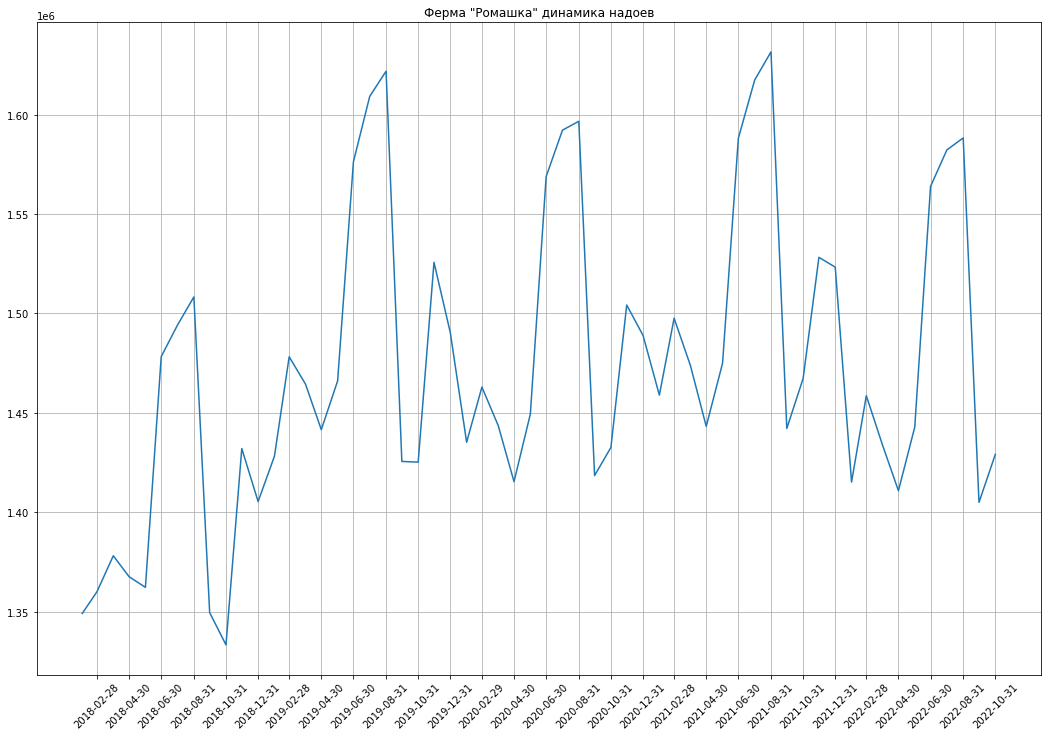

In [5]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot()
ax.plot(df_timeseries_romashka.MilkingAmount)
plt.xticks(df_timeseries_romashka.Date.values[1::2], rotation=45)
plt.grid(True)
plt.title('Ферма "Ромашка" динамика надоев');

Проанализируем тренд и сезонность:

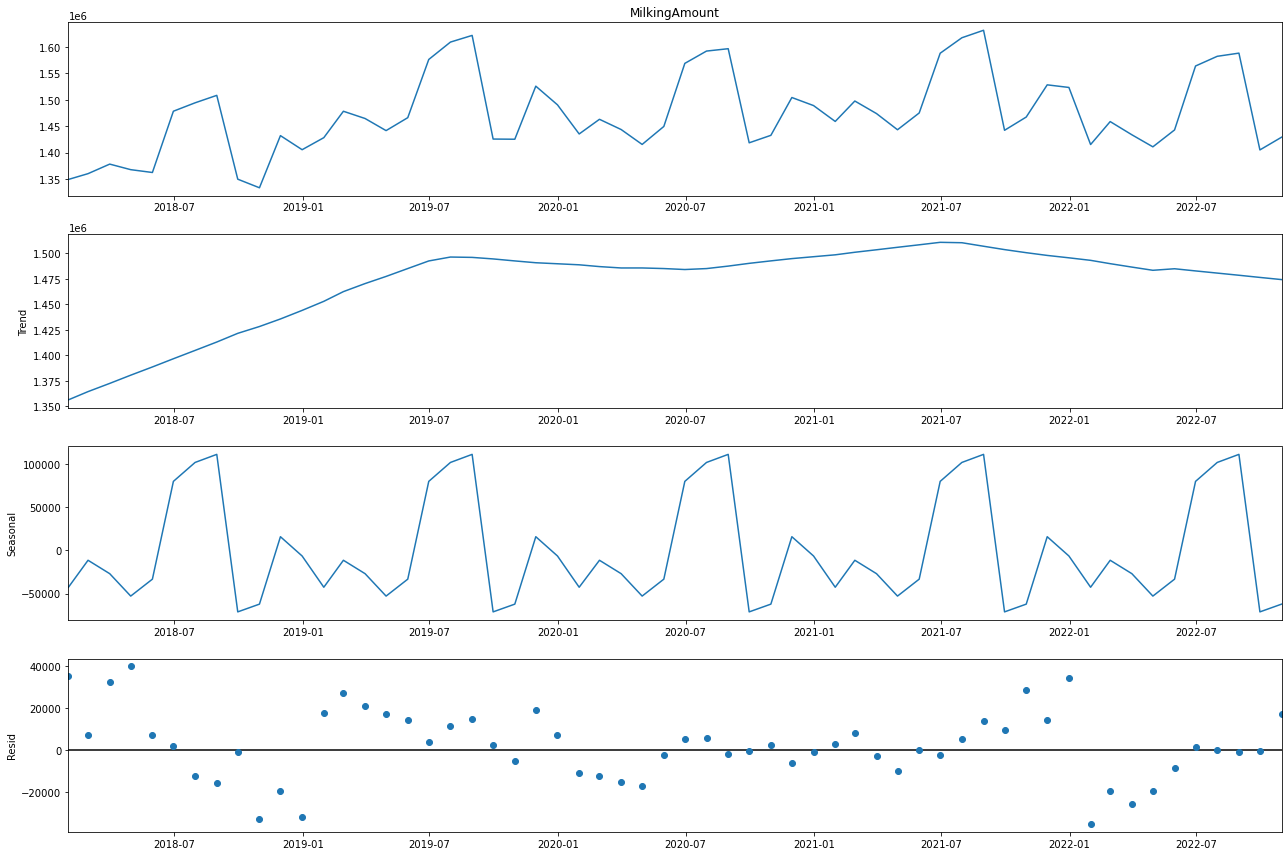

In [126]:
plt.rc('figure',figsize=(18,12))
decomposition = sm.tsa.seasonal_decompose(df_timeseries_romashka['MilkingAmount'], model='additive', extrapolate_trend='freq')
fig = decomposition.plot()
plt.show();

Из графиков наблюдается сезонность в 12 отсчетов ряда, а также то, что тренд имеет неравномерный характер, вероятнее всего, что ряд нестационарный, проведем тест Дики-Фуллера:

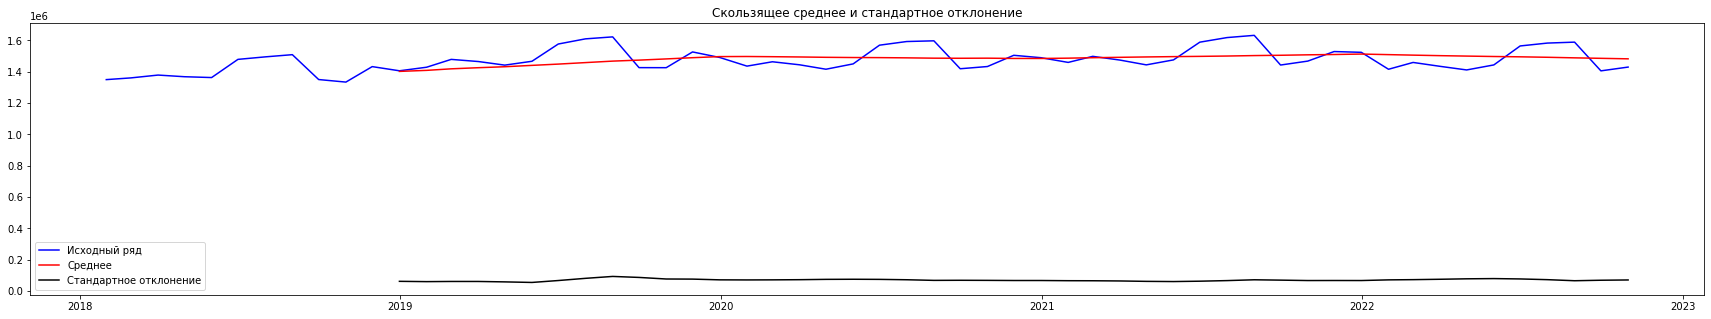

Результаты теста Дики-Фуллера:
p-value = 0.097104336. Временной ряд нестационарный.
Test Statistic                -2.580456
p-value                        0.097104
#Использовано лагов           12.000000
Наблюдений                    45.000000
Критическое значение (1%)     -3.584829
Критическое значение (5%)     -2.928299
Критическое значение (10%)    -2.602344
dtype: float64


In [127]:
window = 12
cutoff = 0.05
rolmean = df_timeseries_romashka.MilkingAmount.rolling(window).mean()
rolstd = df_timeseries_romashka.MilkingAmount.rolling(window).std()

fig = plt.figure(figsize=(30, 5))
orig = plt.plot(df_timeseries_romashka.MilkingAmount, color='blue',label='Исходный ряд')
mean = plt.plot(rolmean, color='red', label='Среднее')
std = plt.plot(rolstd, color='black', label = 'Стандартное отклонение')
plt.legend(loc='best')
plt.title('Скользящее среднее и стандартное отклонение')
plt.show()

print('Результаты теста Дики-Фуллера:')
dftest = adfuller(df_timeseries_romashka.MilkingAmount, autolag='AIC', maxlag = 12)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Использовано лагов','Наблюдений'])
for key,value in dftest[4].items():
    dfoutput['Критическое значение (%s)'%key] = value
pvalue = dftest[1]
if pvalue < cutoff:
    print('p-value = %.9f. Временной ряд стационарный.' % pvalue)
else:
    print('p-value = %.9f. Временной ряд нестационарный.' % pvalue)

print(dfoutput)

Предположение верно - ряд нестационарный, разбиваем ряд на тренировочный и тестовый - данные с 2018 по 2021 год будут тренировочными, за 2022 год - тестовыми:

In [129]:
df_timeseries_rom_train = df_timeseries_romashka.loc[(df_timeseries_romashka['Date'] >= '2018-01-01') & (df_timeseries_romashka['Date'] <= '2022-01-31')].copy()
df_timeseries_rom_test = df_timeseries_romashka.loc[(df_timeseries_romashka['Date'] > '2021-12-31') & (df_timeseries_romashka['Date'] <= '2022-10-31')].copy()

Подберем оптимальные параметры модели SARIMA для данного ряда:

In [130]:
auto_model = pm.auto_arima(df_timeseries_rom_train[:-1].MilkingAmount, test='adf',
                           start_p=0, start_q=0, 
                           max_p=9, max_q=9, max_P=9, max_Q=9, max_D=9,
                           start_P=0, 
                           D=1,
                           d=0, 
                           seasonal=True,
                           m=12,
                           trace=True, error_action='ignore', suppress_warnings=True, 
                           stepwise=True, 
                           random_state=97,
                           n_fits=50, 
                           freq='MS')

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=860.286, Time=0.03 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=878.103, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=830.378, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=852.390, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=896.058, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1008.640, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=821.317, Time=0.29 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=801.871, Time=0.80 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=803.871, Time=1.27 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=803.873, Time=0.71 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=805.873, Time=2.54 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=850.019, Time=0.16 sec
 ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=798.454, Time=0.81 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept  

Предскажем данные надоев по интервалу тестового набора данных и оценим качество модели:

In [48]:
results_AutoARIMA_rom = pd.DataFrame(auto_model.predict(n_periods=len(df_timeseries_rom_test)), index=df_timeseries_rom_test.index)

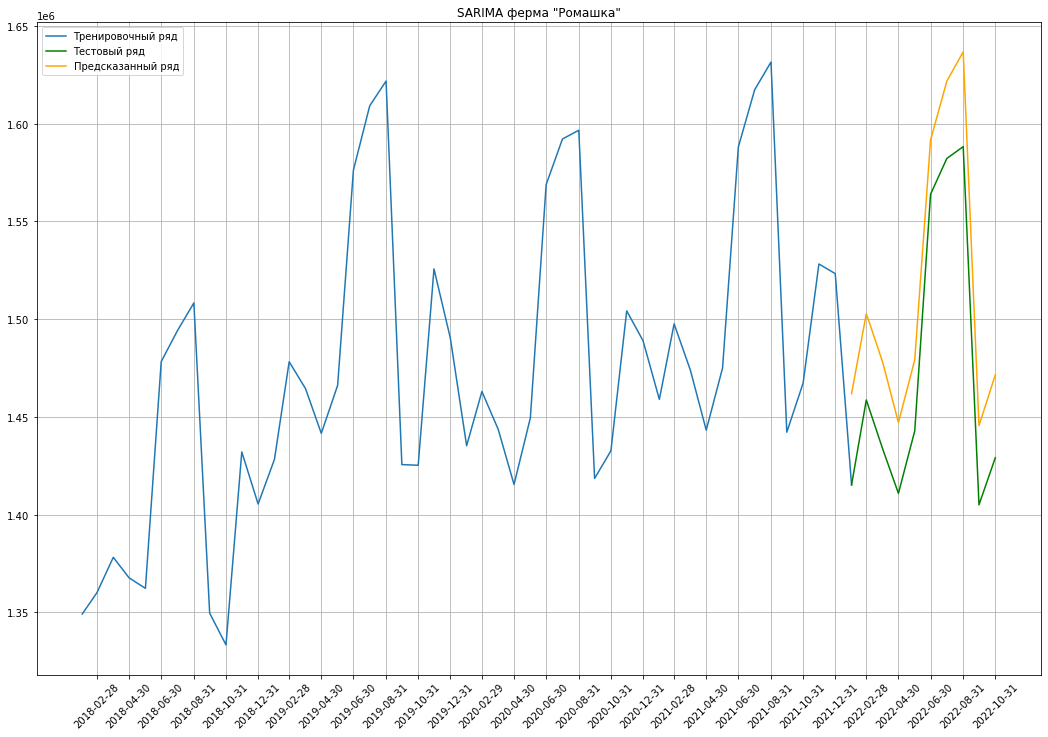

In [193]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot()
ax.plot(df_timeseries_rom_train.MilkingAmount, label='Тренировочный ряд')
ax.plot(df_timeseries_rom_test.MilkingAmount, color='green', label='Тестовый ряд')
ax.plot(results_AutoARIMA_rom, color='orange', label='Предсказанный ряд')
plt.legend(loc='upper left')
plt.title('SARIMA ферма "Ромашка"')
plt.xticks(np.append(df_timeseries_rom_train.Date.values[1::2], df_timeseries_rom_test.Date.values[1::2]), rotation=45)
plt.grid(True)
plt.show()

In [132]:
error_metrics(df_timeseries_rom_test.MilkingAmount, results_AutoARIMA_rom)

	MAE: 40668.712785485244
	MSE: 1687351556.0721812
	RMSE: 41077.38497120017
	R2: 0.6619907076257749


Качество модели SARIMA оказалось хуже, чем для фермы "Вереск", попробуем также методы XGBRegressor и CatBoostRegressor и сравним качество, добавим дополнительные признаки исходя из дат:  

In [204]:
df_timeseries_romashka['Year'] = df_timeseries_romashka['Date'].dt.year
df_timeseries_romashka['Quarter'] = df_timeseries_romashka['Date'].dt.quarter
df_timeseries_romashka['Month'] = df_timeseries_romashka['Date'].dt.month
df_timeseries_romashka['Weekofyear'] = df_timeseries_romashka['Date'].dt.isocalendar().week
df_timeseries_romashka['Dayofyear'] = df_timeseries_romashka['Date'].dt.dayofyear
df_timeseries_romashka['Dayofweek'] = df_timeseries_romashka['Date'].dt.dayofweek
df_timeseries_romashka = df_timeseries_romashka.astype({'Weekofyear': int})

In [205]:
X = df_timeseries_romashka.drop(columns=['MilkingAmount', 'Date'], axis=1)
y = df_timeseries_romashka['MilkingAmount']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=97)

Построим базовую модель XGBRegressor и оценим качество:

In [207]:
xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [208]:
error_metrics(y_test, y_pred)

	MAE: 19135.620800722198
	MSE: 461747499.88122064
	RMSE: 21488.31077309756
	R2: 0.9221686560805186


Попробуем определить наиболее значимые признаки:

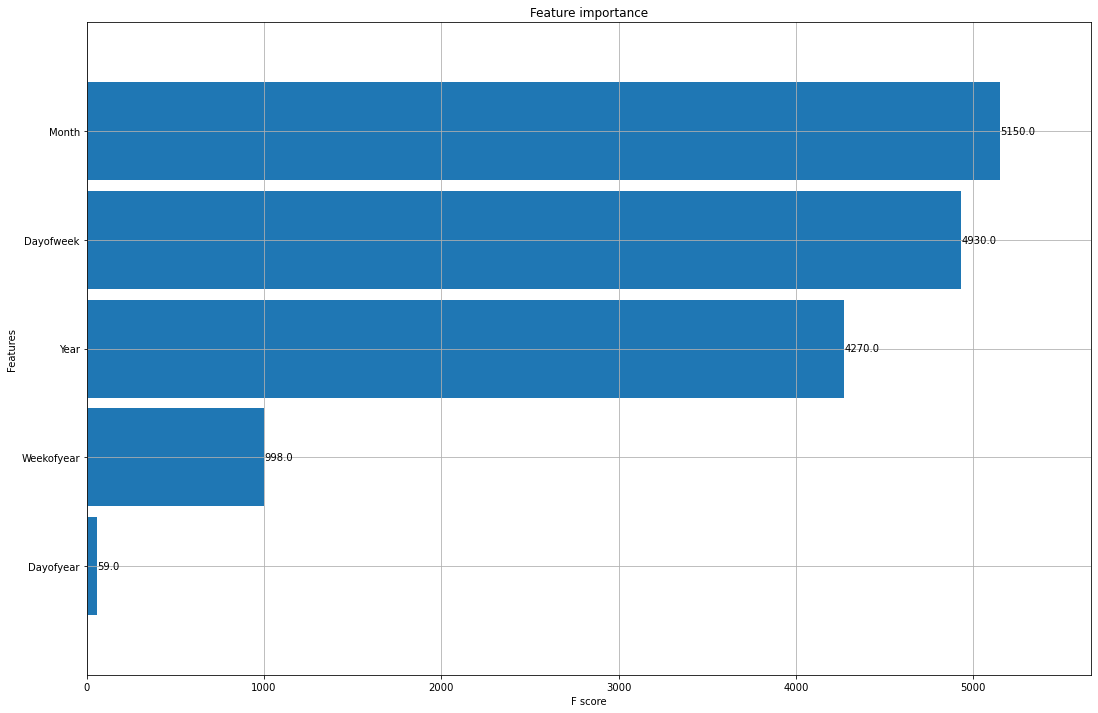

In [209]:
plot_importance(xgb_model, height=0.9);

Убираем незначащие признаки и оценим качество модели:

In [140]:
df_timeseries_romashka.drop(columns=['Weekofyear', 'Quarter', 'Dayofyear'], axis=1, inplace=True) 
X = df_timeseries_romashka.drop(columns=['MilkingAmount', 'Date'], axis=1)
y = df_timeseries_romashka['MilkingAmount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=97)

In [141]:
xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [142]:
error_metrics(y_test, y_pred)

	MAE: 16371.287467388864
	MSE: 326491629.7083519
	RMSE: 18069.079381870895
	R2: 0.9449671469251063


Качество модели подросло, попробуем тюнинг гиперпараметров:

In [143]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

SCORE:                                                                                                                 
1.3464758205874476                                                                                                     
SCORE:                                                                                                                 
3.411883291109323                                                                                                      
SCORE:                                                                                                                 
3.6233595147377393                                                                                                     
SCORE:                                                                                                                 
3.7377672612083788                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.8439450345724452                                                                                                     
SCORE:                                                                                                                 
0.8660210602824643                                                                                                     
SCORE:                                                                                                                 
0.839978660420752                                                                                                      
SCORE:                                                                                                                 
0.8509407339693539                                                                                                     
SCORE:                                  

In [144]:
print(best)

{'colsample_bytree': 0.5853922556448837, 'gamma': 3.062537582429494, 'max_depth': 9.0, 'min_child_weight': 0.0, 'n_estimators': 543.9196198332654, 'reg_alpha': 0.9985044083795549, 'reg_lambda': 0.05514224787906416, 'subsample': 0.7000000000000001}


In [145]:
best['max_depth'] = int(best['max_depth'])
best['n_estimators'] = int(best['n_estimators'])

In [158]:
xgb_model_opt = xgb.XGBRegressor(**best)
xgb_model_opt.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [159]:
error_metrics(y_test, y_pred)

	MAE: 16371.287467388864
	MSE: 326491629.7083519
	RMSE: 18069.079381870895
	R2: 0.9449671469251063


Качество модели XGBRegressor оказалось выше, чем у SARIMA, проанализируем CatBoostRegressor:

In [148]:
cat = CatBoostRegressor()
cat.fit(X_train, y_train, verbose=True, plot=True)
y_pred = cat.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.024621
0:	learn: 73053.6613317	total: 530us	remaining: 530ms
1:	learn: 72396.5242961	total: 1.05ms	remaining: 522ms
2:	learn: 71902.6485272	total: 1.71ms	remaining: 567ms
3:	learn: 71049.2576308	total: 2.23ms	remaining: 556ms
4:	learn: 70456.9199070	total: 2.81ms	remaining: 560ms
5:	learn: 70075.0072873	total: 3.36ms	remaining: 556ms
6:	learn: 69702.4808674	total: 3.81ms	remaining: 540ms
7:	learn: 68867.3217198	total: 4.29ms	remaining: 532ms
8:	learn: 68171.4412016	total: 4.91ms	remaining: 540ms
9:	learn: 67724.0548925	total: 5.49ms	remaining: 543ms
10:	learn: 67378.3172726	total: 5.91ms	remaining: 531ms
11:	learn: 66815.3651876	total: 6.3ms	remaining: 519ms
12:	learn: 66135.6460056	total: 6.79ms	remaining: 516ms
13:	learn: 65785.9889869	total: 7.29ms	remaining: 513ms
14:	learn: 65343.4345004	total: 7.78ms	remaining: 511ms
15:	learn: 64750.9815680	total: 8.31ms	remaining: 511ms
16:	learn: 64257.3929515	total: 8.87ms	remaining: 513ms
17:	learn: 63751.6347148	total

258:	learn: 12791.6810603	total: 132ms	remaining: 377ms
259:	learn: 12733.9199784	total: 132ms	remaining: 377ms
260:	learn: 12606.4009426	total: 133ms	remaining: 376ms
261:	learn: 12550.0514579	total: 133ms	remaining: 375ms
262:	learn: 12425.5893366	total: 134ms	remaining: 375ms
263:	learn: 12365.1674111	total: 134ms	remaining: 374ms
264:	learn: 12310.7099876	total: 135ms	remaining: 374ms
265:	learn: 12226.2965236	total: 135ms	remaining: 373ms
266:	learn: 12107.1460779	total: 136ms	remaining: 372ms
267:	learn: 12061.5925136	total: 136ms	remaining: 372ms
268:	learn: 11987.8688149	total: 136ms	remaining: 371ms
269:	learn: 11934.0084903	total: 137ms	remaining: 370ms
270:	learn: 11877.3250076	total: 137ms	remaining: 369ms
271:	learn: 11824.2007338	total: 138ms	remaining: 369ms
272:	learn: 11771.0387941	total: 138ms	remaining: 368ms
273:	learn: 11686.4829354	total: 139ms	remaining: 367ms
274:	learn: 11575.0085138	total: 139ms	remaining: 366ms
275:	learn: 11472.9329657	total: 139ms	remaining

578:	learn: 2869.3022516	total: 269ms	remaining: 196ms
579:	learn: 2862.2823173	total: 270ms	remaining: 195ms
580:	learn: 2855.3498336	total: 270ms	remaining: 195ms
581:	learn: 2848.5035548	total: 271ms	remaining: 195ms
582:	learn: 2841.7422581	total: 271ms	remaining: 194ms
583:	learn: 2835.0647430	total: 272ms	remaining: 194ms
584:	learn: 2828.4698310	total: 272ms	remaining: 193ms
585:	learn: 2821.9563648	total: 273ms	remaining: 193ms
586:	learn: 2815.5232079	total: 273ms	remaining: 192ms
587:	learn: 2806.9163539	total: 274ms	remaining: 192ms
588:	learn: 2796.7324990	total: 274ms	remaining: 191ms
589:	learn: 2790.4258670	total: 274ms	remaining: 191ms
590:	learn: 2784.1969131	total: 275ms	remaining: 190ms
591:	learn: 2778.0445624	total: 275ms	remaining: 190ms
592:	learn: 2771.9677589	total: 276ms	remaining: 189ms
593:	learn: 2765.9654656	total: 276ms	remaining: 189ms
594:	learn: 2760.0366632	total: 276ms	remaining: 188ms
595:	learn: 2754.1803505	total: 277ms	remaining: 188ms
596:	learn

910:	learn: 1172.6430298	total: 409ms	remaining: 39.9ms
911:	learn: 1169.9157737	total: 409ms	remaining: 39.5ms
912:	learn: 1167.7128287	total: 410ms	remaining: 39ms
913:	learn: 1165.7249110	total: 410ms	remaining: 38.6ms
914:	learn: 1160.0451067	total: 411ms	remaining: 38.1ms
915:	learn: 1157.5746389	total: 411ms	remaining: 37.7ms
916:	learn: 1154.9165481	total: 411ms	remaining: 37.2ms
917:	learn: 1152.4900440	total: 412ms	remaining: 36.8ms
918:	learn: 1149.8847995	total: 412ms	remaining: 36.3ms
919:	learn: 1147.0353490	total: 413ms	remaining: 35.9ms
920:	learn: 1144.9288241	total: 413ms	remaining: 35.4ms
921:	learn: 1142.5391524	total: 414ms	remaining: 35ms
922:	learn: 1139.9982747	total: 414ms	remaining: 34.5ms
923:	learn: 1137.2119777	total: 414ms	remaining: 34.1ms
924:	learn: 1135.3313535	total: 415ms	remaining: 33.6ms
925:	learn: 1132.9806555	total: 415ms	remaining: 33.2ms
926:	learn: 1130.6741671	total: 416ms	remaining: 32.7ms
927:	learn: 1128.1960980	total: 416ms	remaining: 32.

In [149]:
error_metrics(y_test, y_pred)

	MAE: 26050.75504724199
	MSE: 1083258302.5554552
	RMSE: 32912.88961114559
	R2: 0.8174078917124283


Проведем тюнинг гиперпараметров:

In [150]:
cat = CatBoostRegressor()
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1454703.1624198	test: 1435161.8202647	best: 1435161.8202647 (0)	total: 352us	remaining: 352ms
1:	learn: 1418779.9911964	test: 1411064.9034381	best: 1411064.9034381 (1)	total: 848us	remaining: 423ms
2:	learn: 1387328.0664894	test: 1382961.1083720	best: 1382961.1083720 (2)	total: 1.23ms	remaining: 407ms
3:	learn: 1352568.7867269	test: 1347754.0196946	best: 1347754.0196946 (3)	total: 1.66ms	remaining: 412ms
4:	learn: 1317156.5499592	test: 1316806.7203657	best: 1316806.7203657 (4)	total: 2.02ms	remaining: 401ms
5:	learn: 1285779.9389376	test: 1285494.1753078	best: 1285494.1753078 (5)	total: 2.38ms	remaining: 395ms
6:	learn: 1250635.7145348	test: 1250157.2231359	best: 1250157.2231359 (6)	total: 2.74ms	remaining: 388ms
7:	learn: 1222499.1075586	test: 1221240.6228365	best: 1221240.6228365 (7)	total: 3.14ms	remaining: 389ms
8:	learn: 1193437.8897255	test: 1196512.4455324	best: 1196512.4455324 (8)	total: 3.54ms	remaining: 390ms
9:	learn: 1163295.4784314	test: 1165812.0684500	best: 116

414:	learn: 6521.2396634	test: 137858.4280409	best: 137858.4280409 (414)	total: 158ms	remaining: 223ms
415:	learn: 6493.6705228	test: 137900.6653550	best: 137858.4280409 (414)	total: 159ms	remaining: 223ms
416:	learn: 6472.5188774	test: 137885.6564816	best: 137858.4280409 (414)	total: 159ms	remaining: 222ms
417:	learn: 6446.4534379	test: 137852.5529079	best: 137852.5529079 (417)	total: 159ms	remaining: 222ms
418:	learn: 6414.5490554	test: 137834.8411183	best: 137834.8411183 (418)	total: 160ms	remaining: 221ms
419:	learn: 6390.4157547	test: 137812.9944297	best: 137812.9944297 (419)	total: 160ms	remaining: 221ms
420:	learn: 6362.9777839	test: 137816.3128786	best: 137812.9944297 (419)	total: 160ms	remaining: 221ms
421:	learn: 6332.0533365	test: 137799.2290321	best: 137799.2290321 (421)	total: 161ms	remaining: 220ms
422:	learn: 6299.9396945	test: 137794.7703449	best: 137794.7703449 (422)	total: 161ms	remaining: 220ms
423:	learn: 6276.5310463	test: 137773.9262833	best: 137773.9262833 (423)	

886:	learn: 1159.3616121	test: 137079.9907024	best: 136688.8129996 (593)	total: 317ms	remaining: 40.4ms
887:	learn: 1151.9010463	test: 137092.5371916	best: 136688.8129996 (593)	total: 317ms	remaining: 40ms
888:	learn: 1146.0482333	test: 137094.4024824	best: 136688.8129996 (593)	total: 317ms	remaining: 39.6ms
889:	learn: 1144.9200796	test: 137089.6939394	best: 136688.8129996 (593)	total: 318ms	remaining: 39.3ms
890:	learn: 1143.5744568	test: 137087.9415320	best: 136688.8129996 (593)	total: 318ms	remaining: 38.9ms
891:	learn: 1130.7240326	test: 137091.0295482	best: 136688.8129996 (593)	total: 318ms	remaining: 38.5ms
892:	learn: 1124.0005546	test: 137099.8281653	best: 136688.8129996 (593)	total: 318ms	remaining: 38.1ms
893:	learn: 1119.4693506	test: 137103.7243451	best: 136688.8129996 (593)	total: 318ms	remaining: 37.8ms
894:	learn: 1114.4205254	test: 137101.7773697	best: 136688.8129996 (593)	total: 319ms	remaining: 37.4ms
895:	learn: 1104.5447191	test: 137109.0511324	best: 136688.8129996

327:	learn: 756.5572406	test: 151137.0453283	best: 150884.8881352 (196)	total: 111ms	remaining: 227ms
328:	learn: 749.1090185	test: 151136.9131273	best: 150884.8881352 (196)	total: 111ms	remaining: 227ms
329:	learn: 745.8715899	test: 151134.4898830	best: 150884.8881352 (196)	total: 112ms	remaining: 227ms
330:	learn: 744.0055147	test: 151130.6505535	best: 150884.8881352 (196)	total: 112ms	remaining: 226ms
331:	learn: 726.3709272	test: 151141.5591058	best: 150884.8881352 (196)	total: 112ms	remaining: 226ms
332:	learn: 724.4357184	test: 151136.8392547	best: 150884.8881352 (196)	total: 113ms	remaining: 226ms
333:	learn: 722.7926038	test: 151132.4110464	best: 150884.8881352 (196)	total: 113ms	remaining: 226ms
334:	learn: 702.5479750	test: 151136.3963920	best: 150884.8881352 (196)	total: 114ms	remaining: 226ms
335:	learn: 699.3006871	test: 151141.6369988	best: 150884.8881352 (196)	total: 114ms	remaining: 226ms
336:	learn: 683.6385276	test: 151166.9009720	best: 150884.8881352 (196)	total: 115

772:	learn: 4.8856877	test: 151209.3802963	best: 150884.8881352 (196)	total: 266ms	remaining: 78.2ms
773:	learn: 4.8260980	test: 151209.4309015	best: 150884.8881352 (196)	total: 267ms	remaining: 77.9ms
774:	learn: 4.8091410	test: 151209.4117958	best: 150884.8881352 (196)	total: 267ms	remaining: 77.5ms
775:	learn: 4.7802426	test: 151209.4151562	best: 150884.8881352 (196)	total: 267ms	remaining: 77.2ms
776:	learn: 4.7651778	test: 151209.3972534	best: 150884.8881352 (196)	total: 268ms	remaining: 76.8ms
777:	learn: 4.7140523	test: 151209.4439549	best: 150884.8881352 (196)	total: 268ms	remaining: 76.5ms
778:	learn: 4.6438780	test: 151209.5399366	best: 150884.8881352 (196)	total: 268ms	remaining: 76.1ms
779:	learn: 4.6263240	test: 151209.5693472	best: 150884.8881352 (196)	total: 269ms	remaining: 75.8ms
780:	learn: 4.6001322	test: 151209.5730018	best: 150884.8881352 (196)	total: 269ms	remaining: 75.4ms
781:	learn: 4.5823029	test: 151209.6047131	best: 150884.8881352 (196)	total: 269ms	remainin

233:	learn: 48390.5541708	test: 171528.6990118	best: 171528.6990118 (233)	total: 75.7ms	remaining: 248ms
234:	learn: 48114.9039252	test: 171150.7326238	best: 171150.7326238 (234)	total: 76.2ms	remaining: 248ms
235:	learn: 47806.8985099	test: 171016.7023795	best: 171016.7023795 (235)	total: 76.5ms	remaining: 248ms
236:	learn: 47439.0545706	test: 170774.8502079	best: 170774.8502079 (236)	total: 76.8ms	remaining: 247ms
237:	learn: 47010.5275114	test: 170236.2279202	best: 170236.2279202 (237)	total: 77.2ms	remaining: 247ms
238:	learn: 46747.1225671	test: 169875.6222728	best: 169875.6222728 (238)	total: 77.5ms	remaining: 247ms
239:	learn: 46392.0406963	test: 169645.4615405	best: 169645.4615405 (239)	total: 77.8ms	remaining: 247ms
240:	learn: 46136.1847466	test: 169291.7788036	best: 169291.7788036 (240)	total: 78.2ms	remaining: 246ms
241:	learn: 45726.2853267	test: 168776.7266942	best: 168776.7266942 (241)	total: 78.5ms	remaining: 246ms
242:	learn: 45419.1151156	test: 168334.5261489	best: 16

664:	learn: 8515.3026155	test: 133695.0703048	best: 133695.0703048 (664)	total: 232ms	remaining: 117ms
665:	learn: 8492.5297934	test: 133663.7208998	best: 133663.7208998 (665)	total: 233ms	remaining: 117ms
666:	learn: 8460.4185059	test: 133651.1494576	best: 133651.1494576 (666)	total: 233ms	remaining: 116ms
667:	learn: 8442.8290827	test: 133636.2704715	best: 133636.2704715 (667)	total: 234ms	remaining: 116ms
668:	learn: 8425.3775900	test: 133629.8415790	best: 133629.8415790 (668)	total: 234ms	remaining: 116ms
669:	learn: 8393.8162799	test: 133617.6265008	best: 133617.6265008 (669)	total: 234ms	remaining: 115ms
670:	learn: 8373.5804727	test: 133592.8772135	best: 133592.8772135 (670)	total: 235ms	remaining: 115ms
671:	learn: 8337.8464992	test: 133581.2381321	best: 133581.2381321 (671)	total: 235ms	remaining: 115ms
672:	learn: 8314.7844709	test: 133563.3367470	best: 133563.3367470 (672)	total: 235ms	remaining: 114ms
673:	learn: 8300.0125376	test: 133552.5117493	best: 133552.5117493 (673)	

102:	learn: 27144.5306709	test: 182773.0197251	best: 182773.0197251 (102)	total: 35.6ms	remaining: 310ms
103:	learn: 26752.2238289	test: 182217.5346012	best: 182217.5346012 (103)	total: 36ms	remaining: 310ms
104:	learn: 26364.2272285	test: 181976.2244934	best: 181976.2244934 (104)	total: 36.3ms	remaining: 310ms
105:	learn: 25962.5679031	test: 181608.4166068	best: 181608.4166068 (105)	total: 36.7ms	remaining: 309ms
106:	learn: 25684.1754611	test: 181439.8612043	best: 181439.8612043 (106)	total: 37ms	remaining: 309ms
107:	learn: 25322.5003171	test: 181088.5774737	best: 181088.5774737 (107)	total: 37.4ms	remaining: 309ms
108:	learn: 24924.8978731	test: 180383.8978481	best: 180383.8978481 (108)	total: 37.8ms	remaining: 309ms
109:	learn: 24664.7312302	test: 180231.5626070	best: 180231.5626070 (109)	total: 38.1ms	remaining: 309ms
110:	learn: 24242.7292272	test: 180025.3038193	best: 180025.3038193 (110)	total: 38.6ms	remaining: 309ms
111:	learn: 23876.2075990	test: 179541.5404321	best: 179541

528:	learn: 1155.7560078	test: 163667.8005611	best: 163357.9911206 (315)	total: 193ms	remaining: 172ms
529:	learn: 1151.7526513	test: 163665.8829986	best: 163357.9911206 (315)	total: 194ms	remaining: 172ms
530:	learn: 1146.2950567	test: 163671.9287259	best: 163357.9911206 (315)	total: 194ms	remaining: 171ms
531:	learn: 1124.0057365	test: 163678.9754506	best: 163357.9911206 (315)	total: 194ms	remaining: 171ms
532:	learn: 1119.9739221	test: 163685.4749749	best: 163357.9911206 (315)	total: 195ms	remaining: 171ms
533:	learn: 1118.1432939	test: 163684.7605534	best: 163357.9911206 (315)	total: 195ms	remaining: 170ms
534:	learn: 1097.4543324	test: 163695.2177013	best: 163357.9911206 (315)	total: 195ms	remaining: 170ms
535:	learn: 1091.2230050	test: 163701.1343179	best: 163357.9911206 (315)	total: 196ms	remaining: 169ms
536:	learn: 1089.4907864	test: 163700.3727530	best: 163357.9911206 (315)	total: 196ms	remaining: 169ms
537:	learn: 1087.8858620	test: 163699.6312916	best: 163357.9911206 (315)	

991:	learn: 64.2659387	test: 163659.5189916	best: 163357.9911206 (315)	total: 351ms	remaining: 2.83ms
992:	learn: 63.3161512	test: 163659.7126725	best: 163357.9911206 (315)	total: 352ms	remaining: 2.48ms
993:	learn: 62.8684593	test: 163659.7691730	best: 163357.9911206 (315)	total: 352ms	remaining: 2.13ms
994:	learn: 62.2838355	test: 163659.8998387	best: 163357.9911206 (315)	total: 352ms	remaining: 1.77ms
995:	learn: 61.4889743	test: 163660.2146349	best: 163357.9911206 (315)	total: 353ms	remaining: 1.42ms
996:	learn: 61.3345305	test: 163660.2108883	best: 163357.9911206 (315)	total: 353ms	remaining: 1.06ms
997:	learn: 61.2003492	test: 163659.9890793	best: 163357.9911206 (315)	total: 353ms	remaining: 708us
998:	learn: 60.7296068	test: 163659.8692623	best: 163357.9911206 (315)	total: 354ms	remaining: 354us
999:	learn: 60.6402472	test: 163659.9242154	best: 163357.9911206 (315)	total: 354ms	remaining: 0us

bestTest = 163357.9911
bestIteration = 315

3:	loss: 163357.9911206	best: 131315.22090

436:	learn: 26272.5796135	test: 132242.7024414	best: 132242.7024414 (436)	total: 152ms	remaining: 196ms
437:	learn: 26147.7607793	test: 132093.7341645	best: 132093.7341645 (437)	total: 153ms	remaining: 196ms
438:	learn: 26072.1570570	test: 132068.8116286	best: 132068.8116286 (438)	total: 153ms	remaining: 196ms
439:	learn: 25971.3863873	test: 132009.1731143	best: 132009.1731143 (439)	total: 153ms	remaining: 195ms
440:	learn: 25827.8687835	test: 131886.0945191	best: 131886.0945191 (440)	total: 154ms	remaining: 195ms
441:	learn: 25754.2262652	test: 131861.7291257	best: 131861.7291257 (441)	total: 154ms	remaining: 195ms
442:	learn: 25641.7388204	test: 131704.6826606	best: 131704.6826606 (442)	total: 155ms	remaining: 194ms
443:	learn: 25501.5698557	test: 131584.2495406	best: 131584.2495406 (443)	total: 155ms	remaining: 194ms
444:	learn: 25383.2083114	test: 131442.3974293	best: 131442.3974293 (444)	total: 155ms	remaining: 194ms
445:	learn: 25286.5791704	test: 131385.7175092	best: 131385.7175

873:	learn: 8216.6686492	test: 117531.2334719	best: 117531.2334719 (873)	total: 308ms	remaining: 44.4ms
874:	learn: 8197.6078208	test: 117509.9395418	best: 117509.9395418 (874)	total: 308ms	remaining: 44.1ms
875:	learn: 8183.1130923	test: 117490.5679954	best: 117490.5679954 (875)	total: 309ms	remaining: 43.7ms
876:	learn: 8165.2612013	test: 117475.6060474	best: 117475.6060474 (876)	total: 309ms	remaining: 43.4ms
877:	learn: 8155.5775230	test: 117458.1644051	best: 117458.1644051 (877)	total: 310ms	remaining: 43ms
878:	learn: 8140.6664004	test: 117453.5283454	best: 117453.5283454 (878)	total: 310ms	remaining: 42.7ms
879:	learn: 8126.4286090	test: 117434.3810140	best: 117434.3810140 (879)	total: 310ms	remaining: 42.3ms
880:	learn: 8108.8772299	test: 117419.6516336	best: 117419.6516336 (880)	total: 311ms	remaining: 42ms
881:	learn: 8099.3742177	test: 117402.3853464	best: 117402.3853464 (881)	total: 311ms	remaining: 41.6ms
882:	learn: 8089.1236659	test: 117372.6097080	best: 117372.6097080 (

288:	learn: 7053.1842978	test: 161009.0536846	best: 160966.7654107 (286)	total: 103ms	remaining: 253ms
289:	learn: 7022.6315637	test: 160987.3118221	best: 160966.7654107 (286)	total: 104ms	remaining: 253ms
290:	learn: 6993.1801668	test: 160966.1924173	best: 160966.1924173 (290)	total: 104ms	remaining: 253ms
291:	learn: 6922.5417417	test: 160889.6698750	best: 160889.6698750 (291)	total: 104ms	remaining: 253ms
292:	learn: 6881.4972009	test: 160839.8950545	best: 160839.8950545 (292)	total: 105ms	remaining: 253ms
293:	learn: 6819.2506608	test: 160816.1313529	best: 160816.1313529 (293)	total: 105ms	remaining: 253ms
294:	learn: 6780.1896358	test: 160767.8098806	best: 160767.8098806 (294)	total: 106ms	remaining: 252ms
295:	learn: 6696.1242406	test: 160793.8015015	best: 160767.8098806 (294)	total: 106ms	remaining: 252ms
296:	learn: 6636.5483774	test: 160772.7841839	best: 160767.8098806 (294)	total: 106ms	remaining: 252ms
297:	learn: 6600.2088651	test: 160726.8596521	best: 160726.8596521 (297)	

711:	learn: 583.4783650	test: 158055.9392928	best: 158010.5060562 (661)	total: 260ms	remaining: 105ms
712:	learn: 580.9847821	test: 158057.7816268	best: 158010.5060562 (661)	total: 260ms	remaining: 105ms
713:	learn: 577.2365640	test: 158057.0853577	best: 158010.5060562 (661)	total: 261ms	remaining: 104ms
714:	learn: 572.7483283	test: 158058.7456412	best: 158010.5060562 (661)	total: 261ms	remaining: 104ms
715:	learn: 569.9272691	test: 158058.4744562	best: 158010.5060562 (661)	total: 261ms	remaining: 104ms
716:	learn: 566.9178810	test: 158056.8439115	best: 158010.5060562 (661)	total: 262ms	remaining: 103ms
717:	learn: 563.9425730	test: 158057.5465976	best: 158010.5060562 (661)	total: 262ms	remaining: 103ms
718:	learn: 559.6127412	test: 158059.0850608	best: 158010.5060562 (661)	total: 263ms	remaining: 103ms
719:	learn: 555.3857987	test: 158060.6469106	best: 158010.5060562 (661)	total: 263ms	remaining: 102ms
720:	learn: 551.3265165	test: 158062.0274466	best: 158010.5060562 (661)	total: 263

147:	learn: 190835.9078125	test: 285047.9533613	best: 285047.9533613 (147)	total: 51.5ms	remaining: 296ms
148:	learn: 188332.1893089	test: 282978.4764286	best: 282978.4764286 (148)	total: 51.9ms	remaining: 297ms
149:	learn: 186558.2859397	test: 282066.2835901	best: 282066.2835901 (149)	total: 52.3ms	remaining: 296ms
150:	learn: 183800.1779714	test: 279713.2454213	best: 279713.2454213 (150)	total: 52.6ms	remaining: 296ms
151:	learn: 181413.5200000	test: 278008.1934905	best: 278008.1934905 (151)	total: 52.9ms	remaining: 295ms
152:	learn: 179229.4563290	test: 275887.7342679	best: 275887.7342679 (152)	total: 53.2ms	remaining: 295ms
153:	learn: 177052.2295774	test: 274431.0046634	best: 274431.0046634 (153)	total: 53.6ms	remaining: 294ms
154:	learn: 175730.3131299	test: 273259.5531370	best: 273259.5531370 (154)	total: 54ms	remaining: 294ms
155:	learn: 173362.0798134	test: 271052.7407345	best: 271052.7407345 (155)	total: 54.3ms	remaining: 294ms
156:	learn: 171300.0774626	test: 269203.8809256	

583:	learn: 23252.5921417	test: 136002.2250839	best: 136002.2250839 (583)	total: 201ms	remaining: 143ms
584:	learn: 23162.0253868	test: 135921.4088520	best: 135921.4088520 (584)	total: 201ms	remaining: 143ms
585:	learn: 23080.4134889	test: 135816.1369604	best: 135816.1369604 (585)	total: 201ms	remaining: 142ms
586:	learn: 23017.2707473	test: 135781.8645746	best: 135781.8645746 (586)	total: 202ms	remaining: 142ms
587:	learn: 22968.5092842	test: 135769.8476745	best: 135769.8476745 (587)	total: 202ms	remaining: 142ms
588:	learn: 22880.0240935	test: 135690.5707251	best: 135690.5707251 (588)	total: 203ms	remaining: 141ms
589:	learn: 22818.1573707	test: 135656.8685264	best: 135656.8685264 (589)	total: 203ms	remaining: 141ms
590:	learn: 22756.9416840	test: 135623.4725057	best: 135623.4725057 (590)	total: 203ms	remaining: 141ms
591:	learn: 22670.8236081	test: 135545.8023694	best: 135545.8023694 (591)	total: 204ms	remaining: 140ms
592:	learn: 22610.6630053	test: 135512.8772604	best: 135512.8772

54:	learn: 137239.0819216	test: 228187.7927721	best: 228187.7927721 (54)	total: 18.4ms	remaining: 315ms
55:	learn: 133088.9339378	test: 224919.3530223	best: 224919.3530223 (55)	total: 18.8ms	remaining: 317ms
56:	learn: 129482.4976984	test: 221603.5853945	best: 221603.5853945 (56)	total: 19.1ms	remaining: 316ms
57:	learn: 126262.0756415	test: 219583.6947574	best: 219583.6947574 (57)	total: 19.5ms	remaining: 316ms
58:	learn: 122783.2043588	test: 216769.9274073	best: 216769.9274073 (58)	total: 19.8ms	remaining: 316ms
59:	learn: 119239.0176766	test: 215782.0848296	best: 215782.0848296 (59)	total: 20.1ms	remaining: 315ms
60:	learn: 116150.5038837	test: 214140.3967460	best: 214140.3967460 (60)	total: 20.5ms	remaining: 315ms
61:	learn: 112768.8717533	test: 211083.5865300	best: 211083.5865300 (61)	total: 20.9ms	remaining: 317ms
62:	learn: 109653.9291906	test: 210286.4757392	best: 210286.4757392 (62)	total: 21.3ms	remaining: 317ms
63:	learn: 106803.7362905	test: 207677.0736574	best: 207677.0736

529:	learn: 2636.9573860	test: 152986.7177062	best: 149093.7398025 (223)	total: 177ms	remaining: 157ms
530:	learn: 2615.9597343	test: 152993.9583829	best: 149093.7398025 (223)	total: 178ms	remaining: 157ms
531:	learn: 2608.5530631	test: 153001.6693768	best: 149093.7398025 (223)	total: 178ms	remaining: 157ms
532:	learn: 2595.3231222	test: 153021.8391313	best: 149093.7398025 (223)	total: 179ms	remaining: 157ms
533:	learn: 2588.1408601	test: 153029.2812717	best: 149093.7398025 (223)	total: 179ms	remaining: 156ms
534:	learn: 2579.7738249	test: 153036.0238132	best: 149093.7398025 (223)	total: 180ms	remaining: 156ms
535:	learn: 2573.0022172	test: 153036.9076478	best: 149093.7398025 (223)	total: 180ms	remaining: 156ms
536:	learn: 2564.3380733	test: 153030.9623392	best: 149093.7398025 (223)	total: 181ms	remaining: 156ms
537:	learn: 2554.3310520	test: 153030.8378364	best: 149093.7398025 (223)	total: 181ms	remaining: 156ms
538:	learn: 2546.1288641	test: 153016.1280752	best: 149093.7398025 (223)	

997:	learn: 347.5297112	test: 153322.5845077	best: 149093.7398025 (223)	total: 334ms	remaining: 669us
998:	learn: 346.3198626	test: 153320.7504267	best: 149093.7398025 (223)	total: 334ms	remaining: 334us
999:	learn: 345.0509281	test: 153318.5720652	best: 149093.7398025 (223)	total: 335ms	remaining: 0us

bestTest = 149093.7398
bestIteration = 223

7:	loss: 149093.7398025	best: 116688.5437936 (4)	total: 3.38s	remaining: 9.3s
0:	learn: 1466457.8834816	test: 1446223.3717383	best: 1446223.3717383 (0)	total: 253us	remaining: 253ms
1:	learn: 1444273.8779303	test: 1422359.4675496	best: 1422359.4675496 (1)	total: 594us	remaining: 297ms
2:	learn: 1430284.2866908	test: 1410260.7885513	best: 1410260.7885513 (2)	total: 932us	remaining: 310ms
3:	learn: 1413615.1575751	test: 1390706.7998414	best: 1390706.7998414 (3)	total: 1.25ms	remaining: 311ms
4:	learn: 1396495.4158889	test: 1374699.5813665	best: 1374699.5813665 (4)	total: 1.57ms	remaining: 313ms
5:	learn: 1378083.2067015	test: 1363848.5525469	bes

475:	learn: 43677.3218324	test: 142702.6773926	best: 142702.6773926 (475)	total: 155ms	remaining: 170ms
476:	learn: 43533.3016303	test: 142604.7147275	best: 142604.7147275 (476)	total: 155ms	remaining: 170ms
477:	learn: 43424.3444517	test: 142493.7518719	best: 142493.7518719 (477)	total: 156ms	remaining: 170ms
478:	learn: 43316.1748577	test: 142383.3843825	best: 142383.3843825 (478)	total: 156ms	remaining: 170ms
479:	learn: 43208.7878456	test: 142273.6085559	best: 142273.6085559 (479)	total: 156ms	remaining: 169ms
480:	learn: 43102.1784379	test: 142164.4207172	best: 142164.4207172 (480)	total: 157ms	remaining: 169ms
481:	learn: 42996.3416827	test: 142055.8172190	best: 142055.8172190 (481)	total: 157ms	remaining: 169ms
482:	learn: 42891.2726531	test: 141947.7944420	best: 141947.7944420 (482)	total: 158ms	remaining: 169ms
483:	learn: 42750.5976850	test: 141852.9728172	best: 141852.9728172 (483)	total: 158ms	remaining: 168ms
484:	learn: 42646.5420770	test: 141745.8787240	best: 141745.8787

912:	learn: 16240.7021633	test: 124274.0393554	best: 124256.3216542 (911)	total: 310ms	remaining: 29.6ms
913:	learn: 16207.4940666	test: 124259.6049247	best: 124256.3216542 (911)	total: 311ms	remaining: 29.2ms
914:	learn: 16186.6660261	test: 124218.2162875	best: 124218.2162875 (914)	total: 311ms	remaining: 28.9ms
915:	learn: 16153.9852706	test: 124203.9536084	best: 124203.9536084 (915)	total: 312ms	remaining: 28.6ms
916:	learn: 16133.3011359	test: 124162.7153886	best: 124162.7153886 (916)	total: 312ms	remaining: 28.2ms
917:	learn: 16112.8306978	test: 124121.7446176	best: 124121.7446176 (917)	total: 312ms	remaining: 27.9ms
918:	learn: 16069.4927305	test: 124041.2354205	best: 124041.2354205 (918)	total: 313ms	remaining: 27.6ms
919:	learn: 16024.2094066	test: 124059.0290349	best: 124041.2354205 (918)	total: 313ms	remaining: 27.2ms
920:	learn: 15991.9648814	test: 124045.0295227	best: 124041.2354205 (918)	total: 313ms	remaining: 26.9ms
921:	learn: 15971.6808975	test: 124004.5954781	best: 12

373:	learn: 8690.2825037	test: 116886.4572274	best: 116428.8664756 (310)	total: 128ms	remaining: 214ms
374:	learn: 8626.8975900	test: 116955.0829901	best: 116428.8664756 (310)	total: 129ms	remaining: 214ms
375:	learn: 8579.4349808	test: 116940.0735470	best: 116428.8664756 (310)	total: 129ms	remaining: 214ms
376:	learn: 8519.8592370	test: 117007.5205645	best: 116428.8664756 (310)	total: 129ms	remaining: 214ms
377:	learn: 8475.0602082	test: 116993.7072630	best: 116428.8664756 (310)	total: 130ms	remaining: 213ms
378:	learn: 8431.8748288	test: 116980.3092019	best: 116428.8664756 (310)	total: 130ms	remaining: 213ms
379:	learn: 8358.4072188	test: 117010.0372998	best: 116428.8664756 (310)	total: 130ms	remaining: 213ms
380:	learn: 8288.5505175	test: 117038.5754953	best: 116428.8664756 (310)	total: 131ms	remaining: 212ms
381:	learn: 8247.1463414	test: 117108.3110325	best: 116428.8664756 (310)	total: 131ms	remaining: 212ms
382:	learn: 8205.6826845	test: 117095.1758379	best: 116428.8664756 (310)	

797:	learn: 1326.4931454	test: 115249.4827524	best: 115249.4827524 (797)	total: 283ms	remaining: 71.8ms
798:	learn: 1318.9344973	test: 115253.8019413	best: 115249.4827524 (797)	total: 284ms	remaining: 71.4ms
799:	learn: 1313.8498410	test: 115252.0345243	best: 115249.4827524 (797)	total: 284ms	remaining: 71.1ms
800:	learn: 1308.9594615	test: 115250.3083013	best: 115249.4827524 (797)	total: 285ms	remaining: 70.7ms
801:	learn: 1302.9910551	test: 115252.0421862	best: 115249.4827524 (797)	total: 285ms	remaining: 70.4ms
802:	learn: 1298.2355980	test: 115250.3836874	best: 115249.4827524 (797)	total: 285ms	remaining: 70ms
803:	learn: 1292.4092609	test: 115252.1594453	best: 115249.4827524 (797)	total: 286ms	remaining: 69.7ms
804:	learn: 1287.7844136	test: 115250.5668853	best: 115249.4827524 (797)	total: 286ms	remaining: 69.3ms
805:	learn: 1283.3348903	test: 115249.0120811	best: 115249.0120811 (805)	total: 287ms	remaining: 69ms
806:	learn: 1275.9405680	test: 115253.4291067	best: 115249.0120811 (

215:	learn: 19569.6345751	test: 235216.4790020	best: 235216.4790020 (215)	total: 83.4ms	remaining: 303ms
216:	learn: 19250.4942143	test: 234953.0399647	best: 234953.0399647 (216)	total: 83.8ms	remaining: 302ms
217:	learn: 18973.8914332	test: 234919.8718584	best: 234919.8718584 (217)	total: 84.3ms	remaining: 302ms
218:	learn: 18704.4991953	test: 234713.8979508	best: 234713.8979508 (218)	total: 84.8ms	remaining: 303ms
219:	learn: 18434.2958986	test: 234653.1334430	best: 234653.1334430 (219)	total: 85.3ms	remaining: 302ms
220:	learn: 18156.6842877	test: 234445.9720372	best: 234445.9720372 (220)	total: 85.9ms	remaining: 303ms
221:	learn: 17922.9164216	test: 234288.9934874	best: 234288.9934874 (221)	total: 86.4ms	remaining: 303ms
222:	learn: 17657.9327092	test: 234089.1189250	best: 234089.1189250 (222)	total: 86.9ms	remaining: 303ms
223:	learn: 17424.5121809	test: 234018.6509860	best: 234018.6509860 (223)	total: 87.3ms	remaining: 302ms
224:	learn: 17179.3677033	test: 233839.8965550	best: 23

596:	learn: 667.3449874	test: 222830.1993253	best: 222830.1993253 (596)	total: 243ms	remaining: 164ms
597:	learn: 659.1091481	test: 222828.9930741	best: 222828.9930741 (597)	total: 243ms	remaining: 163ms
598:	learn: 652.4458256	test: 222830.9236675	best: 222828.9930741 (597)	total: 244ms	remaining: 163ms
599:	learn: 648.0553462	test: 222828.0109268	best: 222828.0109268 (599)	total: 244ms	remaining: 163ms
600:	learn: 645.9716674	test: 222826.4762049	best: 222826.4762049 (600)	total: 244ms	remaining: 162ms
601:	learn: 640.2818547	test: 222826.0895584	best: 222826.0895584 (601)	total: 245ms	remaining: 162ms
602:	learn: 634.1514910	test: 222825.0995087	best: 222825.0995087 (602)	total: 245ms	remaining: 161ms
603:	learn: 626.3001411	test: 222823.9132890	best: 222823.9132890 (603)	total: 246ms	remaining: 161ms
604:	learn: 622.1195581	test: 222821.1147978	best: 222821.1147978 (604)	total: 246ms	remaining: 161ms
605:	learn: 620.3221490	test: 222818.1633681	best: 222818.1633681 (605)	total: 247

960:	learn: 54.3521121	test: 222743.6339397	best: 222742.0554515 (938)	total: 401ms	remaining: 16.3ms
961:	learn: 53.8497447	test: 222744.0393066	best: 222742.0554515 (938)	total: 402ms	remaining: 15.9ms
962:	learn: 53.5684493	test: 222744.0094389	best: 222742.0554515 (938)	total: 402ms	remaining: 15.4ms
963:	learn: 53.3235931	test: 222743.9660294	best: 222742.0554515 (938)	total: 402ms	remaining: 15ms
964:	learn: 53.0292259	test: 222743.9191368	best: 222742.0554515 (938)	total: 403ms	remaining: 14.6ms
965:	learn: 52.7904565	test: 222743.8754796	best: 222742.0554515 (938)	total: 403ms	remaining: 14.2ms
966:	learn: 52.5023849	test: 222743.8289765	best: 222742.0554515 (938)	total: 404ms	remaining: 13.8ms
967:	learn: 52.2203425	test: 222743.9870923	best: 222742.0554515 (938)	total: 404ms	remaining: 13.4ms
968:	learn: 51.8226899	test: 222743.9462129	best: 222742.0554515 (938)	total: 405ms	remaining: 12.9ms
969:	learn: 51.4348392	test: 222743.9065228	best: 222742.0554515 (938)	total: 405ms	

328:	learn: 16.1094215	test: 242502.0977470	best: 242420.7812563 (172)	total: 139ms	remaining: 284ms
329:	learn: 15.6911767	test: 242501.7240888	best: 242420.7812563 (172)	total: 140ms	remaining: 283ms
330:	learn: 15.4124824	test: 242501.9422535	best: 242420.7812563 (172)	total: 140ms	remaining: 283ms
331:	learn: 15.1654792	test: 242501.9037079	best: 242420.7812563 (172)	total: 140ms	remaining: 282ms
332:	learn: 14.7227040	test: 242501.9113125	best: 242420.7812563 (172)	total: 141ms	remaining: 282ms
333:	learn: 14.3282971	test: 242501.8841395	best: 242420.7812563 (172)	total: 141ms	remaining: 282ms
334:	learn: 14.0907549	test: 242502.1008638	best: 242420.7812563 (172)	total: 142ms	remaining: 281ms
335:	learn: 13.8121930	test: 242502.2051707	best: 242420.7812563 (172)	total: 142ms	remaining: 281ms
336:	learn: 13.5632257	test: 242502.3028151	best: 242420.7812563 (172)	total: 143ms	remaining: 280ms
337:	learn: 13.3368704	test: 242502.2125350	best: 242420.7812563 (172)	total: 143ms	remaini

699:	learn: 0.0035230	test: 242501.8830386	best: 242420.7812563 (172)	total: 299ms	remaining: 128ms
700:	learn: 0.0034360	test: 242501.8829741	best: 242420.7812563 (172)	total: 300ms	remaining: 128ms
701:	learn: 0.0033016	test: 242501.8829698	best: 242420.7812563 (172)	total: 300ms	remaining: 128ms
702:	learn: 0.0032341	test: 242501.8829651	best: 242420.7812563 (172)	total: 301ms	remaining: 127ms
703:	learn: 0.0031598	test: 242501.8829699	best: 242420.7812563 (172)	total: 301ms	remaining: 127ms
704:	learn: 0.0030730	test: 242501.8829668	best: 242420.7812563 (172)	total: 302ms	remaining: 126ms
705:	learn: 0.0030011	test: 242501.8829806	best: 242420.7812563 (172)	total: 303ms	remaining: 126ms
706:	learn: 0.0029365	test: 242501.8829934	best: 242420.7812563 (172)	total: 303ms	remaining: 126ms
707:	learn: 0.0028661	test: 242501.8829712	best: 242420.7812563 (172)	total: 303ms	remaining: 125ms
708:	learn: 0.0027834	test: 242501.8829722	best: 242420.7812563 (172)	total: 304ms	remaining: 125ms


73:	learn: 396596.9711943	test: 512764.0755432	best: 512764.0755432 (73)	total: 29.9ms	remaining: 375ms
74:	learn: 390659.5530504	test: 508988.8521529	best: 508988.8521529 (74)	total: 30.5ms	remaining: 376ms
75:	learn: 381103.5000411	test: 499513.5893546	best: 499513.5893546 (75)	total: 30.7ms	remaining: 373ms
76:	learn: 375382.7880121	test: 494567.2195753	best: 494567.2195753 (76)	total: 31.1ms	remaining: 373ms
77:	learn: 369762.0024285	test: 492854.6029693	best: 492854.6029693 (77)	total: 31.6ms	remaining: 373ms
78:	learn: 363922.8970662	test: 488679.3213333	best: 488679.3213333 (78)	total: 32ms	remaining: 373ms
79:	learn: 355702.9438516	test: 480266.9780433	best: 480266.9780433 (79)	total: 32.3ms	remaining: 371ms
80:	learn: 350125.1309839	test: 478121.9964593	best: 478121.9964593 (80)	total: 32.7ms	remaining: 371ms
81:	learn: 344168.3754214	test: 472499.6111844	best: 472499.6111844 (81)	total: 33.1ms	remaining: 371ms
82:	learn: 338988.6375374	test: 468410.4199973	best: 468410.419997

459:	learn: 10599.0512806	test: 205700.9865118	best: 205700.9865118 (459)	total: 190ms	remaining: 223ms
460:	learn: 10531.7578196	test: 205641.2921417	best: 205641.2921417 (460)	total: 190ms	remaining: 223ms
461:	learn: 10496.3599768	test: 205599.7948820	best: 205599.7948820 (461)	total: 191ms	remaining: 222ms
462:	learn: 10430.4477540	test: 205540.8915207	best: 205540.8915207 (462)	total: 191ms	remaining: 222ms
463:	learn: 10397.4073969	test: 205488.1726605	best: 205488.1726605 (463)	total: 192ms	remaining: 221ms
464:	learn: 10332.8861109	test: 205430.1591220	best: 205430.1591220 (464)	total: 192ms	remaining: 221ms
465:	learn: 10298.9801172	test: 205390.2856861	best: 205390.2856861 (465)	total: 193ms	remaining: 221ms
466:	learn: 10235.7829497	test: 205333.0366200	best: 205333.0366200 (466)	total: 193ms	remaining: 220ms
467:	learn: 10202.6717169	test: 205293.9132546	best: 205293.9132546 (467)	total: 194ms	remaining: 220ms
468:	learn: 10140.7710386	test: 205237.4168480	best: 205237.4168

837:	learn: 1943.7494395	test: 201291.0176745	best: 201272.3975583 (828)	total: 349ms	remaining: 67.5ms
838:	learn: 1935.8571952	test: 201295.0994170	best: 201272.3975583 (828)	total: 350ms	remaining: 67.1ms
839:	learn: 1928.1131482	test: 201299.1219613	best: 201272.3975583 (828)	total: 350ms	remaining: 66.7ms
840:	learn: 1917.3185061	test: 201302.0019359	best: 201272.3975583 (828)	total: 351ms	remaining: 66.3ms
841:	learn: 1908.3333665	test: 201300.6063974	best: 201272.3975583 (828)	total: 351ms	remaining: 65.9ms
842:	learn: 1899.8316725	test: 201300.9299058	best: 201272.3975583 (828)	total: 351ms	remaining: 65.5ms
843:	learn: 1889.2550298	test: 201303.7355349	best: 201272.3975583 (828)	total: 352ms	remaining: 65ms
844:	learn: 1881.8148129	test: 201307.5946376	best: 201272.3975583 (828)	total: 352ms	remaining: 64.6ms
845:	learn: 1870.2293496	test: 201309.4636964	best: 201272.3975583 (828)	total: 353ms	remaining: 64.2ms
846:	learn: 1864.7232992	test: 201308.0591337	best: 201272.3975583

155:	learn: 7975.3368901	test: 228465.8537723	best: 228419.3097219 (154)	total: 66.7ms	remaining: 361ms
156:	learn: 7821.7755363	test: 228510.7302618	best: 228419.3097219 (154)	total: 67.2ms	remaining: 361ms
157:	learn: 7704.7532368	test: 228408.3726349	best: 228408.3726349 (157)	total: 67.6ms	remaining: 360ms
158:	learn: 7603.5921528	test: 228466.5154246	best: 228408.3726349 (157)	total: 68.1ms	remaining: 360ms
159:	learn: 7489.7657789	test: 228442.7765026	best: 228408.3726349 (157)	total: 68.5ms	remaining: 360ms
160:	learn: 7340.7530475	test: 228352.0847930	best: 228352.0847930 (160)	total: 69ms	remaining: 360ms
161:	learn: 7236.5582743	test: 228329.2510075	best: 228329.2510075 (161)	total: 69.5ms	remaining: 359ms
162:	learn: 7143.2577019	test: 228248.2665527	best: 228248.2665527 (162)	total: 70ms	remaining: 359ms
163:	learn: 7007.4665961	test: 228162.1286601	best: 228162.1286601 (163)	total: 70.5ms	remaining: 359ms
164:	learn: 6879.0887249	test: 228078.1519178	best: 228078.1519178 (

512:	learn: 82.1282196	test: 225632.4205856	best: 225475.9161512 (269)	total: 225ms	remaining: 214ms
513:	learn: 80.6154156	test: 225632.5683453	best: 225475.9161512 (269)	total: 226ms	remaining: 213ms
514:	learn: 80.2173347	test: 225632.2148493	best: 225475.9161512 (269)	total: 226ms	remaining: 213ms
515:	learn: 78.7345592	test: 225632.3531503	best: 225475.9161512 (269)	total: 226ms	remaining: 212ms
516:	learn: 78.3711819	test: 225632.0076556	best: 225475.9161512 (269)	total: 227ms	remaining: 212ms
517:	learn: 77.1105317	test: 225632.2239390	best: 225475.9161512 (269)	total: 227ms	remaining: 211ms
518:	learn: 76.7728836	test: 225631.8855563	best: 225475.9161512 (269)	total: 228ms	remaining: 211ms
519:	learn: 75.2585959	test: 225632.2957782	best: 225475.9161512 (269)	total: 228ms	remaining: 211ms
520:	learn: 74.7793523	test: 225632.6858032	best: 225475.9161512 (269)	total: 229ms	remaining: 210ms
521:	learn: 74.5045379	test: 225632.3923919	best: 225475.9161512 (269)	total: 229ms	remaini

883:	learn: 1.0219166	test: 225623.0556240	best: 225475.9161512 (269)	total: 385ms	remaining: 50.6ms
884:	learn: 1.0085330	test: 225623.0449585	best: 225475.9161512 (269)	total: 386ms	remaining: 50.1ms
885:	learn: 1.0042615	test: 225623.0408171	best: 225475.9161512 (269)	total: 386ms	remaining: 49.7ms
886:	learn: 0.9940831	test: 225623.0421284	best: 225475.9161512 (269)	total: 387ms	remaining: 49.3ms
887:	learn: 0.9774646	test: 225623.0411677	best: 225475.9161512 (269)	total: 387ms	remaining: 48.8ms
888:	learn: 0.9679013	test: 225623.0349720	best: 225475.9161512 (269)	total: 388ms	remaining: 48.4ms
889:	learn: 0.9501705	test: 225623.0424224	best: 225475.9161512 (269)	total: 388ms	remaining: 48ms
890:	learn: 0.9430377	test: 225623.0466814	best: 225475.9161512 (269)	total: 389ms	remaining: 47.5ms
891:	learn: 0.9358775	test: 225623.0503040	best: 225475.9161512 (269)	total: 389ms	remaining: 47.1ms
892:	learn: 0.9273663	test: 225623.0444667	best: 225475.9161512 (269)	total: 390ms	remaining:

262:	learn: 62641.6529410	test: 225114.3089416	best: 225114.3089416 (262)	total: 103ms	remaining: 288ms
263:	learn: 62198.5791187	test: 224944.3439145	best: 224944.3439145 (263)	total: 103ms	remaining: 288ms
264:	learn: 61793.9016883	test: 224858.9728723	best: 224858.9728723 (264)	total: 104ms	remaining: 288ms
265:	learn: 61411.2844668	test: 224632.1213516	best: 224632.1213516 (265)	total: 104ms	remaining: 288ms
266:	learn: 61032.1341159	test: 224407.8008621	best: 224407.8008621 (266)	total: 105ms	remaining: 288ms
267:	learn: 60557.1369191	test: 224263.4599825	best: 224263.4599825 (267)	total: 105ms	remaining: 288ms
268:	learn: 60165.8160497	test: 224157.2543045	best: 224157.2543045 (268)	total: 106ms	remaining: 288ms
269:	learn: 59778.3841667	test: 224076.4070393	best: 224076.4070393 (269)	total: 106ms	remaining: 288ms
270:	learn: 59360.1133683	test: 223920.6910702	best: 223920.6910702 (270)	total: 107ms	remaining: 287ms
271:	learn: 58980.1554497	test: 223841.5347111	best: 223841.5347

612:	learn: 10579.5212918	test: 195313.7887796	best: 195313.7887796 (612)	total: 261ms	remaining: 165ms
613:	learn: 10520.0544349	test: 195297.2142949	best: 195297.2142949 (613)	total: 262ms	remaining: 165ms
614:	learn: 10461.4073182	test: 195280.8040363	best: 195280.8040363 (614)	total: 262ms	remaining: 164ms
615:	learn: 10438.7153293	test: 195257.4093276	best: 195257.4093276 (615)	total: 263ms	remaining: 164ms
616:	learn: 10416.2178992	test: 195234.1519637	best: 195234.1519637 (616)	total: 263ms	remaining: 163ms
617:	learn: 10393.9134607	test: 195211.0310446	best: 195211.0310446 (617)	total: 264ms	remaining: 163ms
618:	learn: 10359.7316831	test: 195195.6960310	best: 195195.6960310 (618)	total: 264ms	remaining: 163ms
619:	learn: 10305.4447311	test: 195155.3337210	best: 195155.3337210 (619)	total: 265ms	remaining: 162ms
620:	learn: 10271.7627456	test: 195140.2651108	best: 195140.2651108 (620)	total: 265ms	remaining: 162ms
621:	learn: 10214.7450309	test: 195124.4967203	best: 195124.4967

984:	learn: 2829.7509664	test: 191855.1665922	best: 191854.3737367 (982)	total: 420ms	remaining: 6.39ms
985:	learn: 2820.2589401	test: 191846.3113094	best: 191846.3113094 (985)	total: 420ms	remaining: 5.97ms
986:	learn: 2810.9091084	test: 191837.5553505	best: 191837.5553505 (986)	total: 421ms	remaining: 5.54ms
987:	learn: 2801.6992355	test: 191828.8973855	best: 191828.8973855 (987)	total: 421ms	remaining: 5.12ms
988:	learn: 2785.4843751	test: 191824.7476091	best: 191824.7476091 (988)	total: 422ms	remaining: 4.69ms
989:	learn: 2776.8145224	test: 191825.4483780	best: 191824.7476091 (988)	total: 422ms	remaining: 4.26ms
990:	learn: 2767.7906313	test: 191816.9544612	best: 191816.9544612 (990)	total: 423ms	remaining: 3.84ms
991:	learn: 2758.9016056	test: 191808.5551700	best: 191808.5551700 (991)	total: 423ms	remaining: 3.41ms
992:	learn: 2743.0514556	test: 191804.5035664	best: 191804.5035664 (992)	total: 424ms	remaining: 2.99ms
993:	learn: 2727.4017463	test: 191800.5106663	best: 191800.51066

360:	learn: 1239.5703952	test: 187241.8915838	best: 187232.0719087 (355)	total: 150ms	remaining: 266ms
361:	learn: 1225.0887493	test: 187241.5670785	best: 187232.0719087 (355)	total: 151ms	remaining: 266ms
362:	learn: 1209.4850500	test: 187237.4106460	best: 187232.0719087 (355)	total: 151ms	remaining: 265ms
363:	learn: 1195.7391386	test: 187237.0527171	best: 187232.0719087 (355)	total: 152ms	remaining: 265ms
364:	learn: 1182.5858293	test: 187236.5636799	best: 187232.0719087 (355)	total: 152ms	remaining: 265ms
365:	learn: 1167.8660986	test: 187232.3594707	best: 187232.0719087 (355)	total: 153ms	remaining: 264ms
366:	learn: 1152.8484453	test: 187229.1505420	best: 187229.1505420 (366)	total: 153ms	remaining: 264ms
367:	learn: 1142.3739504	test: 187221.3734170	best: 187221.3734170 (367)	total: 153ms	remaining: 264ms
368:	learn: 1128.4360011	test: 187217.3918977	best: 187217.3918977 (368)	total: 154ms	remaining: 263ms
369:	learn: 1117.1043026	test: 187213.7036361	best: 187213.7036361 (369)	

726:	learn: 38.0902256	test: 187102.3085323	best: 187088.0853979 (466)	total: 309ms	remaining: 116ms
727:	learn: 37.6537489	test: 187102.4431466	best: 187088.0853979 (466)	total: 309ms	remaining: 116ms
728:	learn: 37.2889379	test: 187102.3298221	best: 187088.0853979 (466)	total: 310ms	remaining: 115ms
729:	learn: 36.7866381	test: 187102.1466223	best: 187088.0853979 (466)	total: 310ms	remaining: 115ms
730:	learn: 36.4392709	test: 187102.0328923	best: 187088.0853979 (466)	total: 311ms	remaining: 114ms
731:	learn: 36.0885250	test: 187101.9233277	best: 187088.0853979 (466)	total: 311ms	remaining: 114ms
732:	learn: 35.8700782	test: 187101.8544139	best: 187088.0853979 (466)	total: 312ms	remaining: 114ms
733:	learn: 35.4971450	test: 187101.5601375	best: 187088.0853979 (466)	total: 312ms	remaining: 113ms
734:	learn: 35.0752631	test: 187101.6815905	best: 187088.0853979 (466)	total: 313ms	remaining: 113ms
735:	learn: 34.6661537	test: 187101.7970158	best: 187088.0853979 (466)	total: 313ms	remaini

130:	learn: 289871.9166361	test: 411356.0822457	best: 411356.0822457 (130)	total: 46.5ms	remaining: 309ms
131:	learn: 287322.8783345	test: 410150.2118730	best: 410150.2118730 (131)	total: 47.1ms	remaining: 310ms
132:	learn: 281706.3595576	test: 404579.4371791	best: 404579.4371791 (132)	total: 47.3ms	remaining: 309ms
133:	learn: 279049.8897075	test: 400892.2120536	best: 400892.2120536 (133)	total: 47.8ms	remaining: 309ms
134:	learn: 276664.8772887	test: 397957.7063488	best: 397957.7063488 (134)	total: 48.2ms	remaining: 309ms
135:	learn: 273955.8022049	test: 395417.8728318	best: 395417.8728318 (135)	total: 48.7ms	remaining: 309ms
136:	learn: 270209.9168327	test: 392242.8100420	best: 392242.8100420 (136)	total: 49.2ms	remaining: 310ms
137:	learn: 266036.4279528	test: 388339.7606192	best: 388339.7606192 (137)	total: 49.6ms	remaining: 310ms
138:	learn: 262257.5476448	test: 384323.4350664	best: 384323.4350664 (138)	total: 50ms	remaining: 310ms
139:	learn: 259425.7953344	test: 381331.9902170	

510:	learn: 24433.8905525	test: 192356.3035074	best: 192356.3035074 (510)	total: 200ms	remaining: 192ms
511:	learn: 24323.5239374	test: 192236.8598582	best: 192236.8598582 (511)	total: 201ms	remaining: 191ms
512:	learn: 24240.9916194	test: 192191.7562743	best: 192191.7562743 (512)	total: 201ms	remaining: 191ms
513:	learn: 24147.4725512	test: 192107.6079826	best: 192107.6079826 (513)	total: 202ms	remaining: 191ms
514:	learn: 24065.8527242	test: 192063.0669857	best: 192063.0669857 (514)	total: 202ms	remaining: 190ms
515:	learn: 23984.7922175	test: 192018.7190359	best: 192018.7190359 (515)	total: 203ms	remaining: 190ms
516:	learn: 23877.4458059	test: 191902.3742998	best: 191902.3742998 (516)	total: 203ms	remaining: 190ms
517:	learn: 23797.4043106	test: 191858.5371457	best: 191858.5371457 (517)	total: 204ms	remaining: 189ms
518:	learn: 23717.9110439	test: 191814.8890633	best: 191814.8890633 (518)	total: 204ms	remaining: 189ms
519:	learn: 23627.0834345	test: 191733.0151636	best: 191733.0151

877:	learn: 8941.8833535	test: 182623.3554948	best: 182623.3554948 (877)	total: 359ms	remaining: 49.9ms
878:	learn: 8924.3871953	test: 182603.4251724	best: 182603.4251724 (878)	total: 360ms	remaining: 49.5ms
879:	learn: 8907.0619065	test: 182583.5878779	best: 182583.5878779 (879)	total: 360ms	remaining: 49.1ms
880:	learn: 8889.9059072	test: 182563.8431026	best: 182563.8431026 (880)	total: 361ms	remaining: 48.7ms
881:	learn: 8872.9176301	test: 182544.1903408	best: 182544.1903408 (881)	total: 361ms	remaining: 48.3ms
882:	learn: 8847.0948950	test: 182532.0856349	best: 182532.0856349 (882)	total: 362ms	remaining: 47.9ms
883:	learn: 8830.2815364	test: 182512.6052551	best: 182512.6052551 (883)	total: 362ms	remaining: 47.5ms
884:	learn: 8813.6327077	test: 182493.2153032	best: 182493.2153032 (884)	total: 363ms	remaining: 47.1ms
885:	learn: 8797.1468795	test: 182473.9152895	best: 182473.9152895 (885)	total: 363ms	remaining: 46.7ms
886:	learn: 8768.6902468	test: 182479.2834505	best: 182473.91528

248:	learn: 9539.4587494	test: 183823.9534958	best: 183823.9534958 (248)	total: 104ms	remaining: 315ms
249:	learn: 9484.4114301	test: 183757.5780976	best: 183757.5780976 (249)	total: 105ms	remaining: 315ms
250:	learn: 9442.8701033	test: 183694.9322050	best: 183694.9322050 (250)	total: 105ms	remaining: 314ms
251:	learn: 9402.2525717	test: 183633.2291720	best: 183633.2291720 (251)	total: 106ms	remaining: 314ms
252:	learn: 9350.0907036	test: 183569.6771780	best: 183569.6771780 (252)	total: 106ms	remaining: 313ms
253:	learn: 9311.0237868	test: 183509.8137794	best: 183509.8137794 (253)	total: 107ms	remaining: 313ms
254:	learn: 9272.8297317	test: 183450.8454728	best: 183450.8454728 (254)	total: 107ms	remaining: 313ms
255:	learn: 9162.5457110	test: 183475.4608748	best: 183450.8454728 (254)	total: 107ms	remaining: 312ms
256:	learn: 9045.9803458	test: 183456.3762895	best: 183450.8454728 (254)	total: 108ms	remaining: 312ms
257:	learn: 8998.2154427	test: 183397.2277904	best: 183397.2277904 (257)	

617:	learn: 474.7677477	test: 180519.9067842	best: 180518.3537639 (611)	total: 264ms	remaining: 163ms
618:	learn: 470.9882579	test: 180519.9638601	best: 180518.3537639 (611)	total: 265ms	remaining: 163ms
619:	learn: 467.2801788	test: 180520.0109635	best: 180518.3537639 (611)	total: 265ms	remaining: 162ms
620:	learn: 461.8982025	test: 180520.0300629	best: 180518.3537639 (611)	total: 266ms	remaining: 162ms
621:	learn: 458.2817115	test: 180520.0749529	best: 180518.3537639 (611)	total: 266ms	remaining: 162ms
622:	learn: 453.1761439	test: 180520.0891215	best: 180518.3537639 (611)	total: 266ms	remaining: 161ms
623:	learn: 449.6463310	test: 180520.1338920	best: 180518.3537639 (611)	total: 267ms	remaining: 161ms
624:	learn: 446.1834551	test: 180520.1722602	best: 180518.3537639 (611)	total: 267ms	remaining: 160ms
625:	learn: 442.9230121	test: 180519.6820350	best: 180518.3537639 (611)	total: 268ms	remaining: 160ms
626:	learn: 439.5195521	test: 180519.7444173	best: 180518.3537639 (611)	total: 268

967:	learn: 48.9099799	test: 180544.6430045	best: 180503.3076318 (658)	total: 423ms	remaining: 14ms
968:	learn: 48.5899157	test: 180544.4898982	best: 180503.3076318 (658)	total: 423ms	remaining: 13.5ms
969:	learn: 48.1647602	test: 180544.4403269	best: 180503.3076318 (658)	total: 423ms	remaining: 13.1ms
970:	learn: 47.8567070	test: 180544.2870204	best: 180503.3076318 (658)	total: 424ms	remaining: 12.7ms
971:	learn: 47.4919136	test: 180544.0358985	best: 180503.3076318 (658)	total: 424ms	remaining: 12.2ms
972:	learn: 47.1447955	test: 180543.7906377	best: 180503.3076318 (658)	total: 425ms	remaining: 11.8ms
973:	learn: 46.7642579	test: 180543.7443837	best: 180503.3076318 (658)	total: 425ms	remaining: 11.4ms
974:	learn: 46.5238580	test: 180543.4355130	best: 180503.3076318 (658)	total: 426ms	remaining: 10.9ms
975:	learn: 46.1587023	test: 180543.3960718	best: 180503.3076318 (658)	total: 426ms	remaining: 10.5ms
976:	learn: 45.7552907	test: 180543.3465404	best: 180503.3076318 (658)	total: 427ms	

342:	learn: 73845.3140835	test: 213433.1480595	best: 213433.1480595 (342)	total: 141ms	remaining: 270ms
343:	learn: 73461.7485829	test: 213289.6321087	best: 213289.6321087 (343)	total: 141ms	remaining: 269ms
344:	learn: 73080.9912363	test: 213147.1088435	best: 213147.1088435 (344)	total: 142ms	remaining: 269ms
345:	learn: 72694.9594564	test: 213074.7358020	best: 213074.7358020 (345)	total: 142ms	remaining: 268ms
346:	learn: 72319.3688077	test: 212934.4486872	best: 212934.4486872 (346)	total: 142ms	remaining: 268ms
347:	learn: 71946.5304741	test: 212795.1297772	best: 212795.1297772 (347)	total: 143ms	remaining: 268ms
348:	learn: 71568.2941800	test: 212724.9572471	best: 212724.9572471 (348)	total: 143ms	remaining: 268ms
349:	learn: 71200.5178404	test: 212587.8206247	best: 212587.8206247 (349)	total: 144ms	remaining: 267ms
350:	learn: 70872.0705801	test: 212421.3491242	best: 212421.3491242 (350)	total: 144ms	remaining: 267ms
351:	learn: 70545.7022529	test: 212256.0067120	best: 212256.0067

713:	learn: 22776.2519850	test: 169827.6457508	best: 169827.6457508 (713)	total: 300ms	remaining: 120ms
714:	learn: 22731.3364073	test: 169774.7864816	best: 169774.7864816 (714)	total: 301ms	remaining: 120ms
715:	learn: 22686.6314232	test: 169722.1417959	best: 169722.1417959 (715)	total: 301ms	remaining: 119ms
716:	learn: 22642.1360651	test: 169669.7108252	best: 169669.7108252 (716)	total: 301ms	remaining: 119ms
717:	learn: 22597.8493729	test: 169617.4927031	best: 169617.4927031 (717)	total: 302ms	remaining: 119ms
718:	learn: 22553.7703930	test: 169565.4865657	best: 169565.4865657 (718)	total: 303ms	remaining: 118ms
719:	learn: 22509.8981790	test: 169513.6915513	best: 169513.6915513 (719)	total: 303ms	remaining: 118ms
720:	learn: 22466.2317910	test: 169462.1068009	best: 169462.1068009 (720)	total: 304ms	remaining: 118ms
721:	learn: 22422.7702960	test: 169410.7314575	best: 169410.7314575 (721)	total: 305ms	remaining: 117ms
722:	learn: 22379.5127671	test: 169359.5646666	best: 169359.5646

90:	learn: 82060.8531866	test: 210594.9762669	best: 210594.9762669 (90)	total: 33.4ms	remaining: 334ms
91:	learn: 80896.1644796	test: 210065.9889415	best: 210065.9889415 (91)	total: 33.9ms	remaining: 335ms
92:	learn: 79851.5689323	test: 208849.7761719	best: 208849.7761719 (92)	total: 34.3ms	remaining: 335ms
93:	learn: 78828.6345380	test: 207662.6122862	best: 207662.6122862 (93)	total: 34.7ms	remaining: 335ms
94:	learn: 77843.3577907	test: 206545.8669434	best: 206545.8669434 (94)	total: 35.2ms	remaining: 335ms
95:	learn: 76755.7003568	test: 206072.6308377	best: 206072.6308377 (95)	total: 35.7ms	remaining: 336ms
96:	learn: 75788.6265745	test: 204964.7794328	best: 204964.7794328 (96)	total: 36.1ms	remaining: 336ms
97:	learn: 74742.5181332	test: 204520.6769663	best: 204520.6769663 (97)	total: 36.6ms	remaining: 337ms
98:	learn: 73721.0105847	test: 204093.3065933	best: 204093.3065933 (98)	total: 37.1ms	remaining: 338ms
99:	learn: 72815.3771350	test: 203090.3394317	best: 203090.3394317 (99)	t

450:	learn: 3267.1199388	test: 172721.0948341	best: 172721.0948341 (450)	total: 191ms	remaining: 232ms
451:	learn: 3242.4391120	test: 172707.0993463	best: 172707.0993463 (451)	total: 191ms	remaining: 232ms
452:	learn: 3225.5633508	test: 172692.6560489	best: 172692.6560489 (452)	total: 192ms	remaining: 232ms
453:	learn: 3201.8344348	test: 172679.1049525	best: 172679.1049525 (453)	total: 192ms	remaining: 231ms
454:	learn: 3185.5046820	test: 172665.0020691	best: 172665.0020691 (454)	total: 193ms	remaining: 231ms
455:	learn: 3162.6816082	test: 172651.8755417	best: 172651.8755417 (455)	total: 193ms	remaining: 230ms
456:	learn: 3143.2559669	test: 172623.4819024	best: 172623.4819024 (456)	total: 193ms	remaining: 230ms
457:	learn: 3121.5838192	test: 172622.0961720	best: 172622.0961720 (457)	total: 194ms	remaining: 229ms
458:	learn: 3099.6575115	test: 172609.4670502	best: 172609.4670502 (458)	total: 194ms	remaining: 229ms
459:	learn: 3078.6062419	test: 172607.9189171	best: 172607.9189171 (459)	

825:	learn: 427.0479937	test: 171986.7520311	best: 171986.7520311 (825)	total: 350ms	remaining: 73.8ms
826:	learn: 423.9251524	test: 171986.2095208	best: 171986.2095208 (826)	total: 351ms	remaining: 73.4ms
827:	learn: 421.2820539	test: 171985.9267053	best: 171985.9267053 (827)	total: 351ms	remaining: 73ms
828:	learn: 418.2758176	test: 171985.4000288	best: 171985.4000288 (828)	total: 352ms	remaining: 72.5ms
829:	learn: 415.7145521	test: 171985.1269010	best: 171985.1269010 (829)	total: 352ms	remaining: 72.1ms
830:	learn: 413.0502607	test: 171985.6851369	best: 171985.1269010 (829)	total: 353ms	remaining: 71.7ms
831:	learn: 410.5612983	test: 171985.4234655	best: 171985.1269010 (829)	total: 353ms	remaining: 71.3ms
832:	learn: 407.9516437	test: 171985.9668564	best: 171985.1269010 (829)	total: 354ms	remaining: 70.9ms
833:	learn: 405.1422562	test: 171985.4775310	best: 171985.1269010 (829)	total: 354ms	remaining: 70.5ms
834:	learn: 402.7320715	test: 171985.2341535	best: 171985.1269010 (829)	tot

163:	learn: 44383.1690419	test: 279684.9383866	best: 279684.9383866 (163)	total: 80.9ms	remaining: 412ms
164:	learn: 43656.5235992	test: 279691.3490646	best: 279684.9383866 (163)	total: 81.8ms	remaining: 414ms
165:	learn: 42924.2311315	test: 278619.4953091	best: 278619.4953091 (165)	total: 82.1ms	remaining: 413ms
166:	learn: 42274.1600801	test: 278590.8721714	best: 278590.8721714 (166)	total: 83.3ms	remaining: 415ms
167:	learn: 41495.5700813	test: 278016.4866816	best: 278016.4866816 (167)	total: 84.2ms	remaining: 417ms
168:	learn: 40776.8810024	test: 277348.4042848	best: 277348.4042848 (168)	total: 84.8ms	remaining: 417ms
169:	learn: 40161.1386019	test: 277240.1757983	best: 277240.1757983 (169)	total: 86.2ms	remaining: 421ms
170:	learn: 39527.5960377	test: 276727.9660681	best: 276727.9660681 (170)	total: 87.5ms	remaining: 424ms
171:	learn: 38908.1641060	test: 276587.6287020	best: 276587.6287020 (171)	total: 88.6ms	remaining: 426ms
172:	learn: 38294.8500488	test: 276480.1955127	best: 27

340:	learn: 3113.6367596	test: 259774.2965946	best: 259774.2965946 (340)	total: 252ms	remaining: 487ms
341:	learn: 3070.4956655	test: 259768.8265311	best: 259768.8265311 (341)	total: 254ms	remaining: 488ms
342:	learn: 3028.0798152	test: 259763.4388348	best: 259763.4388348 (342)	total: 255ms	remaining: 488ms
343:	learn: 2987.1868326	test: 259750.8283101	best: 259750.8283101 (343)	total: 256ms	remaining: 488ms
344:	learn: 2947.0074703	test: 259738.4114690	best: 259738.4114690 (344)	total: 257ms	remaining: 488ms
345:	learn: 2905.6278687	test: 259723.0913844	best: 259723.0913844 (345)	total: 258ms	remaining: 488ms
346:	learn: 2866.7125644	test: 259711.0578738	best: 259711.0578738 (346)	total: 259ms	remaining: 488ms
347:	learn: 2828.4799157	test: 259699.2091078	best: 259699.2091078 (347)	total: 261ms	remaining: 488ms
348:	learn: 2790.9197925	test: 259687.5422134	best: 259687.5422134 (348)	total: 262ms	remaining: 488ms
349:	learn: 2753.4182168	test: 259675.4221670	best: 259675.4221670 (349)	

494:	learn: 407.5403895	test: 258901.4986051	best: 258901.4986051 (494)	total: 420ms	remaining: 429ms
495:	learn: 401.5522459	test: 258899.1875238	best: 258899.1875238 (495)	total: 421ms	remaining: 428ms
496:	learn: 396.2059663	test: 258897.8635803	best: 258897.8635803 (496)	total: 422ms	remaining: 427ms
497:	learn: 390.4025704	test: 258895.6226818	best: 258895.6226818 (497)	total: 423ms	remaining: 427ms
498:	learn: 384.6984957	test: 258893.4152944	best: 258893.4152944 (498)	total: 424ms	remaining: 426ms
499:	learn: 379.0921701	test: 258891.2409173	best: 258891.2409173 (499)	total: 425ms	remaining: 425ms
500:	learn: 373.5820488	test: 258889.0990572	best: 258889.0990572 (500)	total: 426ms	remaining: 425ms
501:	learn: 368.6482611	test: 258887.8758114	best: 258887.8758114 (501)	total: 427ms	remaining: 424ms
502:	learn: 363.3090007	test: 258885.7990049	best: 258885.7990049 (502)	total: 428ms	remaining: 423ms
503:	learn: 358.0618004	test: 258883.7532496	best: 258883.7532496 (503)	total: 429

666:	learn: 40.3327118	test: 258764.9200144	best: 258764.9200144 (666)	total: 591ms	remaining: 295ms
667:	learn: 39.7301114	test: 258764.7605774	best: 258764.7605774 (667)	total: 592ms	remaining: 294ms
668:	learn: 39.1373552	test: 258764.6035324	best: 258764.6035324 (668)	total: 593ms	remaining: 293ms
669:	learn: 38.5723787	test: 258764.4859572	best: 258764.4859572 (669)	total: 594ms	remaining: 293ms
670:	learn: 37.9977081	test: 258764.3335886	best: 258764.3335886 (670)	total: 596ms	remaining: 292ms
671:	learn: 37.4614361	test: 258764.2758077	best: 258764.2758077 (671)	total: 597ms	remaining: 291ms
672:	learn: 36.9337482	test: 258764.2190525	best: 258764.2190525 (672)	total: 598ms	remaining: 291ms
673:	learn: 36.4145210	test: 258764.1633044	best: 258764.1633044 (673)	total: 599ms	remaining: 290ms
674:	learn: 35.8902631	test: 258763.9631930	best: 258763.9631930 (674)	total: 601ms	remaining: 289ms
675:	learn: 35.3726339	test: 258763.7660834	best: 258763.7660834 (675)	total: 602ms	remaini

830:	learn: 3.8140480	test: 258757.8051122	best: 258757.8035077 (816)	total: 761ms	remaining: 155ms
831:	learn: 3.7614204	test: 258757.8001582	best: 258757.8001582 (831)	total: 762ms	remaining: 154ms
832:	learn: 3.7096960	test: 258757.7952785	best: 258757.7952785 (832)	total: 763ms	remaining: 153ms
833:	learn: 3.6588613	test: 258757.7904719	best: 258757.7904719 (833)	total: 764ms	remaining: 152ms
834:	learn: 3.6089032	test: 258757.7857375	best: 258757.7857375 (834)	total: 765ms	remaining: 151ms
835:	learn: 3.5598084	test: 258757.7810741	best: 258757.7810741 (835)	total: 767ms	remaining: 150ms
836:	learn: 3.5115642	test: 258757.7764807	best: 258757.7764807 (836)	total: 768ms	remaining: 150ms
837:	learn: 3.4641579	test: 258757.7719561	best: 258757.7719561 (837)	total: 769ms	remaining: 149ms
838:	learn: 3.4175771	test: 258757.7674994	best: 258757.7674994 (838)	total: 771ms	remaining: 148ms
839:	learn: 3.3718096	test: 258757.7631096	best: 258757.7631096 (839)	total: 772ms	remaining: 147ms


999:	learn: 0.3434830	test: 258757.4604031	best: 258757.4604031 (999)	total: 930ms	remaining: 0us

bestTest = 258757.4604
bestIteration = 999

20:	loss: 258757.4604031	best: 115189.4355355 (9)	total: 10.3s	remaining: 4.42s
0:	learn: 1382422.6115909	test: 1370918.1132932	best: 1370918.1132932 (0)	total: 349us	remaining: 349ms
1:	learn: 1288776.5535988	test: 1290090.0082959	best: 1290090.0082959 (1)	total: 990us	remaining: 494ms
2:	learn: 1183680.9696399	test: 1182203.0686869	best: 1182203.0686869 (2)	total: 1.33ms	remaining: 442ms
3:	learn: 1120814.0286022	test: 1182203.0686869	best: 1182203.0686869 (2)	total: 2.48ms	remaining: 619ms
4:	learn: 1031329.1778400	test: 1093126.0530695	best: 1093126.0530695 (4)	total: 2.85ms	remaining: 566ms
5:	learn: 950420.2422309	test: 1042078.9394958	best: 1042078.9394958 (5)	total: 3.3ms	remaining: 546ms
6:	learn: 877908.2249673	test: 988389.3401636	best: 988389.3401636 (6)	total: 3.72ms	remaining: 528ms
7:	learn: 813772.3065786	test: 933264.6182809	bes

188:	learn: 41.0392078	test: 291138.0141254	best: 291138.0141254 (188)	total: 165ms	remaining: 707ms
189:	learn: 39.0964416	test: 291137.4170819	best: 291137.4170819 (189)	total: 166ms	remaining: 708ms
190:	learn: 37.5144667	test: 291136.2997698	best: 291136.2997698 (190)	total: 167ms	remaining: 708ms
191:	learn: 36.1176385	test: 291135.9172194	best: 291135.9172194 (191)	total: 168ms	remaining: 709ms
192:	learn: 34.4547285	test: 291135.6454553	best: 291135.6454553 (192)	total: 170ms	remaining: 709ms
193:	learn: 32.8523207	test: 291135.1431856	best: 291135.1431856 (193)	total: 171ms	remaining: 709ms
194:	learn: 31.3705476	test: 291134.8979185	best: 291134.8979185 (194)	total: 172ms	remaining: 709ms
195:	learn: 29.8439524	test: 291134.5831936	best: 291134.5831936 (195)	total: 173ms	remaining: 709ms
196:	learn: 28.4481794	test: 291134.2635276	best: 291134.2635276 (196)	total: 174ms	remaining: 709ms
197:	learn: 27.1382082	test: 291133.9598465	best: 291133.9598465 (197)	total: 175ms	remaini

351:	learn: 0.0128522	test: 291126.1275488	best: 291126.1275488 (351)	total: 336ms	remaining: 618ms
352:	learn: 0.0122096	test: 291126.1273562	best: 291126.1273562 (352)	total: 337ms	remaining: 618ms
353:	learn: 0.0115991	test: 291126.1271732	best: 291126.1271732 (353)	total: 338ms	remaining: 617ms
354:	learn: 0.0110192	test: 291126.1269993	best: 291126.1269993 (354)	total: 339ms	remaining: 617ms
355:	learn: 0.0104682	test: 291126.1268342	best: 291126.1268342 (355)	total: 341ms	remaining: 616ms
356:	learn: 0.0099448	test: 291126.1266773	best: 291126.1266773 (356)	total: 342ms	remaining: 615ms
357:	learn: 0.0094476	test: 291126.1265282	best: 291126.1265282 (357)	total: 343ms	remaining: 615ms
358:	learn: 0.0089752	test: 291126.1263866	best: 291126.1263866 (358)	total: 344ms	remaining: 614ms
359:	learn: 0.0085264	test: 291126.1262521	best: 291126.1262521 (359)	total: 345ms	remaining: 613ms
360:	learn: 0.0081001	test: 291126.1261243	best: 291126.1261243 (360)	total: 346ms	remaining: 612ms


489:	learn: 0.0000108	test: 291126.1236995	best: 291126.1236995 (489)	total: 506ms	remaining: 526ms
490:	learn: 0.0000103	test: 291126.1236994	best: 291126.1236994 (490)	total: 507ms	remaining: 526ms
491:	learn: 0.0000098	test: 291126.1236992	best: 291126.1236992 (491)	total: 508ms	remaining: 525ms
492:	learn: 0.0000093	test: 291126.1236991	best: 291126.1236991 (492)	total: 510ms	remaining: 524ms
493:	learn: 0.0000088	test: 291126.1236989	best: 291126.1236989 (493)	total: 511ms	remaining: 524ms
494:	learn: 0.0000084	test: 291126.1236988	best: 291126.1236988 (494)	total: 512ms	remaining: 523ms
495:	learn: 0.0000080	test: 291126.1236987	best: 291126.1236987 (495)	total: 514ms	remaining: 522ms
496:	learn: 0.0000076	test: 291126.1236986	best: 291126.1236986 (496)	total: 515ms	remaining: 521ms
497:	learn: 0.0000072	test: 291126.1236985	best: 291126.1236985 (497)	total: 516ms	remaining: 520ms
498:	learn: 0.0000068	test: 291126.1236983	best: 291126.1236983 (498)	total: 517ms	remaining: 519ms


633:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (633)	total: 675ms	remaining: 390ms
634:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (634)	total: 677ms	remaining: 389ms
635:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (635)	total: 678ms	remaining: 388ms
636:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (636)	total: 679ms	remaining: 387ms
637:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (637)	total: 681ms	remaining: 386ms
638:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (638)	total: 682ms	remaining: 385ms
639:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (639)	total: 683ms	remaining: 384ms
640:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (640)	total: 684ms	remaining: 383ms
641:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (641)	total: 686ms	remaining: 382ms
642:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (642)	total: 687ms	remaining: 381ms


779:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (777)	total: 844ms	remaining: 238ms
780:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (780)	total: 845ms	remaining: 237ms
781:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (780)	total: 846ms	remaining: 236ms
782:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (782)	total: 847ms	remaining: 235ms
783:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (782)	total: 848ms	remaining: 234ms
784:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (782)	total: 849ms	remaining: 233ms
785:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (782)	total: 850ms	remaining: 231ms
786:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (786)	total: 851ms	remaining: 230ms
787:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (786)	total: 852ms	remaining: 229ms
788:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (786)	total: 853ms	remaining: 228ms


949:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (947)	total: 1.01s	remaining: 53.4ms
950:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (950)	total: 1.01s	remaining: 52.3ms
951:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (950)	total: 1.02s	remaining: 51.2ms
952:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (950)	total: 1.02s	remaining: 50.2ms
953:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (953)	total: 1.02s	remaining: 49.1ms
954:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (953)	total: 1.02s	remaining: 48ms
955:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (955)	total: 1.02s	remaining: 46.9ms
956:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (955)	total: 1.02s	remaining: 45.9ms
957:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (955)	total: 1.02s	remaining: 44.8ms
958:	learn: 0.0000000	test: 291126.1236963	best: 291126.1236963 (958)	total: 1.02s	remaining:

188:	learn: 77033.8423104	test: 279733.1639482	best: 279733.1639482 (188)	total: 98.9ms	remaining: 425ms
189:	learn: 76448.0309833	test: 279733.1639482	best: 279733.1639482 (188)	total: 100ms	remaining: 427ms
190:	learn: 75502.8363441	test: 279061.5498332	best: 279061.5498332 (190)	total: 100ms	remaining: 426ms
191:	learn: 74929.5386983	test: 278877.7402703	best: 278877.7402703 (191)	total: 102ms	remaining: 428ms
192:	learn: 74235.2929985	test: 278446.0533940	best: 278446.0533940 (192)	total: 102ms	remaining: 428ms
193:	learn: 73657.3409288	test: 277869.8469148	best: 277869.8469148 (193)	total: 103ms	remaining: 428ms
194:	learn: 72949.7704804	test: 277553.9076749	best: 277553.9076749 (194)	total: 104ms	remaining: 428ms
195:	learn: 72381.3954843	test: 277540.4902902	best: 277540.4902902 (195)	total: 105ms	remaining: 430ms
196:	learn: 71824.8421230	test: 277509.1473721	best: 277509.1473721 (196)	total: 106ms	remaining: 432ms
197:	learn: 71278.4633847	test: 277477.7173238	best: 277477.717

360:	learn: 19791.5720785	test: 267301.9086486	best: 267301.9086486 (360)	total: 269ms	remaining: 475ms
361:	learn: 19642.4399449	test: 267300.6441008	best: 267300.6441008 (361)	total: 270ms	remaining: 476ms
362:	learn: 19494.4613912	test: 267299.3947141	best: 267299.3947141 (362)	total: 271ms	remaining: 476ms
363:	learn: 19347.6273690	test: 267298.1602901	best: 267298.1602901 (363)	total: 273ms	remaining: 476ms
364:	learn: 19201.9289057	test: 267296.9406331	best: 267296.9406331 (364)	total: 274ms	remaining: 476ms
365:	learn: 19057.3571033	test: 267295.7355501	best: 267295.7355501 (365)	total: 274ms	remaining: 475ms
366:	learn: 18913.9031382	test: 267294.5448508	best: 267294.5448508 (366)	total: 275ms	remaining: 475ms
367:	learn: 18772.2025923	test: 267287.0594990	best: 267287.0594990 (367)	total: 276ms	remaining: 475ms
368:	learn: 18630.9246819	test: 267285.9122471	best: 267285.9122471 (368)	total: 277ms	remaining: 474ms
369:	learn: 18490.7389416	test: 267284.7787049	best: 267284.7787

520:	learn: 5980.0193775	test: 266887.0780458	best: 266878.9079299 (483)	total: 438ms	remaining: 402ms
521:	learn: 5936.1794924	test: 266887.2809182	best: 266878.9079299 (483)	total: 439ms	remaining: 402ms
522:	learn: 5892.6815204	test: 266887.4828152	best: 266878.9079299 (483)	total: 440ms	remaining: 401ms
523:	learn: 5849.5228962	test: 266887.6837360	best: 266878.9079299 (483)	total: 441ms	remaining: 401ms
524:	learn: 5805.8021719	test: 266887.6837360	best: 266878.9079299 (483)	total: 442ms	remaining: 400ms
525:	learn: 5762.2301850	test: 266877.7439041	best: 266877.7439041 (525)	total: 443ms	remaining: 399ms
526:	learn: 5719.1819541	test: 266877.9413799	best: 266877.7439041 (525)	total: 444ms	remaining: 398ms
527:	learn: 5676.2927029	test: 266868.1444809	best: 266868.1444809 (527)	total: 445ms	remaining: 398ms
528:	learn: 5633.7589767	test: 266858.4224908	best: 266858.4224908 (528)	total: 446ms	remaining: 397ms
529:	learn: 5591.5777573	test: 266848.7748266	best: 266848.7748266 (529)	

683:	learn: 1768.5133642	test: 266149.7035039	best: 266149.7035039 (683)	total: 608ms	remaining: 281ms
684:	learn: 1755.4702509	test: 266143.0642283	best: 266143.0642283 (684)	total: 609ms	remaining: 280ms
685:	learn: 1742.4046799	test: 266139.6500706	best: 266139.6500706 (685)	total: 610ms	remaining: 279ms
686:	learn: 1729.5680697	test: 266133.1102745	best: 266133.1102745 (686)	total: 612ms	remaining: 279ms
687:	learn: 1716.7094130	test: 266129.7473815	best: 266129.7473815 (687)	total: 613ms	remaining: 278ms
688:	learn: 1703.9548250	test: 266126.4098477	best: 266126.4098477 (688)	total: 614ms	remaining: 277ms
689:	learn: 1691.4211121	test: 266120.0164510	best: 266120.0164510 (689)	total: 615ms	remaining: 276ms
690:	learn: 1678.8685841	test: 266116.7290262	best: 266116.7290262 (690)	total: 616ms	remaining: 276ms
691:	learn: 1666.1012929	test: 266113.6376789	best: 266113.6376789 (691)	total: 617ms	remaining: 275ms
692:	learn: 1653.4358144	test: 266110.5707633	best: 266110.5707633 (692)	

848:	learn: 495.7198906	test: 265711.2120142	best: 265711.2120142 (848)	total: 777ms	remaining: 138ms
849:	learn: 491.9013033	test: 265707.8751721	best: 265707.8751721 (849)	total: 779ms	remaining: 137ms
850:	learn: 488.0729997	test: 265706.4502319	best: 265706.4502319 (850)	total: 780ms	remaining: 137ms
851:	learn: 484.2803305	test: 265705.0358528	best: 265705.0358528 (851)	total: 782ms	remaining: 136ms
852:	learn: 480.8753488	test: 265705.0358528	best: 265705.0358528 (851)	total: 783ms	remaining: 135ms
853:	learn: 477.4984906	test: 265705.0358528	best: 265705.0358528 (851)	total: 784ms	remaining: 134ms
854:	learn: 474.1495369	test: 265705.0358528	best: 265705.0358528 (851)	total: 785ms	remaining: 133ms
855:	learn: 470.8282706	test: 265705.0358528	best: 265705.0358528 (851)	total: 786ms	remaining: 132ms
856:	learn: 467.5344771	test: 265705.0358528	best: 265705.0358528 (851)	total: 788ms	remaining: 131ms
857:	learn: 464.2679436	test: 265705.0358528	best: 265705.0358528 (851)	total: 789

993:	learn: 180.3568124	test: 265642.3502626	best: 265642.3502626 (993)	total: 948ms	remaining: 5.72ms
994:	learn: 179.2222791	test: 265642.3723969	best: 265642.3502626 (993)	total: 949ms	remaining: 4.77ms
995:	learn: 177.9927008	test: 265642.3486277	best: 265642.3486277 (995)	total: 951ms	remaining: 3.82ms
996:	learn: 176.8759842	test: 265642.3710246	best: 265642.3486277 (995)	total: 952ms	remaining: 2.86ms
997:	learn: 175.6641173	test: 265642.3476107	best: 265642.3476107 (997)	total: 953ms	remaining: 1.91ms
998:	learn: 174.4465833	test: 265642.3476107	best: 265642.3476107 (997)	total: 955ms	remaining: 955us
999:	learn: 173.2245753	test: 265641.8403092	best: 265641.8403092 (999)	total: 956ms	remaining: 0us

bestTest = 265641.8403
bestIteration = 999

22:	loss: 265641.8403092	best: 115189.4355355 (9)	total: 12.6s	remaining: 3.83s
0:	learn: 1396965.4672263	test: 1376048.7974548	best: 1376048.7974548 (0)	total: 282us	remaining: 283ms
1:	learn: 1331947.5506815	test: 1353545.5946038	best: 

176:	learn: 3081.6760158	test: 233525.8286448	best: 233525.8286448 (176)	total: 155ms	remaining: 723ms
177:	learn: 3006.7726334	test: 233516.8524685	best: 233516.8524685 (177)	total: 157ms	remaining: 724ms
178:	learn: 2933.9365526	test: 233507.6277929	best: 233507.6277929 (178)	total: 158ms	remaining: 724ms
179:	learn: 2864.2631333	test: 233499.0849486	best: 233499.0849486 (179)	total: 159ms	remaining: 725ms
180:	learn: 2791.9684697	test: 233484.0497847	best: 233484.0497847 (180)	total: 160ms	remaining: 725ms
181:	learn: 2721.7158089	test: 233469.4000442	best: 233469.4000442 (181)	total: 161ms	remaining: 725ms
182:	learn: 2653.4464092	test: 233455.1256219	best: 233455.1256219 (182)	total: 162ms	remaining: 725ms
183:	learn: 2587.1034969	test: 233441.2166884	best: 233441.2166884 (183)	total: 164ms	remaining: 726ms
184:	learn: 2522.6321923	test: 233427.6636819	best: 233427.6636819 (184)	total: 165ms	remaining: 726ms
185:	learn: 2456.9275685	test: 233414.4573006	best: 233414.4573006 (185)	

335:	learn: 58.1879198	test: 233125.6598595	best: 233125.6598595 (335)	total: 326ms	remaining: 644ms
336:	learn: 56.6772733	test: 233124.7454479	best: 233124.7454479 (336)	total: 327ms	remaining: 644ms
337:	learn: 55.2126815	test: 233123.7832594	best: 233123.7832594 (337)	total: 328ms	remaining: 643ms
338:	learn: 53.9358759	test: 233123.5405781	best: 233123.5405781 (338)	total: 329ms	remaining: 642ms
339:	learn: 52.5493376	test: 233122.6923114	best: 233122.6923114 (339)	total: 330ms	remaining: 641ms
340:	learn: 51.2050491	test: 233121.7998017	best: 233121.7998017 (340)	total: 331ms	remaining: 640ms
341:	learn: 49.9016918	test: 233120.9296099	best: 233120.9296099 (341)	total: 332ms	remaining: 639ms
342:	learn: 48.7604039	test: 233120.9296099	best: 233120.9296099 (341)	total: 333ms	remaining: 639ms
343:	learn: 47.5233454	test: 233120.1020453	best: 233120.1020453 (343)	total: 335ms	remaining: 638ms
344:	learn: 46.3239876	test: 233119.2951742	best: 233119.2951742 (344)	total: 336ms	remaini

488:	learn: 1.8918067	test: 233102.4156679	best: 233102.4008654 (487)	total: 495ms	remaining: 518ms
489:	learn: 1.8517086	test: 233102.4087048	best: 233102.4008654 (487)	total: 497ms	remaining: 517ms
490:	learn: 1.8067944	test: 233102.4021795	best: 233102.4008654 (487)	total: 498ms	remaining: 517ms
491:	learn: 1.7631743	test: 233102.3956710	best: 233102.3956710 (491)	total: 501ms	remaining: 517ms
492:	learn: 1.7208124	test: 233102.3891846	best: 233102.3891846 (492)	total: 503ms	remaining: 517ms
493:	learn: 1.6796739	test: 233102.3827253	best: 233102.3827253 (493)	total: 504ms	remaining: 516ms
494:	learn: 1.6434271	test: 233102.3780815	best: 233102.3780815 (494)	total: 505ms	remaining: 515ms
495:	learn: 1.6011045	test: 233102.3541998	best: 233102.3541998 (495)	total: 506ms	remaining: 514ms
496:	learn: 1.5629313	test: 233102.3480823	best: 233102.3480823 (496)	total: 507ms	remaining: 513ms
497:	learn: 1.5258598	test: 233102.3419989	best: 233102.3419989 (497)	total: 507ms	remaining: 512ms


616:	learn: 0.1121610	test: 233102.1695591	best: 233102.1695591 (616)	total: 666ms	remaining: 414ms
617:	learn: 0.1095429	test: 233102.1692323	best: 233102.1692323 (617)	total: 668ms	remaining: 413ms
618:	learn: 0.1068034	test: 233102.1685674	best: 233102.1685674 (618)	total: 669ms	remaining: 412ms
619:	learn: 0.1041326	test: 233102.1679192	best: 233102.1679192 (619)	total: 670ms	remaining: 411ms
620:	learn: 0.1015288	test: 233102.1672872	best: 233102.1672872 (620)	total: 671ms	remaining: 410ms
621:	learn: 0.0989904	test: 233102.1666710	best: 233102.1666710 (621)	total: 672ms	remaining: 409ms
622:	learn: 0.0965157	test: 233102.1660702	best: 233102.1660702 (622)	total: 674ms	remaining: 408ms
623:	learn: 0.0941031	test: 233102.1654844	best: 233102.1654844 (623)	total: 675ms	remaining: 407ms
624:	learn: 0.0917510	test: 233102.1649133	best: 233102.1649133 (624)	total: 676ms	remaining: 406ms
625:	learn: 0.0894579	test: 233102.1643564	best: 233102.1643564 (625)	total: 678ms	remaining: 405ms


763:	learn: 0.0038669	test: 233102.1473761	best: 233102.1473761 (763)	total: 831ms	remaining: 257ms
764:	learn: 0.0037702	test: 233102.1473678	best: 233102.1473678 (764)	total: 833ms	remaining: 256ms
765:	learn: 0.0036759	test: 233102.1473596	best: 233102.1473596 (765)	total: 834ms	remaining: 255ms
766:	learn: 0.0035840	test: 233102.1473517	best: 233102.1473517 (766)	total: 835ms	remaining: 254ms
767:	learn: 0.0034944	test: 233102.1473440	best: 233102.1473440 (767)	total: 836ms	remaining: 253ms
768:	learn: 0.0034071	test: 233102.1473364	best: 233102.1473364 (768)	total: 837ms	remaining: 251ms
769:	learn: 0.0033219	test: 233102.1473291	best: 233102.1473291 (769)	total: 838ms	remaining: 250ms
770:	learn: 0.0032388	test: 233102.1473219	best: 233102.1473219 (770)	total: 839ms	remaining: 249ms
771:	learn: 0.0031579	test: 233102.1473149	best: 233102.1473149 (771)	total: 840ms	remaining: 248ms
772:	learn: 0.0030789	test: 233102.1473081	best: 233102.1473081 (772)	total: 841ms	remaining: 247ms


914:	learn: 0.0000845	test: 233102.1470494	best: 233102.1470494 (914)	total: 1s	remaining: 93ms
915:	learn: 0.0000824	test: 233102.1470492	best: 233102.1470492 (915)	total: 1s	remaining: 92ms
916:	learn: 0.0000804	test: 233102.1470491	best: 233102.1470491 (916)	total: 1s	remaining: 90.9ms
917:	learn: 0.0000784	test: 233102.1470489	best: 233102.1470489 (917)	total: 1s	remaining: 89.7ms
918:	learn: 0.0000764	test: 233102.1470487	best: 233102.1470487 (918)	total: 1s	remaining: 88.6ms
919:	learn: 0.0000745	test: 233102.1470485	best: 233102.1470485 (919)	total: 1.01s	remaining: 87.6ms
920:	learn: 0.0000726	test: 233102.1470484	best: 233102.1470484 (920)	total: 1.01s	remaining: 86.5ms
921:	learn: 0.0000708	test: 233102.1470482	best: 233102.1470482 (921)	total: 1.01s	remaining: 85.4ms
922:	learn: 0.0000690	test: 233102.1470481	best: 233102.1470481 (922)	total: 1.01s	remaining: 84.3ms
923:	learn: 0.0000673	test: 233102.1470479	best: 233102.1470479 (923)	total: 1.01s	remaining: 83.2ms
924:	lear

150:	learn: 188109.5719745	test: 347685.0163839	best: 347685.0163839 (150)	total: 71.4ms	remaining: 401ms
151:	learn: 185495.5692616	test: 345698.0053563	best: 345698.0053563 (151)	total: 71.8ms	remaining: 401ms
152:	learn: 182574.2641399	test: 342580.2606344	best: 342580.2606344 (152)	total: 72.1ms	remaining: 399ms
153:	learn: 179814.8504643	test: 339881.3596272	best: 339881.3596272 (153)	total: 72.5ms	remaining: 398ms
154:	learn: 176846.0741648	test: 336887.3036709	best: 336887.3036709 (154)	total: 72.8ms	remaining: 397ms
155:	learn: 174325.9591604	test: 334651.7168541	best: 334651.7168541 (155)	total: 73.2ms	remaining: 396ms
156:	learn: 172042.7326777	test: 332418.3338183	best: 332418.3338183 (156)	total: 73.6ms	remaining: 395ms
157:	learn: 170246.7476552	test: 330509.6389322	best: 330509.6389322 (157)	total: 74.2ms	remaining: 395ms
158:	learn: 167954.1442402	test: 328466.1022432	best: 328466.1022432 (158)	total: 74.5ms	remaining: 394ms
159:	learn: 166534.9986435	test: 328080.706791

337:	learn: 46875.6739390	test: 249038.0319181	best: 249038.0319181 (337)	total: 239ms	remaining: 469ms
338:	learn: 46638.6729747	test: 248929.3189355	best: 248929.3189355 (338)	total: 241ms	remaining: 471ms
339:	learn: 46402.9407172	test: 248821.4919485	best: 248821.4919485 (339)	total: 243ms	remaining: 472ms
340:	learn: 46167.8955664	test: 248717.1288672	best: 248717.1288672 (340)	total: 244ms	remaining: 471ms
341:	learn: 45934.1105478	test: 248613.6038091	best: 248613.6038091 (341)	total: 245ms	remaining: 471ms
342:	learn: 45701.5785865	test: 248510.9094081	best: 248510.9094081 (342)	total: 246ms	remaining: 471ms
343:	learn: 45464.4905026	test: 248429.1654783	best: 248429.1654783 (343)	total: 247ms	remaining: 471ms
344:	learn: 45234.4106729	test: 248327.8371131	best: 248327.8371131 (344)	total: 248ms	remaining: 470ms
345:	learn: 45005.5633960	test: 248227.3203513	best: 248227.3203513 (345)	total: 249ms	remaining: 470ms
346:	learn: 44777.9417701	test: 248127.6080799	best: 248127.6080

477:	learn: 23062.6613147	test: 238717.0132983	best: 238717.0132983 (477)	total: 409ms	remaining: 446ms
478:	learn: 22947.8308737	test: 238629.9327924	best: 238629.9327924 (478)	total: 410ms	remaining: 446ms
479:	learn: 22833.5771302	test: 238543.3242339	best: 238543.3242339 (479)	total: 411ms	remaining: 445ms
480:	learn: 22719.8972118	test: 238472.4411952	best: 238472.4411952 (480)	total: 412ms	remaining: 445ms
481:	learn: 22606.7882605	test: 238472.4411952	best: 238472.4411952 (480)	total: 413ms	remaining: 444ms
482:	learn: 22494.2474327	test: 238387.1900744	best: 238387.1900744 (482)	total: 414ms	remaining: 443ms
483:	learn: 22382.2718990	test: 238302.4004248	best: 238302.4004248 (483)	total: 415ms	remaining: 443ms
484:	learn: 22270.8588443	test: 238218.0696251	best: 238218.0696251 (484)	total: 416ms	remaining: 442ms
485:	learn: 22160.0054677	test: 238149.0586527	best: 238149.0586527 (485)	total: 417ms	remaining: 441ms
486:	learn: 22049.7089823	test: 238065.6313310	best: 238065.6313

629:	learn: 10824.4190239	test: 233435.1017293	best: 233435.1017293 (629)	total: 577ms	remaining: 339ms
630:	learn: 10770.3691718	test: 233412.8743466	best: 233412.8743466 (630)	total: 579ms	remaining: 338ms
631:	learn: 10716.5942467	test: 233390.7606494	best: 233390.7606494 (631)	total: 580ms	remaining: 338ms
632:	learn: 10663.0928399	test: 233368.7600447	best: 233368.7600447 (632)	total: 581ms	remaining: 337ms
633:	learn: 10609.8635501	test: 233346.8719423	best: 233346.8719423 (633)	total: 582ms	remaining: 336ms
634:	learn: 10556.9049841	test: 233325.0957556	best: 233325.0957556 (634)	total: 583ms	remaining: 335ms
635:	learn: 10504.2157558	test: 233303.4309011	best: 233303.4309011 (635)	total: 584ms	remaining: 334ms
636:	learn: 10451.7944870	test: 233281.8767982	best: 233281.8767982 (636)	total: 585ms	remaining: 333ms
637:	learn: 10399.6398065	test: 233260.4328697	best: 233260.4328697 (637)	total: 586ms	remaining: 333ms
638:	learn: 10347.7503511	test: 233239.0985413	best: 233239.0985

778:	learn: 5165.6572473	test: 231120.3198217	best: 231120.3198217 (778)	total: 746ms	remaining: 212ms
779:	learn: 5139.6366668	test: 231111.9385940	best: 231111.9385940 (779)	total: 747ms	remaining: 211ms
780:	learn: 5113.7545001	test: 231103.6171675	best: 231103.6171675 (780)	total: 748ms	remaining: 210ms
781:	learn: 5088.0099852	test: 231095.3550862	best: 231095.3550862 (781)	total: 750ms	remaining: 209ms
782:	learn: 5062.4023648	test: 231087.1518980	best: 231087.1518980 (782)	total: 751ms	remaining: 208ms
783:	learn: 5036.9308865	test: 231079.0071544	best: 231079.0071544 (783)	total: 752ms	remaining: 207ms
784:	learn: 5011.5948024	test: 231070.9204105	best: 231070.9204105 (784)	total: 753ms	remaining: 206ms
785:	learn: 4986.3933695	test: 231062.8912250	best: 231062.8912250 (785)	total: 754ms	remaining: 205ms
786:	learn: 4961.3258492	test: 231054.9191603	best: 231054.9191603 (786)	total: 755ms	remaining: 204ms
787:	learn: 4936.3915076	test: 231047.0037820	best: 231047.0037820 (787)	

928:	learn: 2446.4138832	test: 230535.8616875	best: 230535.4547225 (926)	total: 916ms	remaining: 70ms
929:	learn: 2432.3647389	test: 230530.9981267	best: 230530.9981267 (929)	total: 916ms	remaining: 69ms
930:	learn: 2419.8151193	test: 230528.9817826	best: 230528.9817826 (930)	total: 917ms	remaining: 68ms
931:	learn: 2407.3337253	test: 230526.9757128	best: 230526.9757128 (931)	total: 918ms	remaining: 67ms
932:	learn: 2394.9201552	test: 230524.9798639	best: 230524.9798639 (932)	total: 920ms	remaining: 66ms
933:	learn: 2382.5740098	test: 230522.9941828	best: 230522.9941828 (933)	total: 921ms	remaining: 65.1ms
934:	learn: 2370.2948928	test: 230521.0186170	best: 230521.0186170 (934)	total: 922ms	remaining: 64.1ms
935:	learn: 2358.0824105	test: 230519.0531138	best: 230519.0531138 (935)	total: 923ms	remaining: 63.1ms
936:	learn: 2346.4683878	test: 230511.9431376	best: 230511.9431376 (936)	total: 924ms	remaining: 62.1ms
937:	learn: 2334.9133111	test: 230511.9431376	best: 230511.9431376 (936)	t

102:	learn: 44374.5858386	test: 234383.6447803	best: 234383.6447803 (93)	total: 78.5ms	remaining: 684ms
103:	learn: 43635.0093969	test: 234383.6447803	best: 234383.6447803 (93)	total: 79.8ms	remaining: 687ms
104:	learn: 42907.7592295	test: 234383.6447803	best: 234383.6447803 (93)	total: 81ms	remaining: 691ms
105:	learn: 42192.6298983	test: 234383.6447803	best: 234383.6447803 (93)	total: 82.1ms	remaining: 693ms
106:	learn: 41489.4193895	test: 234383.6447803	best: 234383.6447803 (93)	total: 83.1ms	remaining: 694ms
107:	learn: 40797.9290561	test: 234383.6447803	best: 234383.6447803 (93)	total: 84.1ms	remaining: 694ms
108:	learn: 40117.9635617	test: 234383.6447803	best: 234383.6447803 (93)	total: 85ms	remaining: 695ms
109:	learn: 39449.3308257	test: 234383.6447803	best: 234383.6447803 (93)	total: 86.2ms	remaining: 697ms
110:	learn: 38791.8419688	test: 234383.6447803	best: 234383.6447803 (93)	total: 87.2ms	remaining: 699ms
111:	learn: 38145.3112597	test: 234383.6447803	best: 234383.6447803 

260:	learn: 3117.8453822	test: 234383.6447803	best: 234383.6447803 (93)	total: 250ms	remaining: 707ms
261:	learn: 3065.8812918	test: 234383.6447803	best: 234383.6447803 (93)	total: 251ms	remaining: 708ms
262:	learn: 3014.7832695	test: 234383.6447803	best: 234383.6447803 (93)	total: 252ms	remaining: 707ms
263:	learn: 2964.5368809	test: 234383.6447803	best: 234383.6447803 (93)	total: 253ms	remaining: 706ms
264:	learn: 2915.1279321	test: 234383.6447803	best: 234383.6447803 (93)	total: 254ms	remaining: 705ms
265:	learn: 2866.5424659	test: 234383.6447803	best: 234383.6447803 (93)	total: 255ms	remaining: 704ms
266:	learn: 2818.7667574	test: 234383.6447803	best: 234383.6447803 (93)	total: 257ms	remaining: 705ms
267:	learn: 2771.7873108	test: 234383.6447803	best: 234383.6447803 (93)	total: 258ms	remaining: 705ms
268:	learn: 2725.5908549	test: 234383.6447803	best: 234383.6447803 (93)	total: 259ms	remaining: 705ms
269:	learn: 2680.1643400	test: 234383.6447803	best: 234383.6447803 (93)	total: 260

415:	learn: 230.3947360	test: 234383.6447803	best: 234383.6447803 (93)	total: 418ms	remaining: 587ms
416:	learn: 226.5548237	test: 234383.6447803	best: 234383.6447803 (93)	total: 419ms	remaining: 586ms
417:	learn: 222.7789099	test: 234383.6447803	best: 234383.6447803 (93)	total: 420ms	remaining: 585ms
418:	learn: 219.0659280	test: 234383.6447803	best: 234383.6447803 (93)	total: 421ms	remaining: 584ms
419:	learn: 215.4148292	test: 234383.6447803	best: 234383.6447803 (93)	total: 423ms	remaining: 584ms
420:	learn: 211.8245820	test: 234383.6447803	best: 234383.6447803 (93)	total: 424ms	remaining: 583ms
421:	learn: 208.2941722	test: 234383.6447803	best: 234383.6447803 (93)	total: 425ms	remaining: 582ms
422:	learn: 204.8226026	test: 234383.6447803	best: 234383.6447803 (93)	total: 426ms	remaining: 581ms
423:	learn: 201.4088925	test: 234383.6447803	best: 234383.6447803 (93)	total: 427ms	remaining: 580ms
424:	learn: 198.0520776	test: 234383.6447803	best: 234383.6447803 (93)	total: 428ms	remaini

574:	learn: 15.9181860	test: 234383.6447803	best: 234383.6447803 (93)	total: 589ms	remaining: 435ms
575:	learn: 15.6528829	test: 234383.6447803	best: 234383.6447803 (93)	total: 590ms	remaining: 434ms
576:	learn: 15.3920015	test: 234383.6447803	best: 234383.6447803 (93)	total: 592ms	remaining: 434ms
577:	learn: 15.1354681	test: 234383.6447803	best: 234383.6447803 (93)	total: 593ms	remaining: 433ms
578:	learn: 14.8832103	test: 234383.6447803	best: 234383.6447803 (93)	total: 594ms	remaining: 432ms
579:	learn: 14.6351568	test: 234383.6447803	best: 234383.6447803 (93)	total: 595ms	remaining: 431ms
580:	learn: 14.3912375	test: 234383.6447803	best: 234383.6447803 (93)	total: 596ms	remaining: 430ms
581:	learn: 14.1513836	test: 234383.6447803	best: 234383.6447803 (93)	total: 597ms	remaining: 429ms
582:	learn: 13.9155272	test: 234383.6447803	best: 234383.6447803 (93)	total: 598ms	remaining: 428ms
583:	learn: 13.6836017	test: 234383.6447803	best: 234383.6447803 (93)	total: 599ms	remaining: 427ms


707:	learn: 1.7025301	test: 234383.6447803	best: 234383.6447803 (93)	total: 760ms	remaining: 313ms
708:	learn: 1.6741546	test: 234383.6447803	best: 234383.6447803 (93)	total: 761ms	remaining: 312ms
709:	learn: 1.6462521	test: 234383.6447803	best: 234383.6447803 (93)	total: 762ms	remaining: 311ms
710:	learn: 1.6188145	test: 234383.6447803	best: 234383.6447803 (93)	total: 763ms	remaining: 310ms
711:	learn: 1.5918343	test: 234383.6447803	best: 234383.6447803 (93)	total: 765ms	remaining: 309ms
712:	learn: 1.5653037	test: 234383.6447803	best: 234383.6447803 (93)	total: 766ms	remaining: 308ms
713:	learn: 1.5392153	test: 234383.6447803	best: 234383.6447803 (93)	total: 767ms	remaining: 307ms
714:	learn: 1.5135617	test: 234383.6447803	best: 234383.6447803 (93)	total: 768ms	remaining: 306ms
715:	learn: 1.4883357	test: 234383.6447803	best: 234383.6447803 (93)	total: 769ms	remaining: 305ms
716:	learn: 1.4635301	test: 234383.6447803	best: 234383.6447803 (93)	total: 770ms	remaining: 304ms
717:	learn

879:	learn: 0.0945422	test: 234383.6447803	best: 234383.6447803 (93)	total: 931ms	remaining: 127ms
880:	learn: 0.0929665	test: 234383.6447803	best: 234383.6447803 (93)	total: 932ms	remaining: 126ms
881:	learn: 0.0914171	test: 234383.6447803	best: 234383.6447803 (93)	total: 933ms	remaining: 125ms
882:	learn: 0.0898934	test: 234383.6447803	best: 234383.6447803 (93)	total: 934ms	remaining: 124ms
883:	learn: 0.0883952	test: 234383.6447803	best: 234383.6447803 (93)	total: 935ms	remaining: 123ms
884:	learn: 0.0869220	test: 234383.6447803	best: 234383.6447803 (93)	total: 936ms	remaining: 122ms
885:	learn: 0.0854733	test: 234383.6447803	best: 234383.6447803 (93)	total: 938ms	remaining: 121ms
886:	learn: 0.0840487	test: 234383.6447803	best: 234383.6447803 (93)	total: 939ms	remaining: 120ms
887:	learn: 0.0826479	test: 234383.6447803	best: 234383.6447803 (93)	total: 940ms	remaining: 119ms
888:	learn: 0.0812704	test: 234383.6447803	best: 234383.6447803 (93)	total: 941ms	remaining: 117ms
889:	learn

98:	learn: 450863.3666473	test: 581107.3001984	best: 581107.3001984 (98)	total: 41.6ms	remaining: 379ms
99:	learn: 441659.4068107	test: 572010.2255805	best: 572010.2255805 (99)	total: 41.9ms	remaining: 377ms
100:	learn: 433528.2233867	test: 562637.8448391	best: 562637.8448391 (100)	total: 42.2ms	remaining: 376ms
101:	learn: 428384.1707139	test: 558794.5081977	best: 558794.5081977 (101)	total: 42.5ms	remaining: 374ms
102:	learn: 424695.7471091	test: 556148.9516119	best: 556148.9516119 (102)	total: 43ms	remaining: 374ms
103:	learn: 419849.9317791	test: 551218.6550473	best: 551218.6550473 (103)	total: 43.4ms	remaining: 374ms
104:	learn: 417127.3686971	test: 550029.5070175	best: 550029.5070175 (104)	total: 43.9ms	remaining: 374ms
105:	learn: 411764.3909510	test: 544722.4642232	best: 544722.4642232 (105)	total: 44.3ms	remaining: 373ms
106:	learn: 408831.6800529	test: 542504.6642089	best: 542504.6642089 (106)	total: 44.9ms	remaining: 375ms
107:	learn: 406720.6720476	test: 540635.2570650	best

338:	learn: 68228.2915146	test: 258372.9380592	best: 258372.9380592 (338)	total: 208ms	remaining: 406ms
339:	learn: 67963.2274831	test: 258366.0109198	best: 258366.0109198 (339)	total: 209ms	remaining: 407ms
340:	learn: 67699.2963306	test: 258359.1109194	best: 258359.1109194 (340)	total: 211ms	remaining: 408ms
341:	learn: 67441.6436033	test: 258264.7534228	best: 258264.7534228 (341)	total: 212ms	remaining: 408ms
342:	learn: 67179.8391775	test: 258257.9037207	best: 258257.9037207 (342)	total: 213ms	remaining: 408ms
343:	learn: 66919.1527224	test: 258240.9128533	best: 258240.9128533 (343)	total: 214ms	remaining: 408ms
344:	learn: 66664.5123467	test: 258147.8594312	best: 258147.8594312 (344)	total: 215ms	remaining: 408ms
345:	learn: 66405.9253760	test: 258141.0847369	best: 258141.0847369 (345)	total: 216ms	remaining: 408ms
346:	learn: 66153.2817921	test: 257950.8430083	best: 257950.8430083 (346)	total: 217ms	remaining: 408ms
347:	learn: 65901.6439697	test: 257761.4574623	best: 257761.4574

508:	learn: 35851.4745435	test: 247305.9426219	best: 247305.9426219 (508)	total: 378ms	remaining: 365ms
509:	learn: 35717.0315169	test: 247285.9687547	best: 247285.9687547 (509)	total: 379ms	remaining: 365ms
510:	learn: 35583.0926518	test: 247266.1369157	best: 247266.1369157 (510)	total: 381ms	remaining: 364ms
511:	learn: 35449.6560573	test: 247246.4460858	best: 247246.4460858 (511)	total: 382ms	remaining: 364ms
512:	learn: 35316.7198500	test: 247226.8952532	best: 247226.8952532 (512)	total: 383ms	remaining: 364ms
513:	learn: 35184.2821536	test: 247207.4834132	best: 247207.4834132 (513)	total: 384ms	remaining: 363ms
514:	learn: 35052.3410984	test: 247188.2095682	best: 247188.2095682 (514)	total: 385ms	remaining: 363ms
515:	learn: 34920.8948223	test: 247169.0727279	best: 247169.0727279 (515)	total: 386ms	remaining: 362ms
516:	learn: 34789.9414696	test: 247150.0719089	best: 247150.0719089 (516)	total: 387ms	remaining: 362ms
517:	learn: 34659.4791920	test: 247131.2061347	best: 247131.2061

670:	learn: 19506.4034275	test: 245376.7009130	best: 245376.7009130 (670)	total: 549ms	remaining: 269ms
671:	learn: 19433.2544162	test: 245370.3469244	best: 245370.3469244 (671)	total: 550ms	remaining: 268ms
672:	learn: 19360.3797138	test: 245364.0371040	best: 245364.0371040 (672)	total: 551ms	remaining: 268ms
673:	learn: 19287.7782915	test: 245357.7711353	best: 245357.7711353 (673)	total: 552ms	remaining: 267ms
674:	learn: 19215.4491245	test: 245351.5487043	best: 245351.5487043 (674)	total: 553ms	remaining: 266ms
675:	learn: 19143.3911919	test: 245345.3694993	best: 245345.3694993 (675)	total: 554ms	remaining: 266ms
676:	learn: 19071.6034766	test: 245339.2332107	best: 245339.2332107 (676)	total: 555ms	remaining: 265ms
677:	learn: 19000.0849651	test: 245333.1395312	best: 245333.1395312 (677)	total: 556ms	remaining: 264ms
678:	learn: 18928.8346481	test: 245327.0881558	best: 245327.0881558 (678)	total: 557ms	remaining: 263ms
679:	learn: 18857.8515198	test: 245321.0787817	best: 245321.0787

837:	learn: 10415.7141739	test: 244744.1908323	best: 244744.1908323 (837)	total: 718ms	remaining: 139ms
838:	learn: 10376.6552467	test: 244742.1585232	best: 244742.1585232 (838)	total: 719ms	remaining: 138ms
839:	learn: 10337.7427904	test: 244740.1396795	best: 244740.1396795 (839)	total: 720ms	remaining: 137ms
840:	learn: 10298.9762558	test: 244738.1342072	best: 244738.1342072 (840)	total: 721ms	remaining: 136ms
841:	learn: 10260.3550957	test: 244736.1420126	best: 244736.1420126 (841)	total: 723ms	remaining: 136ms
842:	learn: 10221.8787649	test: 244734.1630033	best: 244734.1630033 (842)	total: 724ms	remaining: 135ms
843:	learn: 10183.5467204	test: 244732.1970869	best: 244732.1970869 (843)	total: 725ms	remaining: 134ms
844:	learn: 10145.3584211	test: 244730.2441722	best: 244730.2441722 (844)	total: 726ms	remaining: 133ms
845:	learn: 10107.3133278	test: 244728.3041683	best: 244728.3041683 (845)	total: 727ms	remaining: 132ms
846:	learn: 10069.4109037	test: 244726.3769852	best: 244726.3769

0:	learn: 1406749.7777239	test: 1385689.6973818	best: 1385689.6973818 (0)	total: 240us	remaining: 240ms
1:	learn: 1327506.0822433	test: 1300689.6547741	best: 1300689.6547741 (1)	total: 678us	remaining: 339ms
2:	learn: 1277370.9891083	test: 1257347.4898266	best: 1257347.4898266 (2)	total: 1.04ms	remaining: 345ms
3:	learn: 1239053.3985149	test: 1223669.6851654	best: 1223669.6851654 (3)	total: 1.5ms	remaining: 375ms
4:	learn: 1187330.0281623	test: 1176235.9578169	best: 1176235.9578169 (4)	total: 1.93ms	remaining: 385ms
5:	learn: 1103632.3942555	test: 1085796.7429831	best: 1085796.7429831 (5)	total: 2.27ms	remaining: 376ms
6:	learn: 1055805.1364676	test: 1037262.5608268	best: 1037262.5608268 (6)	total: 2.61ms	remaining: 370ms
7:	learn: 1035290.7955439	test: 1024562.4580871	best: 1024562.4580871 (7)	total: 3.17ms	remaining: 393ms
8:	learn: 998139.5600674	test: 989447.1274631	best: 989447.1274631 (8)	total: 3.58ms	remaining: 394ms
9:	learn: 934220.3652454	test: 935756.3927499	best: 935756.39

201:	learn: 18889.3792493	test: 253052.6315170	best: 253052.6315170 (116)	total: 168ms	remaining: 663ms
202:	learn: 18653.2620052	test: 253052.6315170	best: 253052.6315170 (116)	total: 169ms	remaining: 664ms
203:	learn: 18420.0962266	test: 253052.6315170	best: 253052.6315170 (116)	total: 170ms	remaining: 664ms
204:	learn: 18189.8450204	test: 253052.6315170	best: 253052.6315170 (116)	total: 172ms	remaining: 665ms
205:	learn: 17962.4719542	test: 253052.6315170	best: 253052.6315170 (116)	total: 173ms	remaining: 666ms
206:	learn: 17737.9410515	test: 253052.6315170	best: 253052.6315170 (116)	total: 174ms	remaining: 665ms
207:	learn: 17516.2167850	test: 253052.6315170	best: 253052.6315170 (116)	total: 175ms	remaining: 666ms
208:	learn: 17297.2640719	test: 253052.6315170	best: 253052.6315170 (116)	total: 176ms	remaining: 666ms
209:	learn: 17081.0482678	test: 253052.6315170	best: 253052.6315170 (116)	total: 177ms	remaining: 666ms
210:	learn: 16867.5351613	test: 253052.6315170	best: 253052.6315

371:	learn: 2226.0012456	test: 253052.6315170	best: 253052.6315170 (116)	total: 338ms	remaining: 571ms
372:	learn: 2198.1762296	test: 253052.6315170	best: 253052.6315170 (116)	total: 339ms	remaining: 570ms
373:	learn: 2170.6990263	test: 253052.6315170	best: 253052.6315170 (116)	total: 341ms	remaining: 570ms
374:	learn: 2143.5652881	test: 253052.6315170	best: 253052.6315170 (116)	total: 342ms	remaining: 570ms
375:	learn: 2116.7707216	test: 253052.6315170	best: 253052.6315170 (116)	total: 343ms	remaining: 569ms
376:	learn: 2090.3110871	test: 253052.6315170	best: 253052.6315170 (116)	total: 344ms	remaining: 569ms
377:	learn: 2064.1821982	test: 253052.6315170	best: 253052.6315170 (116)	total: 345ms	remaining: 568ms
378:	learn: 2038.3799203	test: 253052.6315170	best: 253052.6315170 (116)	total: 346ms	remaining: 568ms
379:	learn: 2012.9001709	test: 253052.6315170	best: 253052.6315170 (116)	total: 348ms	remaining: 567ms
380:	learn: 1987.7389184	test: 253052.6315170	best: 253052.6315170 (116)	

542:	learn: 259.0420236	test: 253052.6315170	best: 253052.6315170 (116)	total: 508ms	remaining: 427ms
543:	learn: 255.8039982	test: 253052.6315170	best: 253052.6315170 (116)	total: 509ms	remaining: 427ms
544:	learn: 252.6064482	test: 253052.6315170	best: 253052.6315170 (116)	total: 510ms	remaining: 426ms
545:	learn: 249.4488676	test: 253052.6315170	best: 253052.6315170 (116)	total: 511ms	remaining: 425ms
546:	learn: 246.3307567	test: 253052.6315170	best: 253052.6315170 (116)	total: 512ms	remaining: 424ms
547:	learn: 243.2516222	test: 253052.6315170	best: 253052.6315170 (116)	total: 513ms	remaining: 423ms
548:	learn: 240.2109768	test: 253052.6315170	best: 253052.6315170 (116)	total: 515ms	remaining: 423ms
549:	learn: 237.2083396	test: 253052.6315170	best: 253052.6315170 (116)	total: 516ms	remaining: 422ms
550:	learn: 234.2432353	test: 253052.6315170	best: 253052.6315170 (116)	total: 517ms	remaining: 421ms
551:	learn: 231.3151948	test: 253052.6315170	best: 253052.6315170 (116)	total: 518

705:	learn: 33.3363626	test: 253052.6315170	best: 253052.6315170 (116)	total: 679ms	remaining: 283ms
706:	learn: 32.9196581	test: 253052.6315170	best: 253052.6315170 (116)	total: 680ms	remaining: 282ms
707:	learn: 32.5081623	test: 253052.6315170	best: 253052.6315170 (116)	total: 681ms	remaining: 281ms
708:	learn: 32.1018103	test: 253052.6315170	best: 253052.6315170 (116)	total: 682ms	remaining: 280ms
709:	learn: 31.7005377	test: 253052.6315170	best: 253052.6315170 (116)	total: 683ms	remaining: 279ms
710:	learn: 31.3042809	test: 253052.6315170	best: 253052.6315170 (116)	total: 685ms	remaining: 278ms
711:	learn: 30.9129774	test: 253052.6315170	best: 253052.6315170 (116)	total: 686ms	remaining: 277ms
712:	learn: 30.5265652	test: 253052.6315170	best: 253052.6315170 (116)	total: 687ms	remaining: 276ms
713:	learn: 30.1449831	test: 253052.6315170	best: 253052.6315170 (116)	total: 688ms	remaining: 276ms
714:	learn: 29.7681708	test: 253052.6315170	best: 253052.6315170 (116)	total: 689ms	remaini

877:	learn: 3.8308940	test: 253052.6315170	best: 253052.6315170 (116)	total: 848ms	remaining: 118ms
878:	learn: 3.7830078	test: 253052.6315170	best: 253052.6315170 (116)	total: 849ms	remaining: 117ms
879:	learn: 3.7357202	test: 253052.6315170	best: 253052.6315170 (116)	total: 850ms	remaining: 116ms
880:	learn: 3.6890237	test: 253052.6315170	best: 253052.6315170 (116)	total: 851ms	remaining: 115ms
881:	learn: 3.6429109	test: 253052.6315170	best: 253052.6315170 (116)	total: 852ms	remaining: 114ms
882:	learn: 3.5973745	test: 253052.6315170	best: 253052.6315170 (116)	total: 854ms	remaining: 113ms
883:	learn: 3.5524074	test: 253052.6315170	best: 253052.6315170 (116)	total: 855ms	remaining: 112ms
884:	learn: 3.5080023	test: 253052.6315170	best: 253052.6315170 (116)	total: 856ms	remaining: 111ms
885:	learn: 3.4641522	test: 253052.6315170	best: 253052.6315170 (116)	total: 857ms	remaining: 110ms
886:	learn: 3.4208503	test: 253052.6315170	best: 253052.6315170 (116)	total: 858ms	remaining: 109ms


95:	learn: 533005.9495719	test: 641263.3761401	best: 641263.3761401 (95)	total: 41.1ms	remaining: 387ms
96:	learn: 528703.5328671	test: 639143.4687612	best: 639143.4687612 (96)	total: 41.5ms	remaining: 387ms
97:	learn: 526239.9924606	test: 637737.1926072	best: 637737.1926072 (97)	total: 42.2ms	remaining: 388ms
98:	learn: 523078.5049219	test: 635905.4939777	best: 635905.4939777 (98)	total: 42.9ms	remaining: 390ms
99:	learn: 513180.2743951	test: 626065.8202122	best: 626065.8202122 (99)	total: 43.3ms	remaining: 389ms
100:	learn: 504539.6077371	test: 615913.4563566	best: 615913.4563566 (100)	total: 43.6ms	remaining: 388ms
101:	learn: 499290.6044579	test: 612050.9368898	best: 612050.9368898 (101)	total: 44.1ms	remaining: 388ms
102:	learn: 495626.4727786	test: 609368.2475324	best: 609368.2475324 (102)	total: 44.6ms	remaining: 388ms
103:	learn: 490712.4244266	test: 604339.7760517	best: 604339.7760517 (103)	total: 45ms	remaining: 387ms
104:	learn: 488097.0526886	test: 603164.2411415	best: 6031

355:	learn: 77998.0786620	test: 251052.1428684	best: 251052.1428684 (355)	total: 206ms	remaining: 374ms
356:	learn: 77753.6591337	test: 251009.7649432	best: 251009.7649432 (356)	total: 207ms	remaining: 374ms
357:	learn: 77512.1748428	test: 250939.4617183	best: 250939.4617183 (357)	total: 209ms	remaining: 374ms
358:	learn: 77271.5425301	test: 250869.4735734	best: 250869.4735734 (358)	total: 210ms	remaining: 375ms
359:	learn: 77031.7588533	test: 250799.7990261	best: 250799.7990261 (359)	total: 211ms	remaining: 375ms
360:	learn: 76790.6846251	test: 250732.0925578	best: 250732.0925578 (360)	total: 212ms	remaining: 375ms
361:	learn: 76552.5601568	test: 250663.0462829	best: 250663.0462829 (361)	total: 213ms	remaining: 376ms
362:	learn: 76315.2745409	test: 250594.3091711	best: 250594.3091711 (362)	total: 214ms	remaining: 376ms
363:	learn: 76076.6897994	test: 250527.6125382	best: 250527.6125382 (363)	total: 215ms	remaining: 376ms
364:	learn: 75841.0441909	test: 250459.4944922	best: 250459.4944

526:	learn: 45944.9394378	test: 249493.2620074	best: 249493.2620074 (467)	total: 377ms	remaining: 339ms
527:	learn: 45803.8089509	test: 249493.2620074	best: 249493.2620074 (467)	total: 378ms	remaining: 338ms
528:	learn: 45663.1298809	test: 249493.2620074	best: 249493.2620074 (467)	total: 379ms	remaining: 338ms
529:	learn: 45522.9006620	test: 249493.2620074	best: 249493.2620074 (467)	total: 381ms	remaining: 338ms
530:	learn: 45383.1197351	test: 249493.2620074	best: 249493.2620074 (467)	total: 382ms	remaining: 337ms
531:	learn: 45243.7855470	test: 249493.2620074	best: 249493.2620074 (467)	total: 383ms	remaining: 337ms
532:	learn: 45104.8965512	test: 249493.2620074	best: 249493.2620074 (467)	total: 384ms	remaining: 336ms
533:	learn: 44966.4512071	test: 249493.2620074	best: 249493.2620074 (467)	total: 385ms	remaining: 336ms
534:	learn: 44828.4479805	test: 249493.2620074	best: 249493.2620074 (467)	total: 386ms	remaining: 336ms
535:	learn: 44690.8853433	test: 249493.2620074	best: 249493.2620

689:	learn: 27946.7081539	test: 249493.2620074	best: 249493.2620074 (467)	total: 547ms	remaining: 246ms
690:	learn: 27862.2346050	test: 249493.2620074	best: 249493.2620074 (467)	total: 549ms	remaining: 245ms
691:	learn: 27778.0231084	test: 249493.2620074	best: 249493.2620074 (467)	total: 550ms	remaining: 245ms
692:	learn: 27694.0728210	test: 249493.2620074	best: 249493.2620074 (467)	total: 551ms	remaining: 244ms
693:	learn: 27610.3829030	test: 249493.2620074	best: 249493.2620074 (467)	total: 552ms	remaining: 243ms
694:	learn: 27526.9525173	test: 249493.2620074	best: 249493.2620074 (467)	total: 553ms	remaining: 243ms
695:	learn: 27443.7808298	test: 249493.2620074	best: 249493.2620074 (467)	total: 554ms	remaining: 242ms
696:	learn: 27360.8670096	test: 249493.2620074	best: 249493.2620074 (467)	total: 556ms	remaining: 242ms
697:	learn: 27278.2102285	test: 249493.2620074	best: 249493.2620074 (467)	total: 557ms	remaining: 241ms
698:	learn: 27195.8096615	test: 249493.2620074	best: 249493.2620

861:	learn: 16521.8730553	test: 243923.3570384	best: 243923.3570384 (861)	total: 718ms	remaining: 115ms
862:	learn: 16471.8855250	test: 243903.2435023	best: 243903.2435023 (862)	total: 719ms	remaining: 114ms
863:	learn: 16422.0548785	test: 243865.5197386	best: 243865.5197386 (863)	total: 721ms	remaining: 113ms
864:	learn: 16372.3806016	test: 243845.5434458	best: 243845.5434458 (864)	total: 722ms	remaining: 113ms
865:	learn: 16322.8621821	test: 243808.0582221	best: 243808.0582221 (865)	total: 723ms	remaining: 112ms
866:	learn: 16273.4991098	test: 243770.6923205	best: 243770.6923205 (866)	total: 724ms	remaining: 111ms
867:	learn: 16224.2908761	test: 243733.4453450	best: 243733.4453450 (867)	total: 725ms	remaining: 110ms
868:	learn: 16175.2369747	test: 243713.7351886	best: 243713.7351886 (868)	total: 726ms	remaining: 109ms
869:	learn: 16126.3369009	test: 243694.0949210	best: 243694.0949210 (869)	total: 727ms	remaining: 109ms
870:	learn: 16077.5901518	test: 243657.1998461	best: 243657.1998

64:	learn: 158819.6758798	test: 287638.8394349	best: 287638.8394349 (64)	total: 26.6ms	remaining: 382ms
65:	learn: 155000.2207708	test: 284649.7155118	best: 284649.7155118 (65)	total: 27ms	remaining: 382ms
66:	learn: 149919.6240123	test: 279126.7207084	best: 279126.7207084 (66)	total: 27.3ms	remaining: 380ms
67:	learn: 141955.9269296	test: 271459.3343562	best: 271459.3343562 (67)	total: 27.5ms	remaining: 377ms
68:	learn: 138026.7611771	test: 267643.9556766	best: 267643.9556766 (68)	total: 27.8ms	remaining: 375ms
69:	learn: 135950.4949110	test: 266626.7381959	best: 266626.7381959 (69)	total: 28.4ms	remaining: 378ms
70:	learn: 131672.4491948	test: 263096.3012031	best: 263096.3012031 (70)	total: 28.9ms	remaining: 378ms
71:	learn: 128647.0041261	test: 262184.3747665	best: 262184.3747665 (71)	total: 29.6ms	remaining: 382ms
72:	learn: 126832.6998554	test: 262085.5791207	best: 262085.5791207 (72)	total: 30.4ms	remaining: 387ms
73:	learn: 122081.9955903	test: 257076.7732871	best: 257076.773287

235:	learn: 21932.2648743	test: 249837.4357008	best: 249837.4357008 (180)	total: 196ms	remaining: 634ms
236:	learn: 21712.9422223	test: 249837.4357008	best: 249837.4357008 (180)	total: 197ms	remaining: 634ms
237:	learn: 21495.8127968	test: 249837.4357008	best: 249837.4357008 (180)	total: 198ms	remaining: 634ms
238:	learn: 21280.8546656	test: 249837.4357008	best: 249837.4357008 (180)	total: 199ms	remaining: 635ms
239:	learn: 21068.0461158	test: 249837.4357008	best: 249837.4357008 (180)	total: 201ms	remaining: 635ms
240:	learn: 20857.3656515	test: 249837.4357008	best: 249837.4357008 (180)	total: 202ms	remaining: 635ms
241:	learn: 20648.7919919	test: 249837.4357008	best: 249837.4357008 (180)	total: 203ms	remaining: 635ms
242:	learn: 20442.3040689	test: 249837.4357008	best: 249837.4357008 (180)	total: 204ms	remaining: 635ms
243:	learn: 20237.8810252	test: 249837.4357008	best: 249837.4357008 (180)	total: 205ms	remaining: 635ms
244:	learn: 20035.5022119	test: 249837.4357008	best: 249837.4357

401:	learn: 4135.4785687	test: 249837.4357008	best: 249837.4357008 (180)	total: 366ms	remaining: 544ms
402:	learn: 4094.1237824	test: 249837.4357008	best: 249837.4357008 (180)	total: 367ms	remaining: 544ms
403:	learn: 4053.1825440	test: 249837.4357008	best: 249837.4357008 (180)	total: 368ms	remaining: 543ms
404:	learn: 4012.6507180	test: 249837.4357008	best: 249837.4357008 (180)	total: 369ms	remaining: 543ms
405:	learn: 3972.5242102	test: 249837.4357008	best: 249837.4357008 (180)	total: 371ms	remaining: 542ms
406:	learn: 3932.7989675	test: 249837.4357008	best: 249837.4357008 (180)	total: 372ms	remaining: 542ms
407:	learn: 3893.4709772	test: 249837.4357008	best: 249837.4357008 (180)	total: 373ms	remaining: 541ms
408:	learn: 3854.5362669	test: 249837.4357008	best: 249837.4357008 (180)	total: 374ms	remaining: 541ms
409:	learn: 3815.9909036	test: 249837.4357008	best: 249837.4357008 (180)	total: 375ms	remaining: 540ms
410:	learn: 3777.8309940	test: 249837.4357008	best: 249837.4357008 (180)	

562:	learn: 819.9589190	test: 249837.4357008	best: 249837.4357008 (180)	total: 536ms	remaining: 416ms
563:	learn: 811.7593297	test: 249837.4357008	best: 249837.4357008 (180)	total: 537ms	remaining: 415ms
564:	learn: 803.6417363	test: 249837.4357008	best: 249837.4357008 (180)	total: 539ms	remaining: 415ms
565:	learn: 795.6053188	test: 249837.4357008	best: 249837.4357008 (180)	total: 540ms	remaining: 414ms
566:	learn: 787.6492655	test: 249837.4357008	best: 249837.4357008 (180)	total: 541ms	remaining: 413ms
567:	learn: 779.7727727	test: 249837.4357008	best: 249837.4357008 (180)	total: 542ms	remaining: 412ms
568:	learn: 771.9750449	test: 249837.4357008	best: 249837.4357008 (180)	total: 543ms	remaining: 411ms
569:	learn: 764.2552943	test: 249837.4357008	best: 249837.4357008 (180)	total: 544ms	remaining: 410ms
570:	learn: 756.6127412	test: 249837.4357008	best: 249837.4357008 (180)	total: 545ms	remaining: 410ms
571:	learn: 749.0466137	test: 249837.4357008	best: 249837.4357008 (180)	total: 546

721:	learn: 165.8777076	test: 249837.4357008	best: 249837.4357008 (180)	total: 706ms	remaining: 272ms
722:	learn: 164.2189305	test: 249837.4357008	best: 249837.4357008 (180)	total: 707ms	remaining: 271ms
723:	learn: 162.5767412	test: 249837.4357008	best: 249837.4357008 (180)	total: 708ms	remaining: 270ms
724:	learn: 160.9509737	test: 249837.4357008	best: 249837.4357008 (180)	total: 710ms	remaining: 269ms
725:	learn: 159.3414640	test: 249837.4357008	best: 249837.4357008 (180)	total: 711ms	remaining: 268ms
726:	learn: 157.7480493	test: 249837.4357008	best: 249837.4357008 (180)	total: 712ms	remaining: 267ms
727:	learn: 156.1705688	test: 249837.4357008	best: 249837.4357008 (180)	total: 713ms	remaining: 266ms
728:	learn: 154.6088631	test: 249837.4357008	best: 249837.4357008 (180)	total: 714ms	remaining: 265ms
729:	learn: 153.0627744	test: 249837.4357008	best: 249837.4357008 (180)	total: 715ms	remaining: 264ms
730:	learn: 151.5321466	test: 249837.4357008	best: 249837.4357008 (180)	total: 716

895:	learn: 28.8610331	test: 249837.4357008	best: 249837.4357008 (180)	total: 877ms	remaining: 102ms
896:	learn: 28.5724228	test: 249837.4357008	best: 249837.4357008 (180)	total: 878ms	remaining: 101ms
897:	learn: 28.2866986	test: 249837.4357008	best: 249837.4357008 (180)	total: 879ms	remaining: 99.8ms
898:	learn: 28.0038316	test: 249837.4357008	best: 249837.4357008 (180)	total: 880ms	remaining: 98.9ms
899:	learn: 27.7237933	test: 249837.4357008	best: 249837.4357008 (180)	total: 881ms	remaining: 97.9ms
900:	learn: 27.4465553	test: 249837.4357008	best: 249837.4357008 (180)	total: 883ms	remaining: 97ms
901:	learn: 27.1720898	test: 249837.4357008	best: 249837.4357008 (180)	total: 884ms	remaining: 96ms
902:	learn: 26.9003689	test: 249837.4357008	best: 249837.4357008 (180)	total: 885ms	remaining: 95ms
903:	learn: 26.6313652	test: 249837.4357008	best: 249837.4357008 (180)	total: 886ms	remaining: 94.1ms
904:	learn: 26.3650515	test: 249837.4357008	best: 249837.4357008 (180)	total: 887ms	remain

90:	learn: 103606.7345784	test: 199370.3270385	best: 199370.3270385 (90)	total: 32.6ms	remaining: 326ms
91:	learn: 102250.1681671	test: 198022.9416964	best: 198022.9416964 (91)	total: 33ms	remaining: 326ms
92:	learn: 100929.3173675	test: 196718.4496473	best: 196718.4496473 (92)	total: 33.4ms	remaining: 326ms
93:	learn: 99643.2878531	test: 195455.5978901	best: 195455.5978901 (93)	total: 33.8ms	remaining: 325ms
94:	learn: 98391.2089666	test: 194233.1654336	best: 194233.1654336 (94)	total: 34.1ms	remaining: 325ms
95:	learn: 96535.9617770	test: 192665.9025844	best: 192665.9025844 (95)	total: 34.5ms	remaining: 325ms
96:	learn: 94590.5092691	test: 191450.1317547	best: 191450.1317547 (96)	total: 34.9ms	remaining: 325ms
97:	learn: 92721.1575789	test: 190305.8173184	best: 190305.8173184 (97)	total: 35.2ms	remaining: 324ms
98:	learn: 91230.6195015	test: 189467.9961929	best: 189467.9961929 (98)	total: 35.6ms	remaining: 324ms
99:	learn: 89787.4131990	test: 188670.1883676	best: 188670.1883676 (99)	

552:	learn: 5557.2902648	test: 162197.9249270	best: 162153.1547237 (541)	total: 189ms	remaining: 153ms
553:	learn: 5538.3726365	test: 162208.0184046	best: 162153.1547237 (541)	total: 190ms	remaining: 153ms
554:	learn: 5508.8512853	test: 162229.1323541	best: 162153.1547237 (541)	total: 190ms	remaining: 152ms
555:	learn: 5491.6586228	test: 162232.0048295	best: 162153.1547237 (541)	total: 190ms	remaining: 152ms
556:	learn: 5471.6360770	test: 162226.1854249	best: 162153.1547237 (541)	total: 191ms	remaining: 152ms
557:	learn: 5455.1492387	test: 162228.4657592	best: 162153.1547237 (541)	total: 191ms	remaining: 152ms
558:	learn: 5409.2084694	test: 162225.1191222	best: 162153.1547237 (541)	total: 192ms	remaining: 151ms
559:	learn: 5376.2213957	test: 162231.1971042	best: 162153.1547237 (541)	total: 192ms	remaining: 151ms
560:	learn: 5344.5289334	test: 162236.8987804	best: 162153.1547237 (541)	total: 192ms	remaining: 150ms
561:	learn: 5328.4387782	test: 162236.7384589	best: 162153.1547237 (541)	

1:	learn: 1361740.9888294	test: 1360400.0045982	best: 1360400.0045982 (1)	total: 1.37ms	remaining: 682ms
2:	learn: 1302947.9954959	test: 1297819.7291853	best: 1297819.7291853 (2)	total: 1.83ms	remaining: 608ms
3:	learn: 1251086.3964857	test: 1258470.7236425	best: 1258470.7236425 (3)	total: 2.16ms	remaining: 538ms
4:	learn: 1186255.3950656	test: 1201674.9220420	best: 1201674.9220420 (4)	total: 2.46ms	remaining: 489ms
5:	learn: 1147803.2664712	test: 1156109.3146830	best: 1156109.3146830 (5)	total: 2.78ms	remaining: 461ms
6:	learn: 1117154.6315248	test: 1131505.4073018	best: 1131505.4073018 (6)	total: 3.1ms	remaining: 440ms
7:	learn: 1062096.7259362	test: 1069820.4833999	best: 1069820.4833999 (7)	total: 3.38ms	remaining: 420ms
8:	learn: 1017065.4171109	test: 1031986.8380567	best: 1031986.8380567 (8)	total: 3.76ms	remaining: 414ms
9:	learn: 986243.5677873	test: 1009696.3659029	best: 1009696.3659029 (9)	total: 4.13ms	remaining: 409ms
10:	learn: 949334.7458405	test: 974311.5381969	best: 9743

446:	learn: 8026.0264920	test: 167939.4847497	best: 167550.2485626 (298)	total: 151ms	remaining: 186ms
447:	learn: 7985.6854397	test: 167943.8890147	best: 167550.2485626 (298)	total: 151ms	remaining: 186ms
448:	learn: 7946.6000357	test: 167948.0451926	best: 167550.2485626 (298)	total: 151ms	remaining: 186ms
449:	learn: 7908.7158848	test: 167951.9586518	best: 167550.2485626 (298)	total: 152ms	remaining: 185ms
450:	learn: 7871.9815092	test: 167955.6347522	best: 167550.2485626 (298)	total: 152ms	remaining: 185ms
451:	learn: 7836.3481826	test: 167959.0788381	best: 167550.2485626 (298)	total: 152ms	remaining: 185ms
452:	learn: 7793.7605765	test: 167945.0304769	best: 167550.2485626 (298)	total: 153ms	remaining: 185ms
453:	learn: 7726.9918354	test: 167945.6414194	best: 167550.2485626 (298)	total: 153ms	remaining: 184ms
454:	learn: 7666.2799495	test: 167976.0470428	best: 167550.2485626 (298)	total: 154ms	remaining: 184ms
455:	learn: 7631.2701300	test: 167979.8800822	best: 167550.2485626 (298)	

900:	learn: 1601.8589827	test: 166405.9964590	best: 166390.3740057 (880)	total: 306ms	remaining: 33.6ms
901:	learn: 1596.5040163	test: 166407.6301431	best: 166390.3740057 (880)	total: 306ms	remaining: 33.3ms
902:	learn: 1594.3366804	test: 166402.8858594	best: 166390.3740057 (880)	total: 307ms	remaining: 33ms
903:	learn: 1589.0760387	test: 166404.4738669	best: 166390.3740057 (880)	total: 307ms	remaining: 32.6ms
904:	learn: 1583.9138140	test: 166406.0121995	best: 166390.3740057 (880)	total: 308ms	remaining: 32.3ms
905:	learn: 1581.7764590	test: 166401.3149150	best: 166390.3740057 (880)	total: 308ms	remaining: 31.9ms
906:	learn: 1576.7035367	test: 166402.8110323	best: 166390.3740057 (880)	total: 308ms	remaining: 31.6ms
907:	learn: 1571.7246395	test: 166404.2607424	best: 166390.3740057 (880)	total: 309ms	remaining: 31.3ms
908:	learn: 1569.6156996	test: 166399.6080239	best: 166390.3740057 (880)	total: 309ms	remaining: 30.9ms
909:	learn: 1564.7216885	test: 166401.0187382	best: 166390.3740057

319:	learn: 15780.7128747	test: 209594.0940425	best: 209594.0940425 (319)	total: 106ms	remaining: 225ms
320:	learn: 15691.9634786	test: 209507.4948149	best: 209507.4948149 (320)	total: 106ms	remaining: 225ms
321:	learn: 15665.0583072	test: 209415.4789081	best: 209415.4789081 (321)	total: 107ms	remaining: 225ms
322:	learn: 15627.6139933	test: 209437.0537494	best: 209415.4789081 (321)	total: 107ms	remaining: 224ms
323:	learn: 15503.5834060	test: 209355.8090779	best: 209355.8090779 (323)	total: 107ms	remaining: 224ms
324:	learn: 15477.0105516	test: 209265.4873210	best: 209265.4873210 (324)	total: 108ms	remaining: 224ms
325:	learn: 15342.2349753	test: 209273.6448665	best: 209265.4873210 (324)	total: 108ms	remaining: 223ms
326:	learn: 15315.4808745	test: 209183.5103214	best: 209183.5103214 (326)	total: 108ms	remaining: 223ms
327:	learn: 15289.5578477	test: 209094.4536645	best: 209094.4536645 (327)	total: 109ms	remaining: 223ms
328:	learn: 15253.1178957	test: 209113.8492197	best: 209094.4536

767:	learn: 2639.2608667	test: 200606.0710212	best: 200606.0710212 (767)	total: 262ms	remaining: 79ms
768:	learn: 2632.9182457	test: 200602.3612424	best: 200602.3612424 (768)	total: 262ms	remaining: 78.7ms
769:	learn: 2616.9139170	test: 200590.2213795	best: 200590.2213795 (769)	total: 262ms	remaining: 78.4ms
770:	learn: 2592.1651819	test: 200579.0068401	best: 200579.0068401 (770)	total: 263ms	remaining: 78ms
771:	learn: 2580.5312708	test: 200568.4128867	best: 200568.4128867 (771)	total: 263ms	remaining: 77.7ms
772:	learn: 2569.2521726	test: 200558.0238603	best: 200558.0238603 (772)	total: 263ms	remaining: 77.3ms
773:	learn: 2551.4064863	test: 200549.1238413	best: 200549.1238413 (773)	total: 264ms	remaining: 77ms
774:	learn: 2536.4859149	test: 200537.7920558	best: 200537.7920558 (774)	total: 264ms	remaining: 76.7ms
775:	learn: 2527.9040373	test: 200529.7756076	best: 200529.7756076 (775)	total: 264ms	remaining: 76.3ms
776:	learn: 2513.4983713	test: 200518.7888532	best: 200518.7888532 (77

In [152]:
error_metrics(y_test, y_pred)

	MAE: 26050.75504724199
	MSE: 1083258302.5554552
	RMSE: 32912.88961114559
	R2: 0.8174078917124283


Таким образом для фермы "Ромашка" наиболее качественная модель оказалась XGBoostRegressor, сохраним ее в файл для дальнейшего использования:

In [153]:
pickle.dump(xgb_model_opt, open('romashka_model', 'wb'))

Для использования в других приложениях необходимо подать на вход модели следующие признаки: 'Year', 'Month', 'Dayofweek'

Отобразим предсказанный ряд:

In [162]:
df_timeseries_rom_test['Year'] = df_timeseries_rom_test['Date'].dt.year
df_timeseries_rom_test['Quarter'] = df_timeseries_rom_test['Date'].dt.quarter
df_timeseries_rom_test['Month'] = df_timeseries_rom_test['Date'].dt.month
df_timeseries_rom_test['Weekofyear'] = df_timeseries_rom_test['Date'].dt.isocalendar().week
df_timeseries_rom_test['Dayofyear'] = df_timeseries_rom_test['Date'].dt.dayofyear
df_timeseries_rom_test['Dayofweek'] = df_timeseries_rom_test['Date'].dt.dayofweek
df_timeseries_rom_test = df_timeseries_rom_test.astype({'Weekofyear': int})
df_timeseries_rom_test.drop(columns=['Weekofyear', 'Quarter', 'Dayofyear'], axis=1, inplace=True) 
X = df_timeseries_rom_test.drop(columns=['MilkingAmount', 'Date'], axis=1)

In [163]:
y_pred = xgb_model.predict(X)
predictions = pd.DataFrame(y_pred).set_index(df_timeseries_rom_test.index)

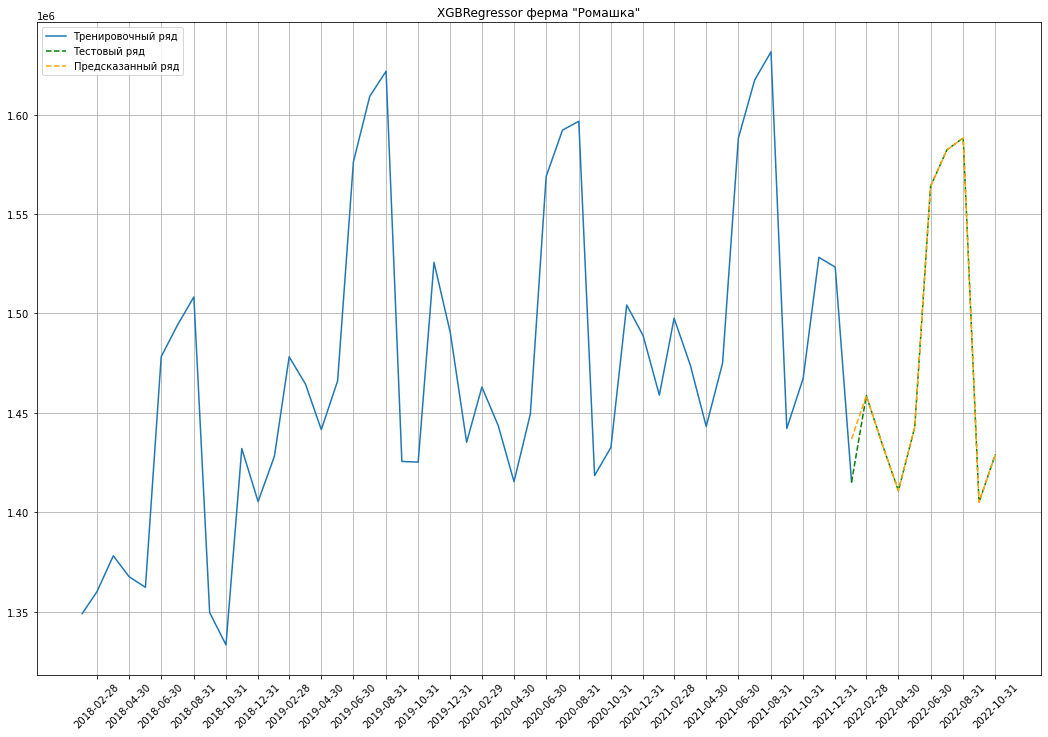

In [194]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot()
ax.plot(df_timeseries_rom_train.MilkingAmount, label='Тренировочный ряд')
ax.plot(df_timeseries_rom_test.MilkingAmount, color='green', label='Тестовый ряд', ls='dashed')
ax.plot(predictions, color='orange', label='Предсказанный ряд', ls='dashed')
plt.legend(loc='upper left')
plt.title('XGBRegressor ферма "Ромашка"')
plt.xticks(np.append(df_timeseries_rom_train.Date.values[1::2], df_timeseries_rom_test.Date.values[1::2]), rotation=45)
plt.grid(True)
plt.show();